
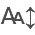

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import missingno as msno
from itables import show
from itables import init_notebook_mode
from scipy.stats import pearsonr
import json
import scipy.stats as stats

# Set the maximum number of rows and columns displayed
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

# Set options for itables
init_notebook_mode(all_interactive=True)

%matplotlib inline

To view interactive components from github, click this link:
https://nbviewer.org/github/deannachurch/SBCapstone_CRISPRScreens/blob/main/notebooks/Brunello_count_library.ipynb

# Overview

**Purpose:** 
* Integrate various gene/transcript attributes.
* EDA on guide count metrics as well as transcript meetrics

**Background:** There are a lot of variabilities in this screens, and lots of false positive. Understanding better ways we can understand effect sizes and the number of samples needed for a statistically significant experiment is useful, even if people can't do the recommended number of samples (for cost or experimental reasons)


# Functions

In [2]:
def define_outliers(df, col):
    """ 
    define_outliers

    Takes a dataframe and a column and calculates the IQR to remove outliers.
    Note- column must be numerical

    Calcualte the Q1, Q3 and IQR and return the outliers for later filtering
    """
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"The column {col} is not numeric")
    
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR = Q3-Q1

    outliers=(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    return(outliers)

In [3]:
def box_strip_plot(df, col, title, y_label):
    """ 
    Take a dataframe, the column of interest and some labeling info and make 
    box and stripplots

    return the fig
    """
    outliers=define_outliers(df, col)
    df_outliers = df[outliers]
    df_main = df[~outliers]

    out_melted_df = pd.melt(df_outliers, value_vars=col)
    main_melted_df = pd.melt(df_main, value_vars=col)
    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6)) 

    # Plot for main data without outliers on the first subplot
    sns.boxplot(x='variable', y='value', data=main_melted_df, color='#9B9B93', boxprops=dict(alpha=0.5), ax=axes[0])
    sns.stripplot(x='variable', y='value', data=main_melted_df, jitter=True, color='#CD8C0F', alpha=0.5, ax=axes[0])
    axes[0].set_title(f"{col}: Main Data without Outliers")
    axes[0].set_xlabel('')  # Turn off x-axis label
    axes[0].set_ylabel(y_label)  # Set y-axis label only for the left plot

    # Plot for outliers on the second subplot
    sns.boxplot(x='variable', y='value', data=out_melted_df, color='#9B9B93', boxprops=dict(alpha=0.5), ax=axes[1])
    sns.stripplot(x='variable', y='value', data=out_melted_df, color='#CD8C0F', jitter=True, ax=axes[1])
    axes[1].set_title(f"{col}: Outliers")
    axes[1].set_xlabel('')  # Turn off x-axis label
    axes[1].set_ylabel('')  # Turn off y-axis label for the right plot

    # Sort df_outliers to find the two biggest values
    top_outliers = df_outliers.sort_values(by=col, ascending=False).head(3)

    #Loop through the top outliers to add labels with 'Target Gene Symbol'
    for index, row in top_outliers.iterrows():
        axes[1].text(x=0+0.1, y=row[col], s=row['Target Gene Symbol'], color='black', va='center')

    # Annotation for the total number of data points in the main data plot
    total_main = len(df_main)
    axes[0].text(0.95, 0.95, f'Total: {total_main}', transform=axes[0].transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=12, color='blue')

    # Annotation for the total number of data points in the outliers plot
    total_outliers = len(df_outliers)
    axes[1].text(0.95, 0.95, f'Total: {total_outliers}', transform=axes[1].transAxes, 
             horizontalalignment='right', verticalalignment='top', fontsize=12, color='blue')

    fig.suptitle(f"{col}: {title}")

    return fig

In [4]:
def plot_hist(df, col, bin_no, title, x_label):
    """ 
    Take a dataframe and column of interest, the bin number and plot label info
    and make a histogram of data.

    return the fig.
    """
    # Filter out null values
    non_null_df = df[col].dropna()

    # Plot  histogram
    fig=plt.hist(non_null_df, bins=bin_no, edgecolor='black')

    # Set labels and title
    plt.xlabel(x_label)
    plt.ylabel('Frequency')
    plt.title(title)

    return fig

In [5]:
def cal_cpm(df, col):
    """ 
    cal_cpm: 
    
    take a col in a dataframe that represents a count and calculate the counts per million.
    return the dataframe

    """
    
    if not pd.api.types.is_numeric_dtype(df[col]):
        raise TypeError(f"The column {col} is not numeric")
    total_counts = df[col].sum()
    normalized_col_name = col + '_CPM'  # Create a new column name for the normalized data
    df[normalized_col_name] = (df[col] / total_counts) * 1_000_000

    return df

In [6]:
def dist_plots(df, col_list):
    """ 
    dist_plots 
    take a dataframe and a column list
    Plot the distributions for that columns

    return the figure
    """
    # Calculate the number of rows and columns needed for the subplots
    num_cols = 4  # You can adjust this number based on your preference
    num_rows = len(col_list) // num_cols + (1 if len(col_list) % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axs = axs.flatten()  # Flatten the array for easy iteration

    for i, col in enumerate(col_list):
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"The column {col} is not numeric, skipping col.")
            continue
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'Distribution of {col}')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    return fig


In [7]:
def dist_plots_by_quartile(df, col_list, quart_list):
    # Calculate the number of rows and columns needed for the subplots
    # Assuming 4 plots per count column (one for each quartile)
    num_cols = 2  # Adjust based on your preference for layout
    num_rows_per_col = 4  # One row per quartile
    total_plots = len(col_list) * num_rows_per_col
    num_rows = total_plots // num_cols + (1 if total_plots % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axs = axs.flatten()  # Flatten the array for easy iteration

    plot_index = 0  # Index to track the subplot to use
    for idx, col in enumerate(col_list):
        quartile_col=quart_list[idx]

        if quartile_col not in df.columns:
            print(f"No quartile column found for {col}, skipping.")
            continue

        for quartile in sorted(df[quartile_col].unique()):
            sns.histplot(df[df[quartile_col] == quartile][col], kde=True, ax=axs[plot_index])
            axs[plot_index].set_title(f'Distribution of {col} - Quartile {quartile}')
            plot_index += 1

            # Check if we've filled all allocated subplots
            if plot_index >= len(axs):
                break

        # Check if we've filled all allocated subplots
        if plot_index >= len(axs):
            print("Not enough subplots for all quartiles, some plots may be missing.")
            break

    # Hide any unused subplots
    for j in range(plot_index, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    return fig

In [8]:
def q_q_plots(df, dis, col_list, title):
    """ 
    q_q_plots
    take a column, distribution (that is appropriate) and a list of columns to make q-q plots

    return fig
    """
    #Calculate the number of rows and columns needed for the subplots
    num_cols = 4  # You can adjust this number based on your preference
    num_rows = len(col_list) // num_cols + (1 if len(col_list) % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axs = axs.flatten()  # Flatten the array for easy iteration
    
    for i, col in enumerate(col_list, 1):
        print(f"Processing {col}")
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"The column {col} is not numeric, skipping col.")
            continue
        ax = axs[i]  # Use the current subplot
        stats.probplot(df[col], dist=dis, plot=ax)
        new_title=f"{title}: {col}"
        wrap_title=textwrap.fill(new_title, width = 40)
        ax.set_title(wrap_title)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)
        
    plt.tight_layout()
    return fig

In [9]:
def calculate_tiles(df, bin_no, count_cols):
    """
    Calculate appropriate 'tile' (quartile, decile, etc) for a count column in a dataframe.

    Parameters:
        df (pd.DataFrame): dataframe on which to operate
        bin_no (int): number of tiles to produce (4 for quartile, 10 for decile, etc)
        count_cols (list): 
    
    Returns:
        pd.DataFrame: The dataframe with the added 'tile' column
    """
    # Data validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df should be a pandas DataFrame")
    if not isinstance(count_cols, list):
        raise TypeError("count_cols should be a list")
    if not all(pd.api.types.is_numeric_dtype(df[col]) for col in count_cols):
        raise TypeError("All elements in count_cols should be numeric")

    if bin_no == 4:
        suffix="quartile"
    elif bin_no == 10:
        suffix="decile"
    else:
        suffix=f"{bin_no}_tile"
    
    for count_col in count_cols:
        new_col=f'{count_col}_{suffix}'
        df[new_col] = pd.qcut(df[count_col], bin_no, labels=False) + 1 

    return df

# Read files

In [10]:
## files to analyze
#from original paper describing this library
#cells used A375 (a melanoma cell line)
brunello='../data/raw/Brunnello_libraryPaper/brunello_plasmid_counts.xlsx' #sheet 1 orig trac, sheet2 mod trac, sheet3 annotations
b_guide_annotation='../data/raw/Brunnello_libraryPaper/broadgpp-brunello-library-contents.txt' #guide annotation from current distributor

#from israeli et al paper, also used Brunello library but in CALU-3 cells
israeli='../data/raw/Israeli_2023/GSE197962_sgRNA_counts.txt'
i_b_guide_annotation='../data/raw/Israeli_2023/broadgpp-brunello-library-contents.txt' #info with this paper

# Check 1: guide list and annotation

Check the two guide files to ensure they contain the same data and annotations

In [11]:
b_guide_df=pd.read_csv(b_guide_annotation, delimiter='\t')
b_guide_df.head()

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0             1.0               A1BG       NM_130786.3     NC_000019.10   
1             1.0               A1BG       NM_130786.3     NC_000019.10   
2             1.0               A1BG       NM_130786.3     NC_000019.10   
3             1.0               A1BG       NM_130786.3     NC_000019.10   
4             2.0                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [12]:
i_guide_df=pd.read_csv(i_b_guide_annotation, delimiter='\t')
i_guide_df.head()

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0             1.0               A1BG       NM_130786.3     NC_000019.10   
1             1.0               A1BG       NM_130786.3     NC_000019.10   
2             1.0               A1BG       NM_130786.3     NC_000019.10   
3             1.0               A1BG       NM_130786.3     NC_000019.10   
4             2.0                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [13]:
## Check the shapes
print(f"The shape of the original file {b_guide_df.shape}")
print(f"The shape of the Israeli guide file {i_guide_df.shape}")

The shape of the original file (77441, 11)
The shape of the Israeli guide file (77441, 11)


In [14]:
diff = b_guide_df.compare(i_guide_df)
print(diff)

Empty DataFrame
Columns: []
Index: []


## conclusion: Guide source

The two guide definitaion data frames seem to be the same. Rename one to 'guide_df' and delete the other dataframe to save space

In [15]:
guide_df=b_guide_df
del i_guide_df
del b_guide_df
show(guide_df.head())

# Info on guide

- [X] How many non-targeting (control) guides
- [X] Distribution of guides per gene
- [X] How many guides are sense/antisense?
- [X] How many different and types of PAMs are targeted?
- [X] How many genes are targeted?
    - [X] Do we need to get transcript length? Will only get this for the one transcript in the file (not many of these have been updated.)
    - [X] Get isoform number [will just use the latest annotation based on gene for this]
    - [X] Add Essential/Non-Essential Annotation
    - [X] Do we need to get gene length (that is exon + intron length) 
    - [X] Expression (for A375)
    - [X] Constraint

In [16]:
guide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target Gene ID                        76441 non-null  float64
 1   Target Gene Symbol                    77441 non-null  object 
 2   Target Transcript                     76441 non-null  object 
 3   Genomic Sequence                      76441 non-null  object 
 4   Position of Base After Cut (1-based)  76441 non-null  float64
 5   Strand                                76441 non-null  object 
 6   sgRNA Target Sequence                 77441 non-null  object 
 7   Target Context Sequence               76441 non-null  object 
 8   PAM Sequence                          76441 non-null  object 
 9   Exon Number                           76441 non-null  float64
 10  Rule Set 2 score                      76441 non-null  float64
dtypes: float64(4), 

In [17]:
#convert Target Gene ID to int, first have to fillna(0) for non-targeting guides
guide_df['Target Gene ID']=guide_df['Target Gene ID'].fillna(0).astype(int)
guide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target Gene ID                        77441 non-null  int64  
 1   Target Gene Symbol                    77441 non-null  object 
 2   Target Transcript                     76441 non-null  object 
 3   Genomic Sequence                      76441 non-null  object 
 4   Position of Base After Cut (1-based)  76441 non-null  float64
 5   Strand                                76441 non-null  object 
 6   sgRNA Target Sequence                 77441 non-null  object 
 7   Target Context Sequence               76441 non-null  object 
 8   PAM Sequence                          76441 non-null  object 
 9   Exon Number                           76441 non-null  float64
 10  Rule Set 2 score                      76441 non-null  float64
dtypes: float64(3), 

In [18]:
# Export transcript list for looking up length in next notebook
tot_tx_list=guide_df['Target Transcript'].to_list()
tx_list=list(set(tot_tx_list))
with open('../data/processed/tx_list.txt', 'w') as file:
    for item in tx_list:
        file.write("%s\n" % item)


In [19]:
print(f"There are {guide_df['Target Gene Symbol'].nunique() -1} genes targeted (subtracted 1 for the 'Non-Targeting Control')")

There are 19114 genes targeted (subtracted 1 for the 'Non-Targeting Control')


In [20]:
gene_counts = guide_df['Target Gene Symbol'].value_counts()
print(gene_counts)

Target Gene Symbol
Non-Targeting Control    1000
WDR26                       4
RUFY1                       4
ORAI2                       4
PAAF1                       4
                         ... 
CT45A1                      2
MTRNR2L1                    2
CT45A2                      2
ZNF502                      2
DEFB107B                    1
Name: count, Length: 19115, dtype: int64


In [21]:
print(f"There are {gene_counts['Non-Targeting Control']} control guides")

There are 1000 control guides


In [22]:
# Filter out 'Non-Targeting Control' from gene_counts
# Calculate the frequency of guide counts
filtered_gene_counts = gene_counts[gene_counts.index != 'Non-Targeting Control']
guide_count_frequency = filtered_gene_counts.value_counts().sort_index()
freq=guide_count_frequency.reset_index(name='Gene Count')
freq.rename(columns={'count': 'Guide Count'}, inplace=True)


In [23]:
show(filtered_gene_counts.head())

In [24]:
gene_id_list=guide_df['Target Gene ID'].fillna(-1).astype(int).to_list()
gid_list=list(set(gene_id_list))
print(len(gid_list))
print(len(set(gid_list)))

19115
19115


In [25]:
print(gid_list)

[0, 1, 2, 100129239, 131076, 9, 10, 12, 13, 14, 15, 16, 729447, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 163882, 43, 131118, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 70, 71, 72, 131149, 81, 100507003, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 163933, 97, 98, 100, 101, 102, 103, 104, 105, 131177, 107, 108, 109, 338692, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 196740, 196743, 140, 141, 142, 143, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 644809, 100129271, 173, 174, 175, 176, 177, 178, 220134, 181, 182, 183, 196792, 185, 186, 187, 189, 190, 191, 644815, 196, 197, 199, 202, 203, 204, 205, 164045, 207, 208, 100507027, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 149840, 229, 230, 231, 238, 239, 240, 241, 242, 246, 247, 248, 249, 250, 251, 164091, 257, 25

In [26]:
with open('../data/processed/gid_list.txt', 'w') as file:
    for item in gid_list:
        file.write("%s\n" % item)

In [27]:
# Summary statistics
summary_stats = filtered_gene_counts.describe()
print("Summary Statistics:\n", summary_stats)

# Detailed statistics
mean_value = filtered_gene_counts.mean()
median_value = filtered_gene_counts.median()
max_value = filtered_gene_counts.max()
min_value = filtered_gene_counts.min()

print("\nDetailed Statistics:")
print("Mean:", mean_value)
print("Median:", median_value)
print("Max:", max_value)
print("Min:", min_value)

Summary Statistics:
 count    19114.000000
mean         3.999215
std          0.041545
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: count, dtype: float64

Detailed Statistics:
Mean: 3.9992152349063512
Median: 4.0
Max: 4
Min: 1


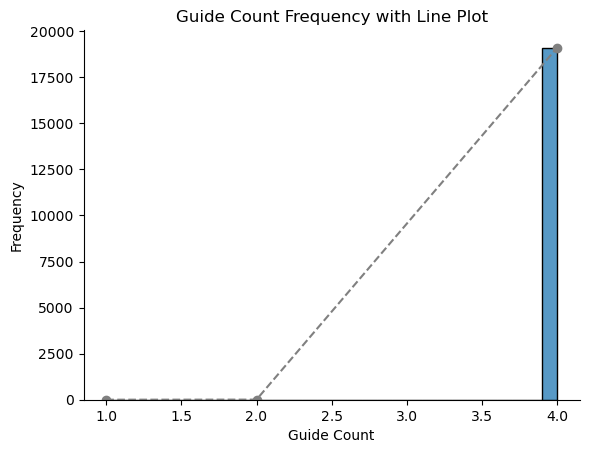

In [28]:
# Plotting the histogram
#Not using function as this one is a bit different
sns.histplot(data=freq, x='Guide Count', weights='Gene Count', bins=30, kde=False)

# Overlaying a line plot
plt.plot(freq['Guide Count'], freq['Gene Count'], marker='o', linestyle='--', color='grey')
sns.despine(top=True, right=True)

# Adding labels and title
plt.xlabel('Guide Count')
plt.ylabel('Frequency')
plt.title('Guide Count Frequency with Line Plot')

# Show plot
plt.show()

# Conclusion: Guide distribution

All but two genes have 4 guides- there is very little count variation in this dataset. 

In [29]:
strand_counts = guide_df['Strand'].value_counts()

In [30]:
show(strand_counts)

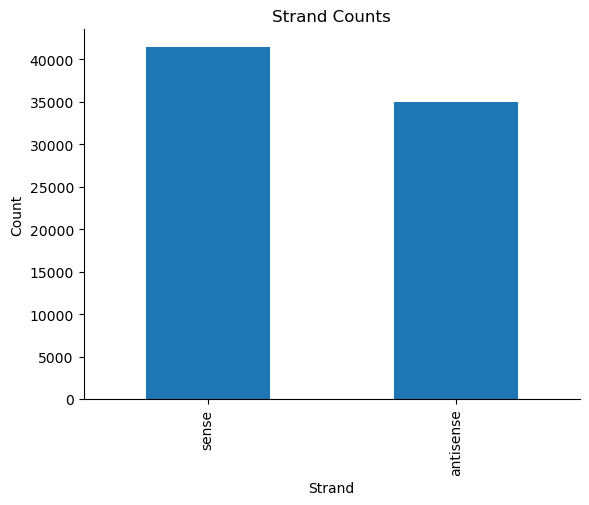

In [31]:
strand_counts.plot(kind='bar')
sns.despine(top=True, right=True)
plt.xlabel('Strand')
plt.ylabel('Count')
plt.title('Strand Counts')
plt.show()

# Conclusion: Strand Usage

Fairly even split of sense/antisense strand, with slightly more sense strand guides

In [32]:
pam_counts = guide_df['PAM Sequence'].value_counts()
show(pam_counts)

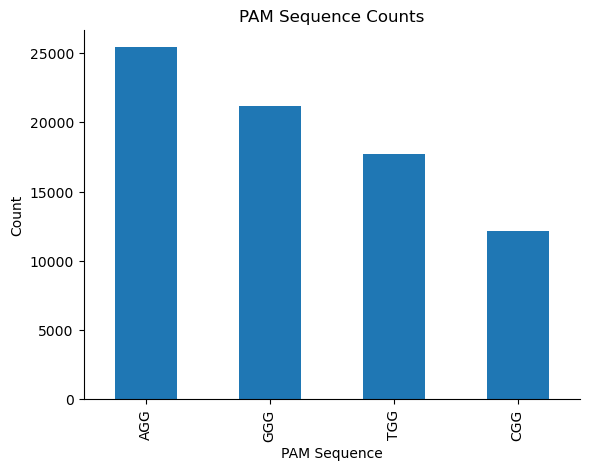

In [33]:
pam_counts.plot(kind='bar')
sns.despine(top=True, right=True)
plt.xlabel('PAM Sequence')
plt.ylabel('Count')
plt.title('PAM Sequence Counts')
plt.show()

# Conclusion: PAM usage

Uneven distribution of PAM site usage.

# Add in gene/tx specific information

To do this we should make a new dataframe that just has gene relevant information, make this non-redundant and then check for consistency.
Related to Issue #6 in github

In [34]:
display(guide_df.head())

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0               1               A1BG       NM_130786.3     NC_000019.10   
1               1               A1BG       NM_130786.3     NC_000019.10   
2               1               A1BG       NM_130786.3     NC_000019.10   
3               1               A1BG       NM_130786.3     NC_000019.10   
4               2                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Exon Number  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [35]:
# But first, rename 'Exon Number' to 'Target Exon'

guide_df.rename(columns={'Exon Number': 'Target Exon'}, inplace=True)
display(guide_df.head())

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0               1               A1BG       NM_130786.3     NC_000019.10   
1               1               A1BG       NM_130786.3     NC_000019.10   
2               1               A1BG       NM_130786.3     NC_000019.10   
3               1               A1BG       NM_130786.3     NC_000019.10   
4               2                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Target Exon  Rule Set 2 score  
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165  
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176  
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264  
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156  
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765

In [36]:
gene_tx_df = guide_df[['Target Gene ID', 'Target Gene Symbol', 'Target Transcript']].copy()
gene_tx_df.drop_duplicates(inplace=True)
show(gene_tx_df.head())

# Add in transcript length information

In [37]:
with open('../data/processed/tx_info.json', 'r') as file:
    tx_dict = json.load(file)

# Convert dictionary to a list of tuples [(key1, value1), (key2, value2), ...]
data = list(tx_dict.items())

# Create a DataFrame from the list of tuples
tx_df = pd.DataFrame(data, columns=['Target Transcript', 'Tx Length'])

# Show the first few rows of the DataFrame
show(tx_df.head())

# Merge length into into the main dataframe

In [38]:
#merge length info into the main dataframe
guide_len_df = gene_tx_df.merge(tx_df, on='Target Transcript', how='left')

print(f"Null values in Tx Length column {guide_len_df['Tx Length'].isnull().sum()}")
#clean old dfs
#del guide_df
#del tx_df
#guide_df=guide_len_df


#show(guide_len_df.head())

Null values in Tx Length column 1



The Tx length for non-targeting guides is NaN- will imput to 0 for model building

In [39]:
guide_len_df['Tx Length'] = guide_len_df['Tx Length'].fillna(0)

In [40]:
#clean old dfs
del gene_tx_df
del tx_df
gene_tx_df=guide_len_df

show(gene_tx_df.head())
del guide_len_df

In [41]:
#check for duplicates
duplicates=gene_tx_df[gene_tx_df.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Target Gene ID, Target Gene Symbol, Target Transcript, Tx Length]
Index: []


# Add in isoform number

In [42]:
with open('../data/processed/gene_isoform.json', 'r') as file:
    gene2iso_dict = json.load(file)

# Convert dictionary to a list of tuples [(key1, value1), (key2, value2), ...]
data = list(gene2iso_dict.items())

# Create a DataFrame from the list of tuples
gene2iso_df = pd.DataFrame(data, columns=['Target Gene ID', 'Gene Isoform Count'])

# Show the first few rows of the DataFrame
show(gene2iso_df.head())

In [43]:
gene2iso_df.dtypes

Target Gene ID        object
Gene Isoform Count     int64
dtype: object

In [44]:
gene2iso_df['Target Gene ID']=gene2iso_df['Target Gene ID'].astype(float)

In [45]:
#merge isoform count info into the main dataframe
guide_iso_df = gene_tx_df.merge(gene2iso_df, on='Target Gene ID', how='left')

print(f"Null values in Gene Isoform column {guide_iso_df['Gene Isoform Count'].isnull().sum()}")

Null values in Gene Isoform column 37


In [46]:
null_iso=guide_iso_df[guide_iso_df['Gene Isoform Count'].isnull()]
show(null_iso)

In [47]:
null_iso_gene=null_iso['Target Gene ID'].to_list()
null_iso_uniq=list(set(null_iso_gene))
print(f"missing isoform counts for {len(null_iso_uniq)}")

missing isoform counts for 37


# Genes with missing isoform counts

There are 1036 of these, a manual review of a few of these suggests these have been withdraw from annotation since the guide library was made. In some cases these were converted to other genes, in others just dropped. Probably OK for now. Will upgrade these to 1 as there is likely at least 1 transcript- and will distinguish from non-targeting guides. 

In [48]:
#clean old dfs
del gene_tx_df
del gene2iso_df
gene_tx_df=guide_iso_df

show(gene_tx_df.head())
del guide_iso_df

In [49]:
nan_count = gene_tx_df['Gene Isoform Count'].isnull().sum()
nan_count

37

In [50]:
gene_tx_df.loc[gene_tx_df['Target Gene Symbol'] == 'Non-Targeting Control', 'Gene Isoform Count'] = 0

In [51]:
gene_tx_df['Gene Isoform Count'] = gene_tx_df['Gene Isoform Count'].fillna(1)

In [52]:
print(gene_tx_df['Gene Isoform Count'].isnull().sum())

0


In [53]:
#check for duplicates
duplicates=gene_tx_df[gene_tx_df.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Target Gene ID, Target Gene Symbol, Target Transcript, Tx Length, Gene Isoform Count]
Index: []


# Annotate gene essentiality

In [54]:
gene_annot=pd.read_csv('../data/processed/gene_annot.csv')
display(gene_annot)

Target Gene ID    Annotation
0            10189.0     Essential
1             9716.0     Essential
2              372.0     Essential
3            55299.0     Essential
4                NaN     Essential
...              ...           ...
1139        219578.0  NonEssential
1140        148066.0  NonEssential
1141          7783.0  NonEssential
1142         57829.0  NonEssential
1143        151112.0  NonEssential

[1144 rows x 2 columns]

In [55]:
guide_annot_df=gene_tx_df.merge(gene_annot, on='Target Gene ID', how='left')
display(guide_annot_df)

Target Gene ID     Target Gene Symbol Target Transcript  Tx Length  \
0                   1                   A1BG       NM_130786.3     1766.0   
1                   2                    A2M       NM_000014.4     4678.0   
2                   9                   NAT1       NM_000662.7     1821.0   
3                  10                   NAT2       NM_000015.2     1317.0   
4                  12               SERPINA3       NM_001085.4     1629.0   
...               ...                    ...               ...        ...   
19110       102724862           LOC102724862    NM_001291463.1     2065.0   
19111       102724957           LOC102724957    NM_001293172.1      471.0   
19112       102800317       LOC400927-CSNK1E    NM_001289912.1     2997.0   
19113       104909134         MGC57346-CRHR1    NM_001256299.2     2712.0   
19114               0  Non-Targeting Control               NaN        0.0   

       Gene Isoform Count Annotation  
0                     1.0        NaN  
1                     6.0        NaN  
2                    16.0        NaN  
3                     3.0        NaN  
4                     5.0        NaN  
...                   ...        ...  
19110                24.0        NaN  
19111                 1.0        NaN  
19112                 1.0        NaN  
19113                 6.0        NaN  
19114                 0.0        NaN  

[19115 rows x 6 columns]

In [56]:
guide_annot_df['Annotation'].value_counts()

Annotation
NonEssential    858
Essential       207
Name: count, dtype: int64

In [57]:
guide_annot_df['Annotation']=guide_annot_df['Annotation'].fillna('Uncategorized')

In [58]:
guide_annot_df['Annotation'].value_counts()

Annotation
Uncategorized    18050
NonEssential       858
Essential          207
Name: count, dtype: int64

In [59]:
# Clean house
#clean old dfs
del gene_tx_df
del gene_annot
gene_tx_df=guide_annot_df

show(gene_tx_df.head())
del guide_annot_df

In [60]:
gene_tx_df.isnull().count()

Target Gene ID        19115
Target Gene Symbol    19115
Target Transcript     19115
Tx Length             19115
Gene Isoform Count    19115
Annotation            19115
dtype: int64

In [61]:
#check for duplicates
duplicates=gene_tx_df[gene_tx_df.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Target Gene ID, Target Gene Symbol, Target Transcript, Tx Length, Gene Isoform Count, Annotation]
Index: []


# Add in Gene Length data

In [62]:
gene_len_df=pd.read_csv('../data/processed/gene_info.csv')
gene_len_df.rename(columns={'length': 'Gene Length'}, inplace=True)
display(gene_len_df.head())

Gene Length         name    gene_id
0           68    MIR6859-1  102466751
1         5645  MIR1302-2HG  107985730
2          138    MIR1302-2  100302278
3         1471      FAM138A     645520
4         6167        OR4F5      79501

In [63]:
gene_dups=gene_len_df[gene_len_df.duplicated(keep=False)]
display(gene_dups.sort_values('name'))

Empty DataFrame
Columns: [Gene Length, name, gene_id]
Index: []

In [64]:
guide_gene_len_df = gene_tx_df.merge(gene_len_df, left_on='Target Gene ID', right_on='gene_id',  how='left')
#display(guide_gene_len_df.head())

print(f"Null values in Gene Length column {guide_gene_len_df['Gene Length'].isnull().sum()}")

Null values in Gene Length column 135


In [66]:
null_gene_len_df=guide_gene_len_df[guide_gene_len_df['Gene Length'].isnull()]
display(null_gene_len_df.head())

Target Gene ID Target Gene Symbol Target Transcript  Tx Length  \
1537            2210             FCGR1B    NM_001017986.3     1917.0   
2754            4104             MAGEA5       NM_021049.4     1664.0   
3576            5408           PNLIPRP2       NM_005396.4     1486.0   
3677            5542               PRB1       NM_005039.3     1173.0   
4725            6953              TCP10       NM_004610.3     1273.0   

      Gene Isoform Count     Annotation  Gene Length name  gene_id  
1537                 7.0  Uncategorized          NaN  NaN      NaN  
2754                 2.0  Uncategorized          NaN  NaN      NaN  
3576                 2.0   NonEssential          NaN  NaN      NaN  
3677                 5.0   NonEssential          NaN  NaN      NaN  
4725                 9.0  Uncategorized          NaN  NaN      NaN

In [67]:
print(null_gene_len_df['Annotation'].value_counts())

Annotation
Uncategorized    131
NonEssential       4
Name: count, dtype: int64


In [68]:
non_essential_null_gene_len_df = null_gene_len_df[null_gene_len_df['Annotation'] == 'NonEssential']
display(non_essential_null_gene_len_df)

Target Gene ID Target Gene Symbol Target Transcript  Tx Length  \
3576             5408           PNLIPRP2       NM_005396.4     1486.0   
3677             5542               PRB1       NM_005039.3     1173.0   
17135          317705              VN1R5       NM_173858.1     1074.0   
18105          401285            TCP10L2    NM_001145121.1     2185.0   

       Gene Isoform Count    Annotation  Gene Length name  gene_id  
3576                  2.0  NonEssential          NaN  NaN      NaN  
3677                  5.0  NonEssential          NaN  NaN      NaN  
17135                 2.0  NonEssential          NaN  NaN      NaN  
18105                12.0  NonEssential          NaN  NaN      NaN

OK- manual review of a few of these genes suggest that many of these have been changed to pseudogenes. PRB1 is an exception. I'm not sure why this got missed but I can manually update with the gene length.
Maybe will manually update for all of these

PRB1 gene length = 3,771

PNLIPRP2 = 24191

VN1R5 = 1074

TCP10L2 = 26133

remainder will change to 0- most don't have meaningful annotation anyway.

In [69]:
guide_gene_len_df.loc[guide_gene_len_df['Target Gene ID'] == 5542, 'Gene Length'] = 3771
guide_gene_len_df.loc[guide_gene_len_df['Target Gene ID'] == 3576, 'Gene Length'] = 24191
guide_gene_len_df.loc[guide_gene_len_df['Target Gene ID'] == 317705, 'Gene Length'] = 1074
guide_gene_len_df.loc[guide_gene_len_df['Target Gene ID'] == 401285, 'Gene Length'] = 26133


In [70]:
display(guide_gene_len_df[guide_gene_len_df['Target Gene ID'].isin([5542, 3576, 317705, 401285])])

Target Gene ID Target Gene Symbol Target Transcript  Tx Length  \
2363             3576              CXCL8       NM_000584.3     1718.0   
3677             5542               PRB1       NM_005039.3     1173.0   
17135          317705              VN1R5       NM_173858.1     1074.0   
18105          401285            TCP10L2    NM_001145121.1     2185.0   

       Gene Isoform Count     Annotation  Gene Length   name  gene_id  
2363                  3.0  Uncategorized      24191.0  CXCL8   3576.0  
3677                  5.0   NonEssential       3771.0    NaN      NaN  
17135                 2.0   NonEssential       1074.0    NaN      NaN  
18105                12.0   NonEssential      26133.0    NaN      NaN

In [71]:
guide_gene_len_df.loc[guide_gene_len_df['Target Gene Symbol'] == 'Non-Targeting Control', 'Gene Length'] = 0

In [72]:
guide_gene_len_df.loc[guide_gene_len_df['Gene Length'].isnull(), 'Gene Length'] = guide_gene_len_df['Tx Length']

In [73]:
guide_gene_len_df['Gene Length'].isnull().sum()

0

In [74]:
guide_gene_len_df.drop(columns=['gene_id', 'name'], inplace=True)

In [75]:
# Clean house
#clean old dfs
del gene_tx_df
gene_tx_df=guide_gene_len_df

show(gene_tx_df.head())
del guide_gene_len_df

In [76]:
#check for duplicates
duplicates=gene_tx_df[gene_tx_df.duplicated(keep=False)]
display(duplicates)

Empty DataFrame
Columns: [Target Gene ID, Target Gene Symbol, Target Transcript, Tx Length, Gene Isoform Count, Annotation, Gene Length]
Index: []

# Add in A375 expression

In [77]:
exp_df=pd.read_csv('../data/processed/GSE249290_gene_counts_selected.csv')
exp_df.rename(columns={"mean": "A375 mean", "median": "A375 median", "std_dev": "A375 std_dev"}, inplace=True)
display(exp_df.head())

gene_id   A375 mean  A375 median  A375 std_dev
0      A1BG   51.445406    41.893863     32.394602
1  A1BG-AS1  227.981059   156.738026    199.711470
2      A1CF    0.113953     0.000000      0.185041
3       A2M    7.214316     2.056853     12.621402
4   A2M-AS1   23.430600    19.198812     21.527143

In [78]:
# Merge guide_df and exp_df on Target Transcript and gene_id
merged_df = gene_tx_df.merge(exp_df, left_on='Target Gene Symbol', right_on='gene_id', how='left')

# Display the first few rows of the merged dataframe
show(merged_df.head())

In [79]:
print(merged_df['A375 mean'].isnull().sum())

359


In [80]:
missing_exp_df=merged_df[merged_df['A375 mean'].isnull()]
display(missing_exp_df)

Target Gene ID     Target Gene Symbol Target Transcript  Tx Length  \
392               575                 ADGRB1       NM_001702.2     5535.0   
393               576                 ADGRB2    NM_001294335.1     5455.0   
394               577                 ADGRB3       NM_001704.2     5650.0   
691               976                 ADGRE5       NM_078481.3     3500.0   
1389             2015                 ADGRE1       NM_001974.4     3161.0   
...               ...                    ...               ...        ...   
19110       102724473                 GAGE10    NM_001098413.3      561.0   
19111       102724631                 POTEB3       NM_207355.3     2136.0   
19114       102800317       LOC400927-CSNK1E    NM_001289912.1     2997.0   
19115       104909134         MGC57346-CRHR1    NM_001256299.2     2712.0   
19116               0  Non-Targeting Control               NaN        0.0   

       Gene Isoform Count     Annotation  Gene Length gene_id  A375 mean  \
392                  19.0  Uncategorized      95359.0     NaN        NaN   
393                  32.0  Uncategorized      37224.0     NaN        NaN   
394                   1.0  Uncategorized     754225.0     NaN        NaN   
691                   4.0  Uncategorized      27280.0     NaN        NaN   
1389                  6.0  Uncategorized      52872.0     NaN        NaN   
...                   ...            ...          ...     ...        ...   
19110                 2.0  Uncategorized      16199.0     NaN        NaN   
19111                16.0  Uncategorized      35099.0     NaN        NaN   
19114                 1.0  Uncategorized     108225.0     NaN        NaN   
19115                 6.0  Uncategorized     215483.0     NaN        NaN   
19116                 0.0  Uncategorized          0.0     NaN        NaN   

       A375 median  A375 std_dev  
392            NaN           NaN  
393            NaN           NaN  
394            NaN           NaN  
691            NaN           NaN  
1389           NaN           NaN  
...            ...           ...  
19110          NaN           NaN  
19111          NaN           NaN  
19114          NaN           NaN  
19115          NaN           NaN  
19116          NaN           NaN  

[359 rows x 11 columns]

In [81]:
print(missing_exp_df['Annotation'].value_counts())

Annotation
Uncategorized    348
NonEssential      11
Name: count, dtype: int64


692 genes missing expression level. 
Most are annotated as Uncategorized- a few are 'NonEssential'

Two fill in missing data:
* imput mean, median and std_dev with the median of the column

In [82]:
# Impute missing values with the median of the column
merged_df['A375 mean'] = merged_df['A375 mean'].fillna(merged_df['A375 mean'].median())
merged_df['A375 median'] = merged_df['A375 median'].fillna(merged_df['A375 median'].median())
merged_df['A375 std_dev'] = merged_df['A375 std_dev'].fillna(merged_df['A375 std_dev'].median())

# Verify that there are no missing values left in these columns
print(merged_df[['A375 mean', 'A375 median', 'A375 std_dev']].isnull().sum())

A375 mean       0
A375 median     0
A375 std_dev    0
dtype: int64


In [83]:
# Clean house
#clean old dfs
del gene_tx_df
gene_tx_df=merged_df

show(gene_tx_df.head())
del merged_df

In [84]:
#check for duplicates
duplicates=gene_tx_df[gene_tx_df.duplicated(keep=False)]
display(duplicates)

Empty DataFrame
Columns: [Target Gene ID, Target Gene Symbol, Target Transcript, Tx Length, Gene Isoform Count, Annotation, Gene Length, gene_id, A375 mean, A375 median, A375 std_dev]
Index: []

# Add Constraint Values

In [85]:
const_df=pd.read_csv('../data/processed/constraint_metrics_subset.csv')
display(const_df.head(10))

gene  gene_id      transcript  lof_hc_lc.pLI  lof_hc_lc.pRec  \
0  A1BG        1     NM_130786.4   1.625600e-16         0.15085   
1  A1CF    29974  NM_001198818.2   7.317200e-10         0.99794   
2  A1CF    29974  NM_001198819.2   7.638300e-11         0.99747   
3  A1CF    29974  NM_001198820.2   5.365000e-12         0.99432   
4  A1CF    29974  NM_001370130.1   7.317200e-10         0.99794   
5  A1CF    29974  NM_001370131.1   1.039700e-08         0.99909   
6  A1CF    29974     NM_014576.4   7.317200e-10         0.99794   
7  A1CF    29974     NM_138932.3   1.039700e-08         0.99909   
8  A1CF    29974     NM_138933.3   5.365000e-12         0.99432   
9  A1CF    29974  XM_005269718.2   1.039700e-08         0.99909   

   lof_hc_lc.pNull       lof.pLI  lof.z_score  lof.oe_ci.upper  \
0         0.849150  1.770600e-16     -0.25212            1.340   
1         0.002056  7.656000e-10      2.52860            0.825   
2         0.002527  7.704400e-11      2.35300            0.853   
3         0.005683  5.404400e-12      2.11660            0.890   
4         0.002056  7.656000e-10      2.52860            0.825   
5         0.000913  1.087700e-08      2.76370            0.788   
6         0.002056  7.656000e-10      2.52860            0.825   
7         0.000913  1.087700e-08      2.76370            0.788   
8         0.005683  5.404400e-12      2.11660            0.890   
9         0.000913  1.087700e-08      2.76370            0.788   

  constraint_flags  
0               []  
1               []  
2               []  
3               []  
4               []  
5               []  
6               []  
7               []  
8               []  
9               []

In [86]:
# Filter out rows where 'gene_id' starts with 'ENSG'
const_df.rename(columns={'lof.oe_ci.upper': 'LOEUF'}, inplace=True)

# Display the first few rows of the updated dataframe
display(const_df.head())

gene  gene_id      transcript  lof_hc_lc.pLI  lof_hc_lc.pRec  \
0  A1BG        1     NM_130786.4   1.625600e-16         0.15085   
1  A1CF    29974  NM_001198818.2   7.317200e-10         0.99794   
2  A1CF    29974  NM_001198819.2   7.638300e-11         0.99747   
3  A1CF    29974  NM_001198820.2   5.365000e-12         0.99432   
4  A1CF    29974  NM_001370130.1   7.317200e-10         0.99794   

   lof_hc_lc.pNull       lof.pLI  lof.z_score  LOEUF constraint_flags  
0         0.849150  1.770600e-16     -0.25212  1.340               []  
1         0.002056  7.656000e-10      2.52860  0.825               []  
2         0.002527  7.704400e-11      2.35300  0.853               []  
3         0.005683  5.404400e-12      2.11660  0.890               []  
4         0.002056  7.656000e-10      2.52860  0.825               []

In [87]:
const_df = const_df[['gene_id', 'transcript', 'LOEUF']]

In [88]:
const_df['gene_id'] = const_df['gene_id'].astype(int)

In [89]:
gene_tx_df['Tx Base'] = gene_tx_df['Target Transcript'].str.split('.').str[0]
const_df['transcript'] = const_df['transcript'].str.split('.').str[0]
display(gene_tx_df.head())
display(const_df.head())

Target Gene ID Target Gene Symbol Target Transcript  Tx Length  \
0               1               A1BG       NM_130786.3     1766.0   
1               2                A2M       NM_000014.4     4678.0   
2               9               NAT1       NM_000662.7     1821.0   
3              10               NAT2       NM_000015.2     1317.0   
4              12           SERPINA3       NM_001085.4     1629.0   

   Gene Isoform Count     Annotation  Gene Length   gene_id    A375 mean  \
0                 1.0  Uncategorized       8310.0      A1BG    51.445406   
1                 6.0  Uncategorized      48522.0       A2M     7.214316   
2                16.0  Uncategorized      53223.0      NAT1   214.403118   
3                 3.0  Uncategorized      14918.0      NAT2    11.046498   
4                 5.0  Uncategorized      11663.0  SERPINA3  1079.371017   

   A375 median  A375 std_dev    Tx Base  
0    41.893863     32.394602  NM_130786  
1     2.056853     12.621402  NM_000014  
2   188.216225    121.047907  NM_000662  
3     2.205915     13.919940  NM_000015  
4     1.733226   2367.726258  NM_001085

gene_id    transcript  LOEUF
0        1     NM_130786  1.340
1    29974  NM_001198818  0.825
2    29974  NM_001198819  0.853
3    29974  NM_001198820  0.890
4    29974  NM_001370130  0.825

In [90]:
#Merge into main dataframe
merged_df = gene_tx_df.merge(const_df, left_on='Tx Base', right_on='transcript', how='left')

display(merged_df.head(10))

Target Gene ID Target Gene Symbol Target Transcript  Tx Length  \
0               1               A1BG       NM_130786.3     1766.0   
1               2                A2M       NM_000014.4     4678.0   
2               9               NAT1       NM_000662.7     1821.0   
3              10               NAT2       NM_000015.2     1317.0   
4              12           SERPINA3       NM_001085.4     1629.0   
5              13              AADAC       NM_001086.2     1725.0   
6              14               AAMP       NM_001087.4     1842.0   
7              15              AANAT       NM_001088.2     1048.0   
8              16               AARS       NM_001605.2     3344.0   
9              18               ABAT       NM_020686.5     4814.0   

   Gene Isoform Count     Annotation  Gene Length gene_id_x    A375 mean  \
0                 1.0  Uncategorized       8310.0      A1BG    51.445406   
1                 6.0  Uncategorized      48522.0       A2M     7.214316   
2                16.0  Uncategorized      53223.0      NAT1   214.403118   
3                 3.0  Uncategorized      14918.0      NAT2    11.046498   
4                 5.0  Uncategorized      11663.0  SERPINA3  1079.371017   
5                 2.0  Uncategorized      14373.0     AADAC     0.624275   
6                 3.0  Uncategorized       6009.0      AAMP  2799.122270   
7                 4.0  Uncategorized      16767.0     AANAT     3.223778   
8                 3.0  Uncategorized      37209.0      AARS  4892.311287   
9                25.0  Uncategorized     109954.0      ABAT   329.114077   

   A375 median  A375 std_dev    Tx Base  gene_id_y transcript  LOEUF  
0    41.893863     32.394602  NM_130786        1.0  NM_130786  1.340  
1     2.056853     12.621402  NM_000014        2.0  NM_000014  0.765  
2   188.216225    121.047907  NM_000662        9.0  NM_000662  1.906  
3     2.205915     13.919940  NM_000015       10.0  NM_000015  1.938  
4     1.733226   2367.726258  NM_001085       12.0  NM_001085  1.516  
5     0.000000      1.222674  NM_001086       13.0  NM_001086  1.126  
6  2599.196286    980.266730  NM_001087       14.0  NM_001087  0.372  
7     2.510036      2.838204  NM_001088       15.0  NM_001088  1.283  
8  4892.311287   2103.117036  NM_001605       16.0  NM_001605  0.772  
9   360.280424    279.725514  NM_020686       18.0  NM_020686  0.871

In [91]:
merged_df.drop(columns=['gene_id_x', 'gene_id_y'], inplace=True)
display(merged_df)

Target Gene ID     Target Gene Symbol Target Transcript  Tx Length  \
0                   1                   A1BG       NM_130786.3     1766.0   
1                   2                    A2M       NM_000014.4     4678.0   
2                   9                   NAT1       NM_000662.7     1821.0   
3                  10                   NAT2       NM_000015.2     1317.0   
4                  12               SERPINA3       NM_001085.4     1629.0   
...               ...                    ...               ...        ...   
19112       102724862           LOC102724862    NM_001291463.1     2065.0   
19113       102724957           LOC102724957    NM_001293172.1      471.0   
19114       102800317       LOC400927-CSNK1E    NM_001289912.1     2997.0   
19115       104909134         MGC57346-CRHR1    NM_001256299.2     2712.0   
19116               0  Non-Targeting Control               NaN        0.0   

       Gene Isoform Count     Annotation  Gene Length    A375 mean  \
0                     1.0  Uncategorized       8310.0    51.445406   
1                     6.0  Uncategorized      48522.0     7.214316   
2                    16.0  Uncategorized      53223.0   214.403118   
3                     3.0  Uncategorized      14918.0    11.046498   
4                     5.0  Uncategorized      11663.0  1079.371017   
...                   ...            ...          ...          ...   
19112                24.0  Uncategorized      10966.0     0.000000   
19113                 1.0  Uncategorized        471.0     1.064038   
19114                 1.0  Uncategorized     108225.0   358.969758   
19115                 6.0  Uncategorized     215483.0   358.969758   
19116                 0.0  Uncategorized          0.0   358.969758   

       A375 median  A375 std_dev       Tx Base    transcript  LOEUF  
0        41.893863     32.394602     NM_130786     NM_130786  1.340  
1         2.056853     12.621402     NM_000014     NM_000014  0.765  
2       188.216225    121.047907     NM_000662     NM_000662  1.906  
3         2.205915     13.919940     NM_000015     NM_000015  1.938  
4         1.733226   2367.726258     NM_001085     NM_001085  1.516  
...            ...           ...           ...           ...    ...  
19112     0.000000      0.000000  NM_001291463           NaN    NaN  
19113     0.000000      4.276752  NM_001293172           NaN    NaN  
19114   285.511030    203.822522  NM_001289912  NM_001289912  0.588  
19115   285.511030    203.822522  NM_001256299  NM_001256299  0.760  
19116   285.511030    203.822522           NaN           NaN    NaN  

[19117 rows x 13 columns]

In [92]:
missing_const_df=merged_df[merged_df['LOEUF'].isnull()]
display(missing_const_df)

Target Gene ID     Target Gene Symbol Target Transcript  Tx Length  \
13                 22                  ABCB7       NM_004299.4     2528.0   
128               183                    AGT       NM_000029.3     2587.0   
130               186                  AGTR2       NM_000686.4     2906.0   
133               190                  NR0B1       NM_000475.4     1591.0   
146               212                  ALAS2       NM_000032.4     2044.0   
...               ...                    ...               ...        ...   
19109       102724279           LOC102724279    NM_001302493.1      450.0   
19110       102724473                 GAGE10    NM_001098413.3      561.0   
19112       102724862           LOC102724862    NM_001291463.1     2065.0   
19113       102724957           LOC102724957    NM_001293172.1      471.0   
19116               0  Non-Targeting Control               NaN        0.0   

       Gene Isoform Count     Annotation  Gene Length    A375 mean  \
13                    7.0  Uncategorized     105236.0  1108.469948   
128                   3.0  Uncategorized      43061.0     4.134922   
130                   3.0  Uncategorized       4231.0     0.110961   
133                   2.0  Uncategorized       5185.0    28.318147   
146                   5.0  Uncategorized      21923.0     0.000000   
...                   ...            ...          ...          ...   
19109                 3.0  Uncategorized        450.0     0.495881   
19110                 2.0  Uncategorized      16199.0   358.969758   
19112                24.0  Uncategorized      10966.0     0.000000   
19113                 1.0  Uncategorized        471.0     1.064038   
19116                 0.0  Uncategorized          0.0   358.969758   

       A375 median  A375 std_dev       Tx Base transcript  LOEUF  
13     1103.299212    348.572363     NM_004299        NaN    NaN  
128       0.997884      5.844963     NM_000029        NaN    NaN  
130       0.000000      0.209971     NM_000686        NaN    NaN  
133       0.612172     48.993470     NM_000475        NaN    NaN  
146       0.000000      0.000000     NM_000032        NaN    NaN  
...            ...           ...           ...        ...    ...  
19109     0.000000      1.993125  NM_001302493        NaN    NaN  
19110   285.511030    203.822522  NM_001098413        NaN    NaN  
19112     0.000000      0.000000  NM_001291463        NaN    NaN  
19113     0.000000      4.276752  NM_001293172        NaN    NaN  
19116   285.511030    203.822522           NaN        NaN    NaN  

[1338 rows x 13 columns]

In [93]:
print(len(missing_const_df.index))

1338


In [94]:
print(missing_const_df['Annotation'].value_counts())

Annotation
Uncategorized    1227
NonEssential      104
Essential           7
Name: count, dtype: int64


Manually reviewed serveral genes with now LOEUF value- they truly seem to be missing. I think many of these don't have enough power for calculation, though some seem to be missing completely from the database. Will impute to 1. 

In [95]:
merged_df['LOEUF'] = merged_df['LOEUF'].fillna(1)

In [96]:
merged_df['LOEUF'].isnull().sum()

0

In [97]:
merged_df.drop(columns=['Tx Base', 'transcript'], inplace=True)

In [98]:
# Clean house
#clean old dfs
del gene_tx_df
gene_tx_df=merged_df

show(gene_tx_df.head())
del merged_df

In [99]:
#check for duplicates
duplicates=gene_tx_df[gene_tx_df.duplicated(keep=False)]
display(duplicates)

Empty DataFrame
Columns: [Target Gene ID, Target Gene Symbol, Target Transcript, Tx Length, Gene Isoform Count, Annotation, Gene Length, A375 mean, A375 median, A375 std_dev, LOEUF]
Index: []

# Histograms of some guide/tx information

In [100]:
gene_only_df = gene_tx_df[gene_tx_df['Target Gene Symbol'] != 'Non-Targeting Control']

In [101]:
show(gene_only_df)

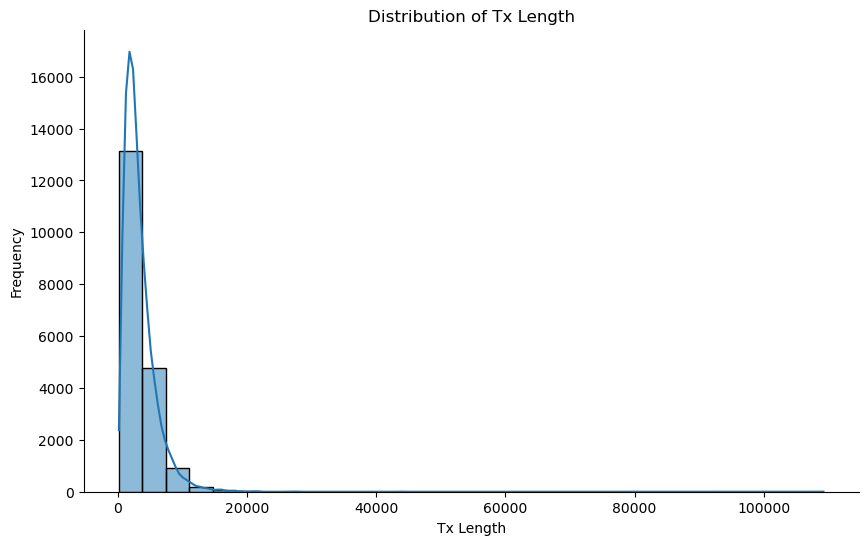

In [102]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.histplot(gene_only_df['Tx Length'], kde=True, bins=30)  # 'kde=True' adds a Kernel Density Estimate plot
sns.despine(top=True, right=True)
plt.title('Distribution of Tx Length')
plt.xlabel('Tx Length')
plt.ylabel('Frequency')
plt.show()

# Transcript length

Histogram shows there are a few outliers, but hard to quantify. Go to a boxplot

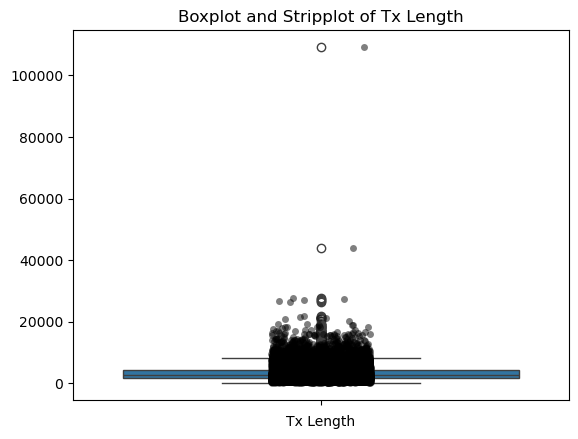

In [103]:
# Create a boxplot
sns.boxplot(data=gene_only_df, y='Tx Length')

# Create a stripplot
sns.stripplot(data=gene_only_df, y='Tx Length', color='black', alpha=0.5)

# Set plot title and labels
plt.title('Boxplot and Stripplot of Tx Length')
plt.xlabel('Tx Length')
plt.ylabel('')

# Show the plot
plt.show()

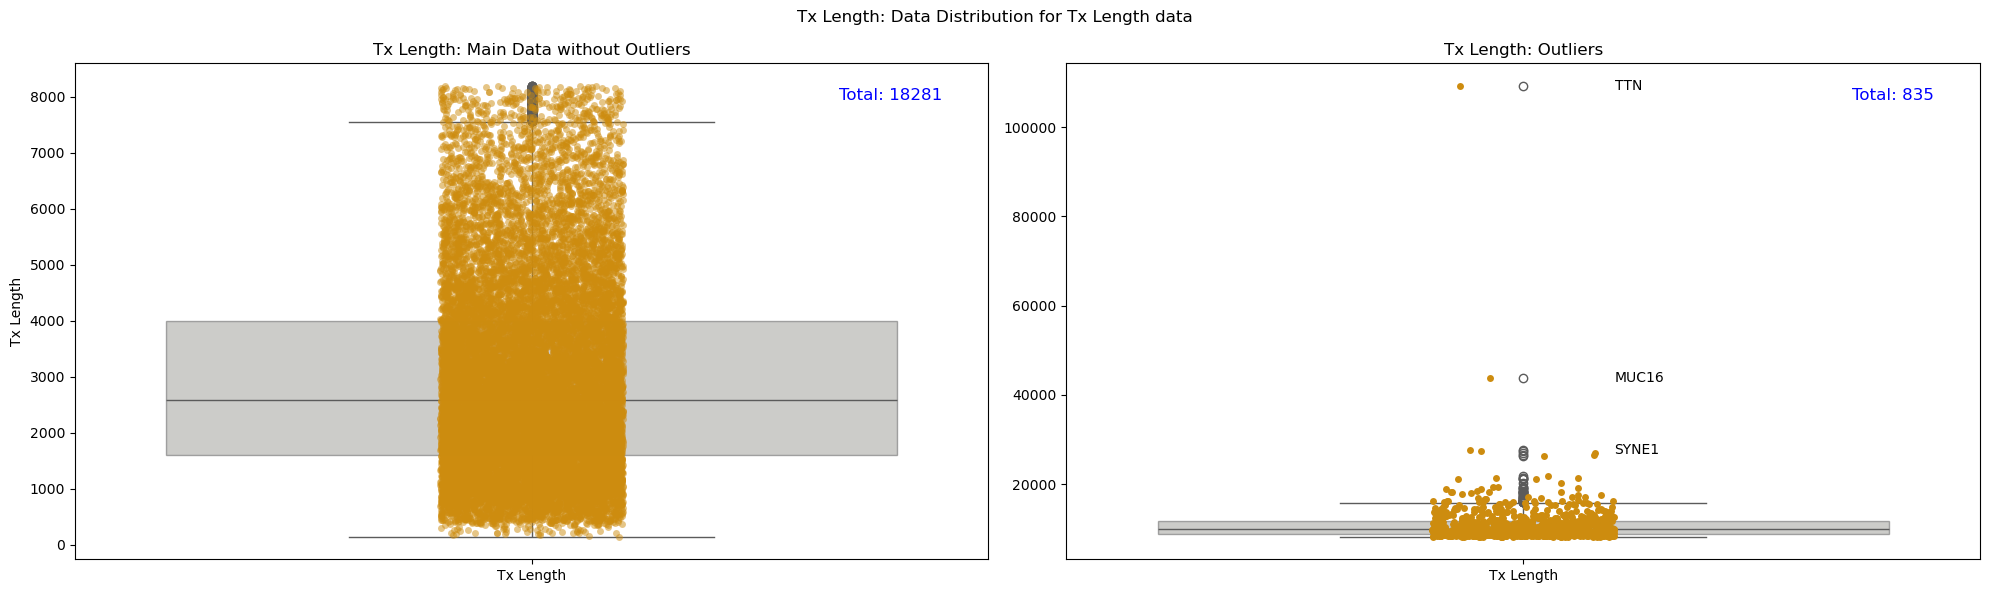

In [104]:
col='Tx Length'
fig = box_strip_plot(gene_only_df, 'Tx Length', 'Data Distribution for Tx Length data', 'Tx Length')
plt.tight_layout()
plt.show()

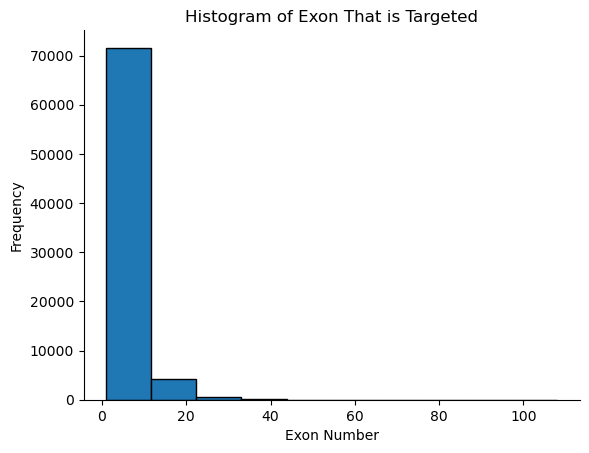

In [105]:
# Exon number
# Note: this is a per guide measuer as it is the exon that is targeted. 
hist_fig=plot_hist(guide_df, 'Target Exon', 10, 'Histogram of Exon That is Targeted', 'Exon Number')
sns.despine(right=True, top=True)
# Display the plot
plt.show()

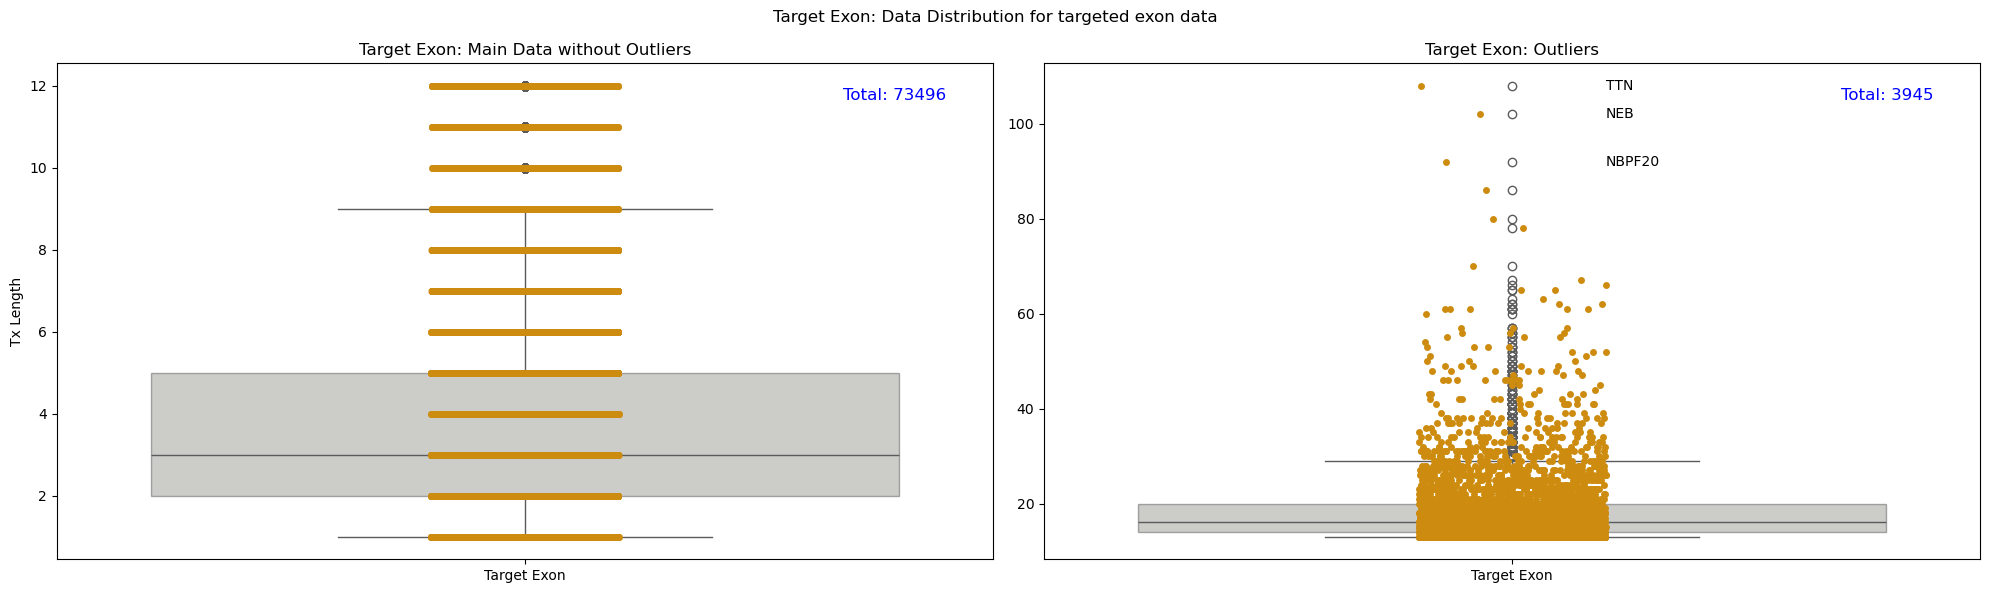

In [106]:
col='Exon Number'
fig = box_strip_plot(guide_df, 'Target Exon', 'Data Distribution for targeted exon data', 'Tx Length')
plt.tight_layout()
plt.show()

In [107]:
display(gene_only_df)

Target Gene ID Target Gene Symbol Target Transcript  Tx Length  \
0                   1               A1BG       NM_130786.3     1766.0   
1                   2                A2M       NM_000014.4     4678.0   
2                   9               NAT1       NM_000662.7     1821.0   
3                  10               NAT2       NM_000015.2     1317.0   
4                  12           SERPINA3       NM_001085.4     1629.0   
...               ...                ...               ...        ...   
19111       102724631             POTEB3       NM_207355.3     2136.0   
19112       102724862       LOC102724862    NM_001291463.1     2065.0   
19113       102724957       LOC102724957    NM_001293172.1      471.0   
19114       102800317   LOC400927-CSNK1E    NM_001289912.1     2997.0   
19115       104909134     MGC57346-CRHR1    NM_001256299.2     2712.0   

       Gene Isoform Count     Annotation  Gene Length    A375 mean  \
0                     1.0  Uncategorized       8310.0    51.445406   
1                     6.0  Uncategorized      48522.0     7.214316   
2                    16.0  Uncategorized      53223.0   214.403118   
3                     3.0  Uncategorized      14918.0    11.046498   
4                     5.0  Uncategorized      11663.0  1079.371017   
...                   ...            ...          ...          ...   
19111                16.0  Uncategorized      35099.0   358.969758   
19112                24.0  Uncategorized      10966.0     0.000000   
19113                 1.0  Uncategorized        471.0     1.064038   
19114                 1.0  Uncategorized     108225.0   358.969758   
19115                 6.0  Uncategorized     215483.0   358.969758   

       A375 median  A375 std_dev  LOEUF  
0        41.893863     32.394602  1.340  
1         2.056853     12.621402  0.765  
2       188.216225    121.047907  1.906  
3         2.205915     13.919940  1.938  
4         1.733226   2367.726258  1.516  
...            ...           ...    ...  
19111   285.511030    203.822522  0.300  
19112     0.000000      0.000000  1.000  
19113     0.000000      4.276752  1.000  
19114   285.511030    203.822522  0.588  
19115   285.511030    203.822522  0.760  

[19116 rows x 11 columns]

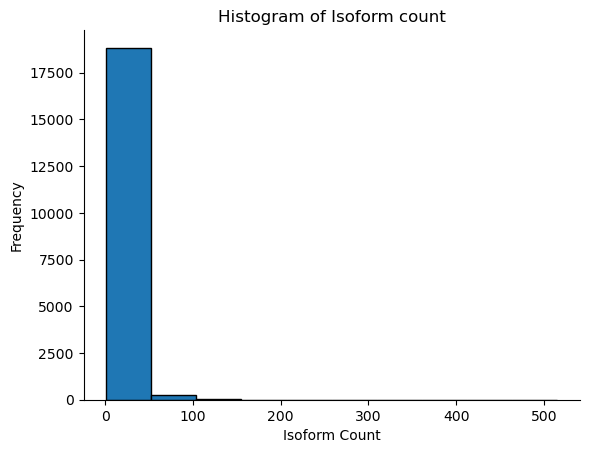

In [108]:
# Isoform number
hist_fig=plot_hist(gene_only_df, 'Gene Isoform Count', 10, 'Histogram of Isoform count', 'Isoform Count')
sns.despine(top=True, right=True)
# Display the plot
plt.show()

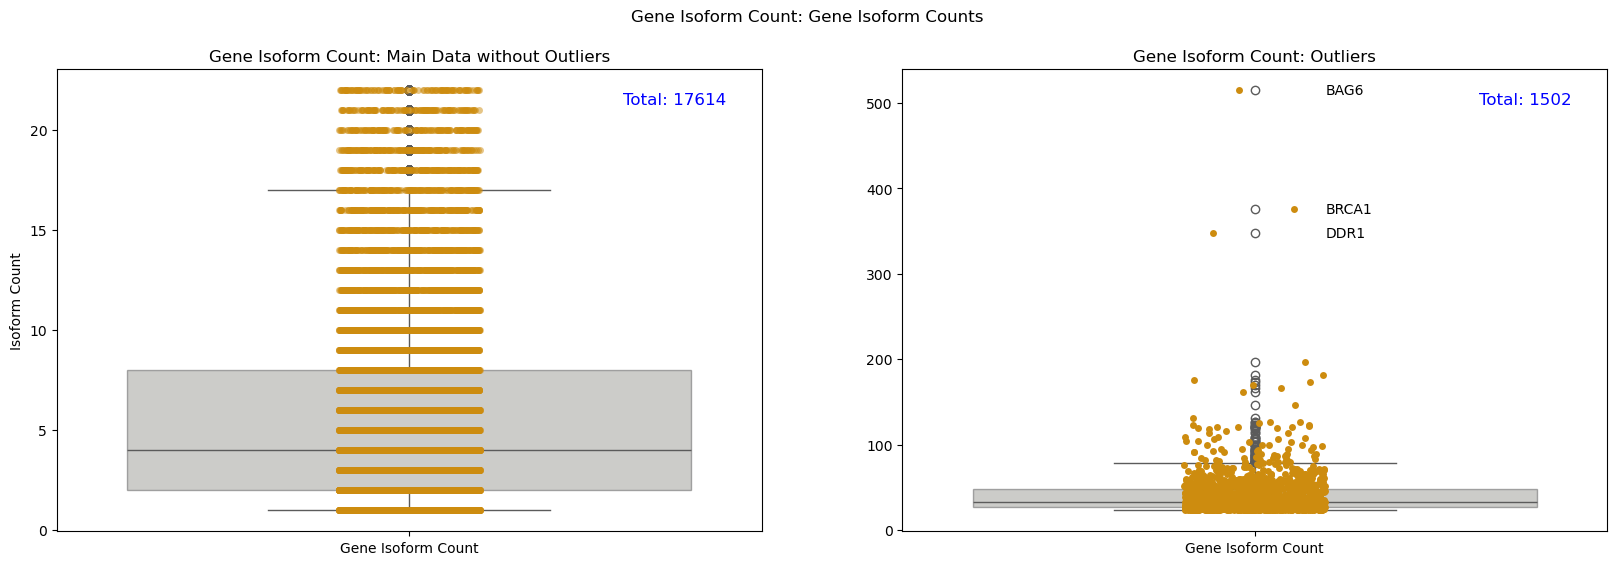

In [109]:
fig=box_strip_plot(gene_only_df, 'Gene Isoform Count', 'Gene Isoform Counts', 'Isoform Count')
plt.show()

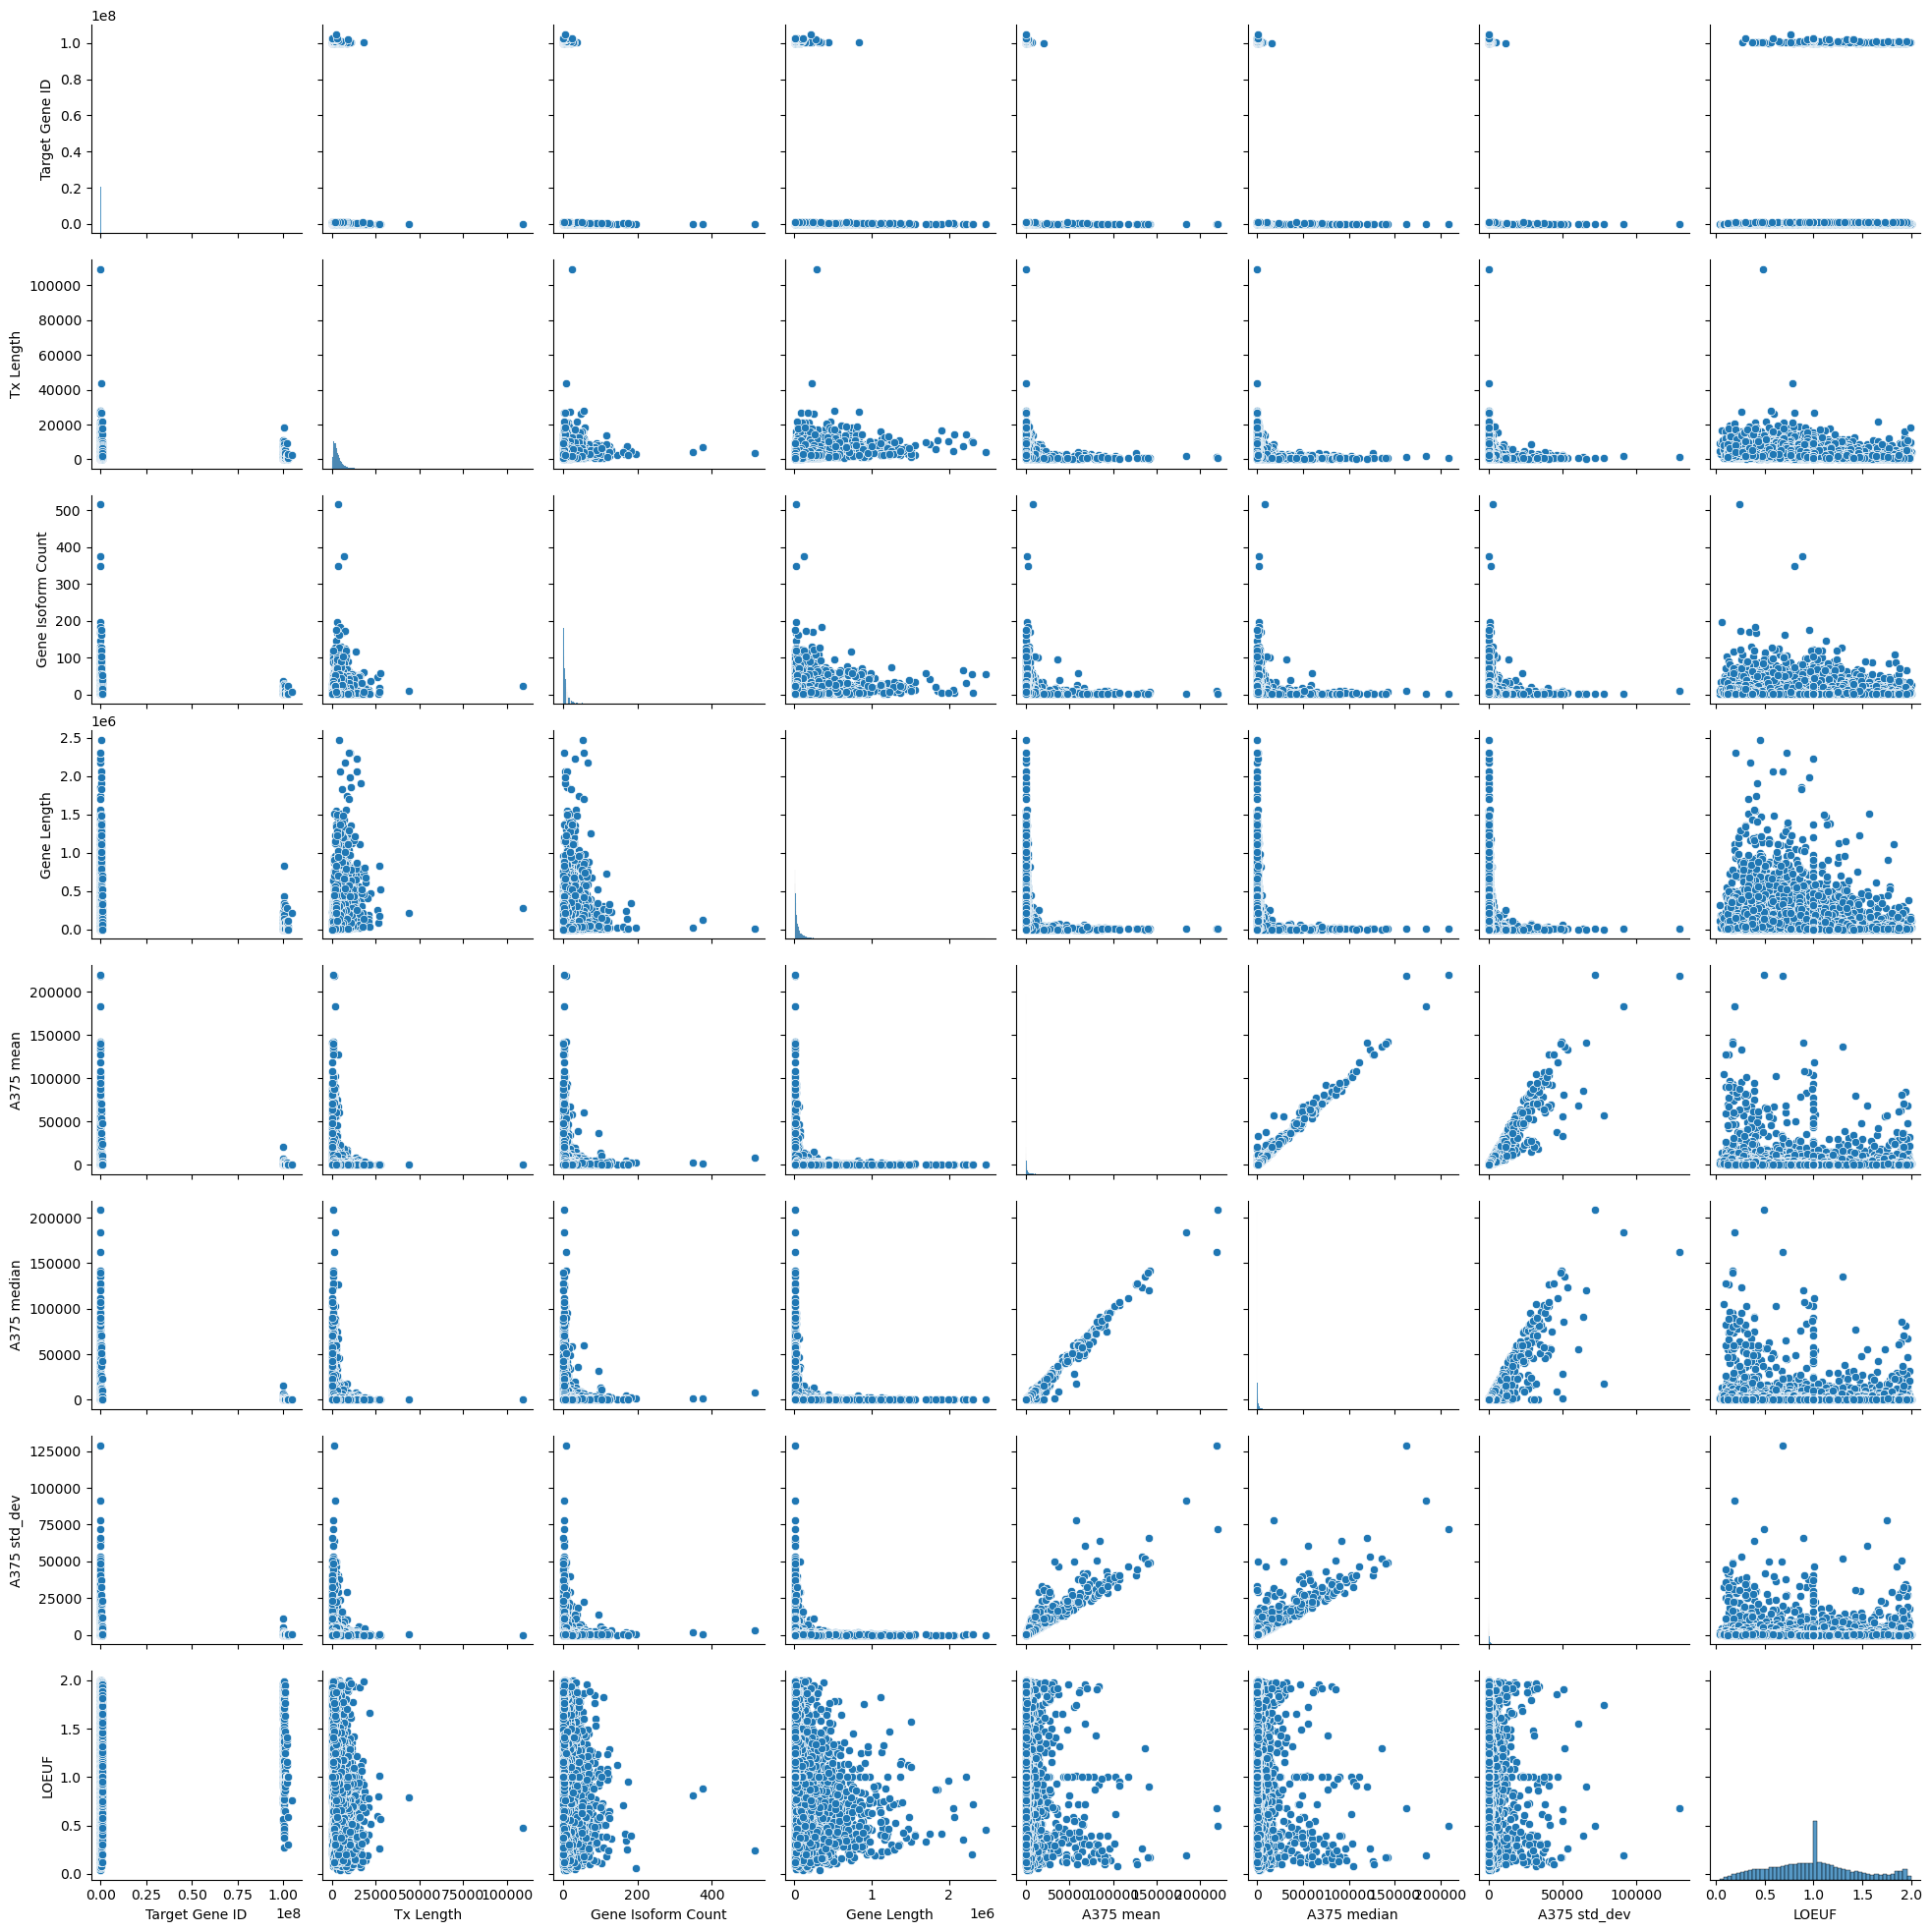

In [110]:
import seaborn as sns

sns.pairplot(gene_only_df)

# Merge Data
 
Lots of plots below need guide info as well. Merge gene_tx_df back into guide_df

In [111]:
print(guide_df.shape)
# Merge gene_tx_df back into guide_df on 'Target Gene Symbol' with a left join
merged_guide_df = guide_df.merge(gene_tx_df, on='Target Gene Symbol', how='left')
print(merged_guide_df.shape)
# Display the first few rows of the merged dataframe
show(merged_guide_df.head())


(77441, 11)
(77449, 21)


In [112]:
columns_to_drop = [col for col in merged_guide_df.columns if col.endswith('_y')]
merged_guide_df.drop(columns=columns_to_drop, inplace=True)
merged_guide_df.rename(columns={'Target Gene ID_x': 'Target Gene ID', 'Target Transcript_x': 'Target Transcript'}, inplace=True)
display(merged_guide_df.head())

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0               1               A1BG       NM_130786.3     NC_000019.10   
1               1               A1BG       NM_130786.3     NC_000019.10   
2               1               A1BG       NM_130786.3     NC_000019.10   
3               1               A1BG       NM_130786.3     NC_000019.10   
4               2                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Target Exon  Rule Set 2 score  \
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165   
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176   
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264   
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156   
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765   

   Tx Length  Gene Isoform Count     Annotation  Gene Length  A375 mean  \
0     1766.0                 1.0  Uncategorized       8310.0  51.445406   
1     1766.0                 1.0  Uncategorized       8310.0  51.445406   
2     1766.0                 1.0  Uncategorized       8310.0  51.445406   
3     1766.0                 1.0  Uncategorized       8310.0  51.445406   
4     4678.0                 6.0  Uncategorized      48522.0   7.214316   

   A375 median  A375 std_dev  LOEUF  
0    41.893863     32.394602  1.340  
1    41.893863     32.394602  1.340  
2    41.893863     32.394602  1.340  
3    41.893863     32.394602  1.340  
4     2.056853     12.621402  0.765

In [113]:
del guide_df
guide_df = merged_guide_df
del merged_guide_df
display(guide_df)

Target Gene ID     Target Gene Symbol Target Transcript  \
0                   1                   A1BG       NM_130786.3   
1                   1                   A1BG       NM_130786.3   
2                   1                   A1BG       NM_130786.3   
3                   1                   A1BG       NM_130786.3   
4                   2                    A2M       NM_000014.4   
...               ...                    ...               ...   
77444               0  Non-Targeting Control               NaN   
77445               0  Non-Targeting Control               NaN   
77446               0  Non-Targeting Control               NaN   
77447               0  Non-Targeting Control               NaN   
77448               0  Non-Targeting Control               NaN   

      Genomic Sequence  Position of Base After Cut (1-based)     Strand  \
0         NC_000019.10                            58351502.0      sense   
1         NC_000019.10                            58350637.0  antisense   
2         NC_000019.10                            58351668.0  antisense   
3         NC_000019.10                            58351593.0  antisense   
4         NC_000012.12                             9090399.0      sense   
...                ...                                   ...        ...   
77444              NaN                                   NaN        NaN   
77445              NaN                                   NaN        NaN   
77446              NaN                                   NaN        NaN   
77447              NaN                                   NaN        NaN   
77448              NaN                                   NaN        NaN   

      sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
0      CATCTTCTTTCACCTGAACG  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG   
1      CTCCGGGGAGAACTCCGGCG  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG   
2      TCTCCATGGTGCATCAGCAC  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG   
3      TGGAAGTCCACTCCACTCAG  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG   
4      ACTGCATCTGTGCAAACGGG  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG   
...                     ...                             ...          ...   
77444  TTTGGTCAACGCATAGCTTG                             NaN          NaN   
77445  TTTTACCTTGTTCACATGGA                             NaN          NaN   
77446  TTTTGACTCTAATCACCGGT                             NaN          NaN   
77447  TTTTTAATACAAGGTAATCT                             NaN          NaN   
77448  TTTTTCTCACCCGATGAATC                             NaN          NaN   

       Target Exon  Rule Set 2 score  Tx Length  Gene Isoform Count  \
0              5.0            0.6165     1766.0                 1.0   
1              6.0            0.6176     1766.0                 1.0   
2              5.0            0.5264     1766.0                 1.0   
3              5.0            0.7156     1766.0                 1.0   
4             20.0            0.6765     4678.0                 6.0   
...            ...               ...        ...                 ...   
77444          NaN               NaN        0.0                 0.0   
77445          NaN               NaN        0.0                 0.0   
77446          NaN               NaN        0.0                 0.0   
77447          NaN               NaN        0.0                 0.0   
77448          NaN               NaN        0.0                 0.0   

          Annotation  Gene Length   A375 mean  A375 median  A375 std_dev  \
0      Uncategorized       8310.0   51.445406    41.893863     32.394602   
1      Uncategorized       8310.0   51.445406    41.893863     32.394602   
2      Uncategorized       8310.0   51.445406    41.893863     32.394602   
3      Uncategorized       8310.0   51.445406    41.893863     32.394602   
4      Uncategorized      48522.0    7.214316     2.056853     12.621402   
...              ...          ...         ...          ...           ...   
77444  Uncatego

Target Gene ID Target Gene Symbol Target Transcript Genomic Sequence  \
0               1               A1BG       NM_130786.3     NC_000019.10   
1               1               A1BG       NM_130786.3     NC_000019.10   
2               1               A1BG       NM_130786.3     NC_000019.10   
3               1               A1BG       NM_130786.3     NC_000019.10   
4               2                A2M       NM_000014.4     NC_000012.12   

   Position of Base After Cut (1-based)     Strand sgRNA Target Sequence  \
0                            58351502.0      sense  CATCTTCTTTCACCTGAACG   
1                            58350637.0  antisense  CTCCGGGGAGAACTCCGGCG   
2                            58351668.0  antisense  TCTCCATGGTGCATCAGCAC   
3                            58351593.0  antisense  TGGAAGTCCACTCCACTCAG   
4                             9090399.0      sense  ACTGCATCTGTGCAAACGGG   

          Target Context Sequence PAM Sequence  Target Exon  Rule Set 2 score  \
0  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG          5.0            0.6165   
1  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG          6.0            0.6176   
2  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG          5.0            0.5264   
3  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG          5.0            0.7156   
4  CCTCACTGCATCTGTGCAAACGGGCGGCAA          CGG         20.0            0.6765   

   Tx Length  Gene Isoform Count     Annotation  Gene Length  A375 mean  \
0     1766.0                 1.0  Uncategorized       8310.0  51.445406   
1     1766.0                 1.0  Uncategorized       8310.0  51.445406   
2     1766.0                 1.0  Uncategorized       8310.0  51.445406   
3     1766.0                 1.0  Uncategorized       8310.0  51.445406   
4     4678.0                 6.0  Uncategorized      48522.0   7.214316   

   A375 median  A375 std_dev  LOEUF  
0    41.893863     32.394602  1.340  
1    41.893863     32.394602  1.340  
2    41.893863     32.394602  1.340  
3    41.893863     32.394602  1.340  
4     2.056853     12.621402  0.765

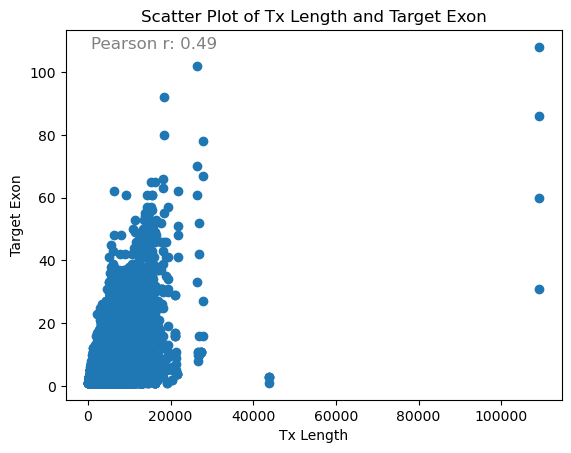

In [114]:
# Remove rows with NaN or inf values
cleaned_guide_df = guide_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Tx Length', 'Target Exon'])
display(cleaned_guide_df.head())
# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(cleaned_guide_df['Tx Length'], cleaned_guide_df['Target Exon'])
#Create scatter plot
plt.scatter(cleaned_guide_df['Tx Length'], cleaned_guide_df['Target Exon'])
plt.xlabel('Tx Length')
plt.ylabel('Target Exon')
plt.title('Scatter Plot of Tx Length and Target Exon')
# Annotate the Pearson correlation coefficient on the plot
plt.annotate(f'Pearson r: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='grey')

plt.show()

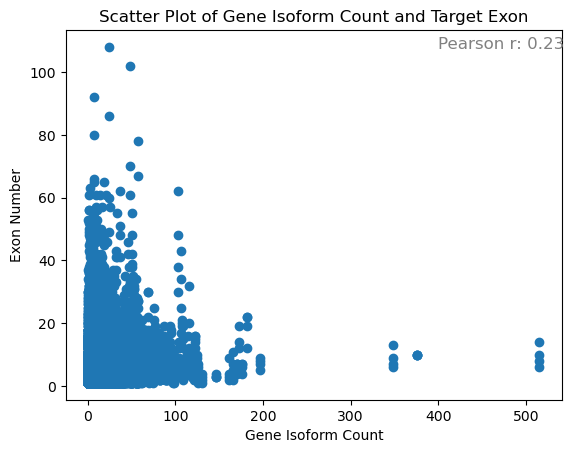

In [116]:
# Remove rows with NaN or inf values
cleaned_guide_df = guide_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Gene Isoform Count', 'Target Exon'])

# Calculate the Pearson correlation coefficient
corr, _ = pearsonr(cleaned_guide_df['Gene Isoform Count'], cleaned_guide_df['Target Exon'])
plt.scatter(guide_df['Gene Isoform Count'], guide_df['Target Exon'])
plt.xlabel('Gene Isoform Count')
plt.ylabel('Exon Number')
plt.title('Scatter Plot of Gene Isoform Count and Target Exon')
# Annotate the Pearson correlation coefficient on the plot
plt.annotate(f'Pearson r: {corr:.2f}', xy=(0.75, 0.95), xycoords='axes fraction', fontsize=12, color='grey')
plt.show()

# Correlation between gene features

There is a stronger correlation transcript length and exon number (moderate) than between isoform count and exon number (low-moderate). 

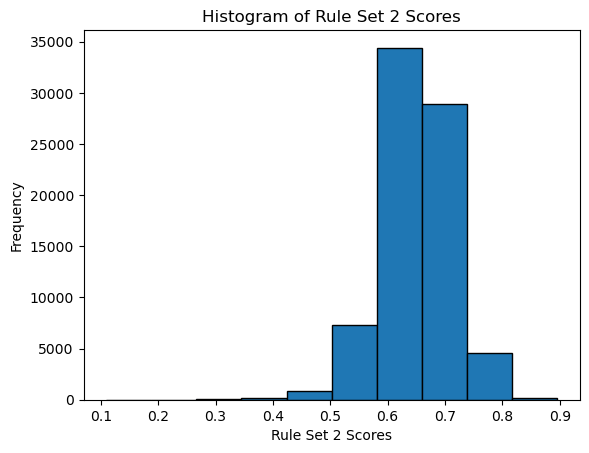

In [117]:
#Rule Set 2 score
#Note- this is a per guide measure- not a per gene measure

hist_fig=plot_hist(guide_df, 'Rule Set 2 score', 10, 'Histogram of Rule Set 2 Scores', 'Rule Set 2 Scores')
plt.show()

# Conclusion: Gene attributes

For many gene level attributes (e.g. isoform number and length) 

* the bulk of the data is in one bin, but there are a large number of outliers in each category.
* while there is certainly class imbalance- there may enough data to look at the impact of these features on guide behaviour- particularly when comparing to the non-targeting guides. 
* there are some correlations between these characteristics, but they are low to moderate. most things seem uncorrelated.

## Guide Counts

Now, let's look at the count data.

- [X] Plot the raw count distributions per sample
- [X] Normalize counts and plot distributions per sample. 

In [118]:
bru1_df=pd.read_excel(brunello, sheet_name=0, header=2)
show(bru1_df.head())

In [119]:
bru1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sgRNA Sequence  77441 non-null  object
 1   pDNA            77441 non-null  int64 
 2   RepA            77441 non-null  int64 
 3   RepB            77441 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.4+ MB


In [120]:
bru2_df=pd.read_excel(brunello, sheet_name=1, header=1)
show(bru2_df.head())

In [121]:
bru2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sgRNA Sequence  77441 non-null  object
 1   pDNA            77441 non-null  int64 
 2   RepA            77441 non-null  int64 
 3   RepB            77441 non-null  int64 
 4   RepC            77441 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.0+ MB


In [122]:
# Rename columns so you can put these all in one df
col1_dict={'pDNA': 'trac1_pDNA',
           'RepA': 'trac1_RepA',
           'RepB': 'trac1_RepB'}

col2_dict={'pDNA': 'trac2_pDNA',
           'RepA': 'trac2_RepA',
           'RepB': 'trac2_RepB',
           'RepC': 'trac2_RepC'}
bru1_df.rename(columns=col1_dict, inplace=True)
bru2_df.rename(columns=col2_dict, inplace=True)

show(bru1_df.head())
show(bru2_df.head())

In [123]:
brunello_df = bru1_df.merge(bru2_df, on='sgRNA Sequence')
show(brunello_df.head())

In [124]:
brunello_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sgRNA Sequence  77441 non-null  object
 1   trac1_pDNA      77441 non-null  int64 
 2   trac1_RepA      77441 non-null  int64 
 3   trac1_RepB      77441 non-null  int64 
 4   trac2_pDNA      77441 non-null  int64 
 5   trac2_RepA      77441 non-null  int64 
 6   trac2_RepB      77441 non-null  int64 
 7   trac2_RepC      77441 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 4.7+ MB


In [125]:
brunello_df.describe()

trac1_pDNA    trac1_RepA    trac1_RepB    trac2_pDNA    trac2_RepA  \
count  77441.000000  77441.000000  77441.000000  77441.000000  77441.000000   
mean     389.921385   1004.978732    953.183314    111.247156    815.889361   
std      204.905458    740.151161    699.222670     71.619809    764.315293   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      230.000000    472.000000    449.000000     60.000000    304.000000   
50%      341.000000    831.000000    792.000000     92.000000    609.000000   
75%      522.000000   1368.000000   1296.000000    145.000000   1090.000000   
max     1395.000000  11468.000000  14672.000000   1005.000000  16451.000000   

         trac2_RepB    trac2_RepC  
count  77441.000000  77441.000000  
mean     895.628453    807.693186  
std      839.403726    773.767215  
min        0.000000      0.000000  
25%      331.000000    279.000000  
50%      669.000000    596.000000  
75%     1205.000000   1099.000000  
max    17113.000000  18192.000000

In [126]:
# clean house
del(bru1_df)
del(bru2_df)

In [127]:
cols=['trac1_pDNA', 'trac1_RepA', 'trac1_RepB', 'trac2_pDNA', 'trac2_RepA', 'trac2_RepB', 'trac2_RepC']
#for col in cols:
#    total_counts = brunello_df[col].sum()
#    normalized_col_name = col + '_CPM'  # Create a new column name for the normalized data
#    brunello_df[normalized_col_name] = (brunello_df[col] / total_counts) * 1_000_000

for col in cols:
    brunello_norm_df=cal_cpm(brunello_df, col)

del brunello_df

show(brunello_norm_df)

In [128]:
brunello_norm_df.describe()

trac1_pDNA    trac1_RepA    trac1_RepB    trac2_pDNA    trac2_RepA  \
count  77441.000000  77441.000000  77441.000000  77441.000000  77441.000000   
mean     389.921385   1004.978732    953.183314    111.247156    815.889361   
std      204.905458    740.151161    699.222670     71.619809    764.315293   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      230.000000    472.000000    449.000000     60.000000    304.000000   
50%      341.000000    831.000000    792.000000     92.000000    609.000000   
75%      522.000000   1368.000000   1296.000000    145.000000   1090.000000   
max     1395.000000  11468.000000  14672.000000   1005.000000  16451.000000   

         trac2_RepB    trac2_RepC  trac1_pDNA_CPM  trac1_RepA_CPM  \
count  77441.000000  77441.000000    77441.000000    77441.000000   
mean     895.628453    807.693186       12.913056       12.913056   
std      839.403726    773.767215        6.785870        9.510265   
min        0.000000      0.000000        0.000000        0.000000   
25%      331.000000    279.000000        7.616928        6.064768   
50%      669.000000    596.000000       11.292923       10.677589   
75%     1205.000000   1099.000000       17.287114       17.577547   
max    17113.000000  18192.000000       46.198322      147.353298   

       trac1_RepB_CPM  trac2_pDNA_CPM  trac2_RepA_CPM  trac2_RepB_CPM  \
count    77441.000000    77441.000000    77441.000000    77441.000000   
mean        12.913056       12.913056       12.913056       12.913056   
std          9.472576        8.313297       12.096795       12.102415   
min          0.000000        0.000000        0.000000        0.000000   
25%          6.082736        6.964523        4.811399        4.772316   
50%         10.729458       10.678935        9.638625        9.645556   
75%         17.557295       16.830931       17.251397       17.373536   
max        198.765925      116.655761      260.369483      246.733044   

       trac2_RepC_CPM  
count    77441.000000  
mean        12.913056  
std         12.370662  
min          0.000000  
25%          4.460534  
50%          9.528595  
75%         17.570346  
max        290.845987

In [129]:
brunello_norm_df.isnull().sum()

sgRNA Sequence    0
trac1_pDNA        0
trac1_RepA        0
trac1_RepB        0
trac2_pDNA        0
trac2_RepA        0
trac2_RepB        0
trac2_RepC        0
trac1_pDNA_CPM    0
trac1_RepA_CPM    0
trac1_RepB_CPM    0
trac2_pDNA_CPM    0
trac2_RepA_CPM    0
trac2_RepB_CPM    0
trac2_RepC_CPM    0
dtype: int64

In [130]:
brunello_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77441 entries, 0 to 77440
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sgRNA Sequence  77441 non-null  object 
 1   trac1_pDNA      77441 non-null  int64  
 2   trac1_RepA      77441 non-null  int64  
 3   trac1_RepB      77441 non-null  int64  
 4   trac2_pDNA      77441 non-null  int64  
 5   trac2_RepA      77441 non-null  int64  
 6   trac2_RepB      77441 non-null  int64  
 7   trac2_RepC      77441 non-null  int64  
 8   trac1_pDNA_CPM  77441 non-null  float64
 9   trac1_RepA_CPM  77441 non-null  float64
 10  trac1_RepB_CPM  77441 non-null  float64
 11  trac2_pDNA_CPM  77441 non-null  float64
 12  trac2_RepA_CPM  77441 non-null  float64
 13  trac2_RepB_CPM  77441 non-null  float64
 14  trac2_RepC_CPM  77441 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 8.9+ MB


In [131]:
brunello_norm_gene_df=brunello_norm_df.merge(guide_df, left_on='sgRNA Sequence', right_on='sgRNA Target Sequence', how="left")
show(brunello_norm_gene_df.head())

In [132]:
brunello_norm_gene_df[brunello_norm_gene_df['Target Gene ID']==29957]

sgRNA Sequence  trac1_pDNA  trac1_RepA  trac1_RepB  trac2_pDNA  \
0      AAAAAAAATCCGGACAATGG         522         729         774         247   
27142  CCAGGCACTGGACCGCAATG         663        1869        1789         174   
29336  CCGTCTGAAAATCATGATGC         640        1116        1203         136   
54701  GGTATCCGCTCGCTTTGGAG         635         837         537         200   

       trac2_RepA  trac2_RepB  trac2_RepC  trac1_pDNA_CPM  trac1_RepA_CPM  \
0             358        1146         623       17.287114        9.366982   
27142        2818        2942        2796       21.956622       24.014938   
29336         623         711         545       21.194929       14.339578   
54701         649         695         317       21.029344       10.754684   

       trac1_RepB_CPM  trac2_pDNA_CPM  trac2_RepA_CPM  trac2_RepB_CPM  \
0           10.485607       28.670620        5.666055       16.522881   
27142       24.236112       20.197117       44.600401       42.417379   
29336       16.297397       15.786252        9.860202       10.251107   
54701        7.274898       23.215077       10.271703       10.020421   

       trac2_RepC_CPM  Target Gene ID Target Gene Symbol Target Transcript  \
0            9.960260           29957           SLC25A24       NM_013386.4   
27142       44.701263           29957           SLC25A24       NM_013386.4   
29336        8.713229           29957           SLC25A24       NM_013386.4   
54701        5.068062           29957           SLC25A24       NM_013386.4   

      Genomic Sequence  Position of Base After Cut (1-based) Strand  \
0         NC_000001.11                           108157552.0  sense   
27142     NC_000001.11                           108200039.0  sense   
29336     NC_000001.11                           108157467.0  sense   
54701     NC_000001.11                           108155053.0  sense   

      sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
0      AAAAAAAATCCGGACAATGG  GACGAAAAAAAATCCGGACAATGGTGGAGG          TGG   
27142  CCAGGCACTGGACCGCAATG  TCTTCCAGGCACTGGACCGCAATGGGGACG          GGG   
29336  CCGTCTGAAAATCATGATGC  TGGACCGTCTGAAAATCATGATGCAGGTGA          AGG   
54701  GGTATCCGCTCGCTTTGGAG  AGGAGGTATCCGCTCGCTTTGGAGGGGAAA          GGG   

       Target Exon  Rule Set 2 score  Tx Length  Gene Isoform Count  \
0              5.0            0.6034     3600.0                 5.0   
27142          1.0            0.6626     3600.0                 5.0   
29336          5.0            0.5933     3600.0                 5.0   
54701          6.0            0.6107     3600.0                 5.0   

          Annotation  Gene Length    A375 mean  A375 median  A375 std_dev  \
0      Uncategorized      66301.0  2207.880284  2068.753495    975.948525   
27142  Uncategorized      66301.0  2207.880284  2068.753495    975.948525   
29336  Uncategorized      66301.0  2207.880284  2068.753495    975.948525   
54701  Uncategorized      66301.0  2207.880284  2068.753495    975.948525   

       LOEUF  
0      1.106  
27142  1.106  
29336  1.106  
54701  1.106

In [133]:
brunello_norm_gene_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77449 entries, 0 to 77448
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sgRNA Sequence                        77449 non-null  object 
 1   trac1_pDNA                            77449 non-null  int64  
 2   trac1_RepA                            77449 non-null  int64  
 3   trac1_RepB                            77449 non-null  int64  
 4   trac2_pDNA                            77449 non-null  int64  
 5   trac2_RepA                            77449 non-null  int64  
 6   trac2_RepB                            77449 non-null  int64  
 7   trac2_RepC                            77449 non-null  int64  
 8   trac1_pDNA_CPM                        77449 non-null  float64
 9   trac1_RepA_CPM                        77449 non-null  float64
 10  trac1_RepB_CPM                        77449 non-null  float64
 11  trac2_pDNA_CPM 

In [134]:
foo=brunello_norm_gene_df[brunello_norm_gene_df['Target Gene Symbol'].isnull()]
print(len(foo.index))

0


In [135]:
#Clean house
brunello_norm_df=brunello_norm_gene_df
del brunello_norm_gene_df
show(brunello_norm_df.head())

In [136]:
brunello_norm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77449 entries, 0 to 77448
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sgRNA Sequence                        77449 non-null  object 
 1   trac1_pDNA                            77449 non-null  int64  
 2   trac1_RepA                            77449 non-null  int64  
 3   trac1_RepB                            77449 non-null  int64  
 4   trac2_pDNA                            77449 non-null  int64  
 5   trac2_RepA                            77449 non-null  int64  
 6   trac2_RepB                            77449 non-null  int64  
 7   trac2_RepC                            77449 non-null  int64  
 8   trac1_pDNA_CPM                        77449 non-null  float64
 9   trac1_RepA_CPM                        77449 non-null  float64
 10  trac1_RepB_CPM                        77449 non-null  float64
 11  trac2_pDNA_CPM 

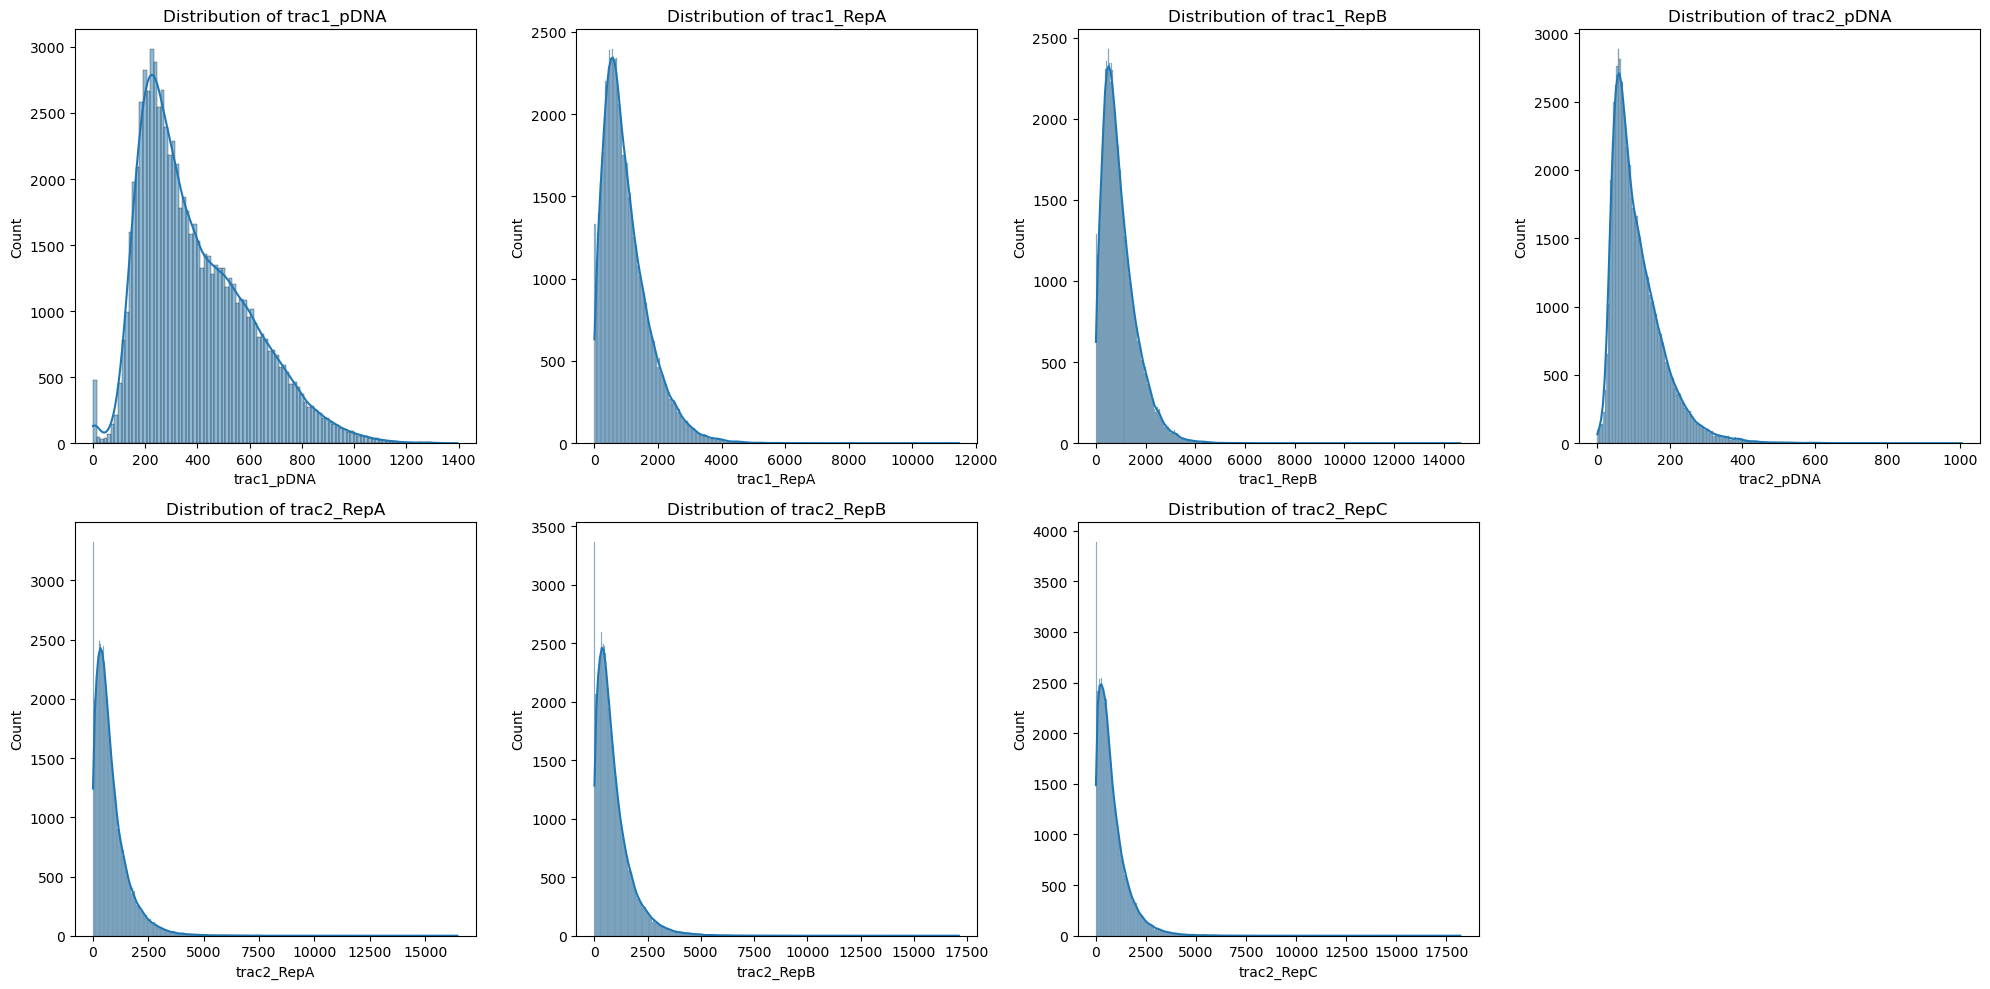

In [137]:
dist_plots(brunello_norm_df, cols)

plt.tight_layout()
plt.show()

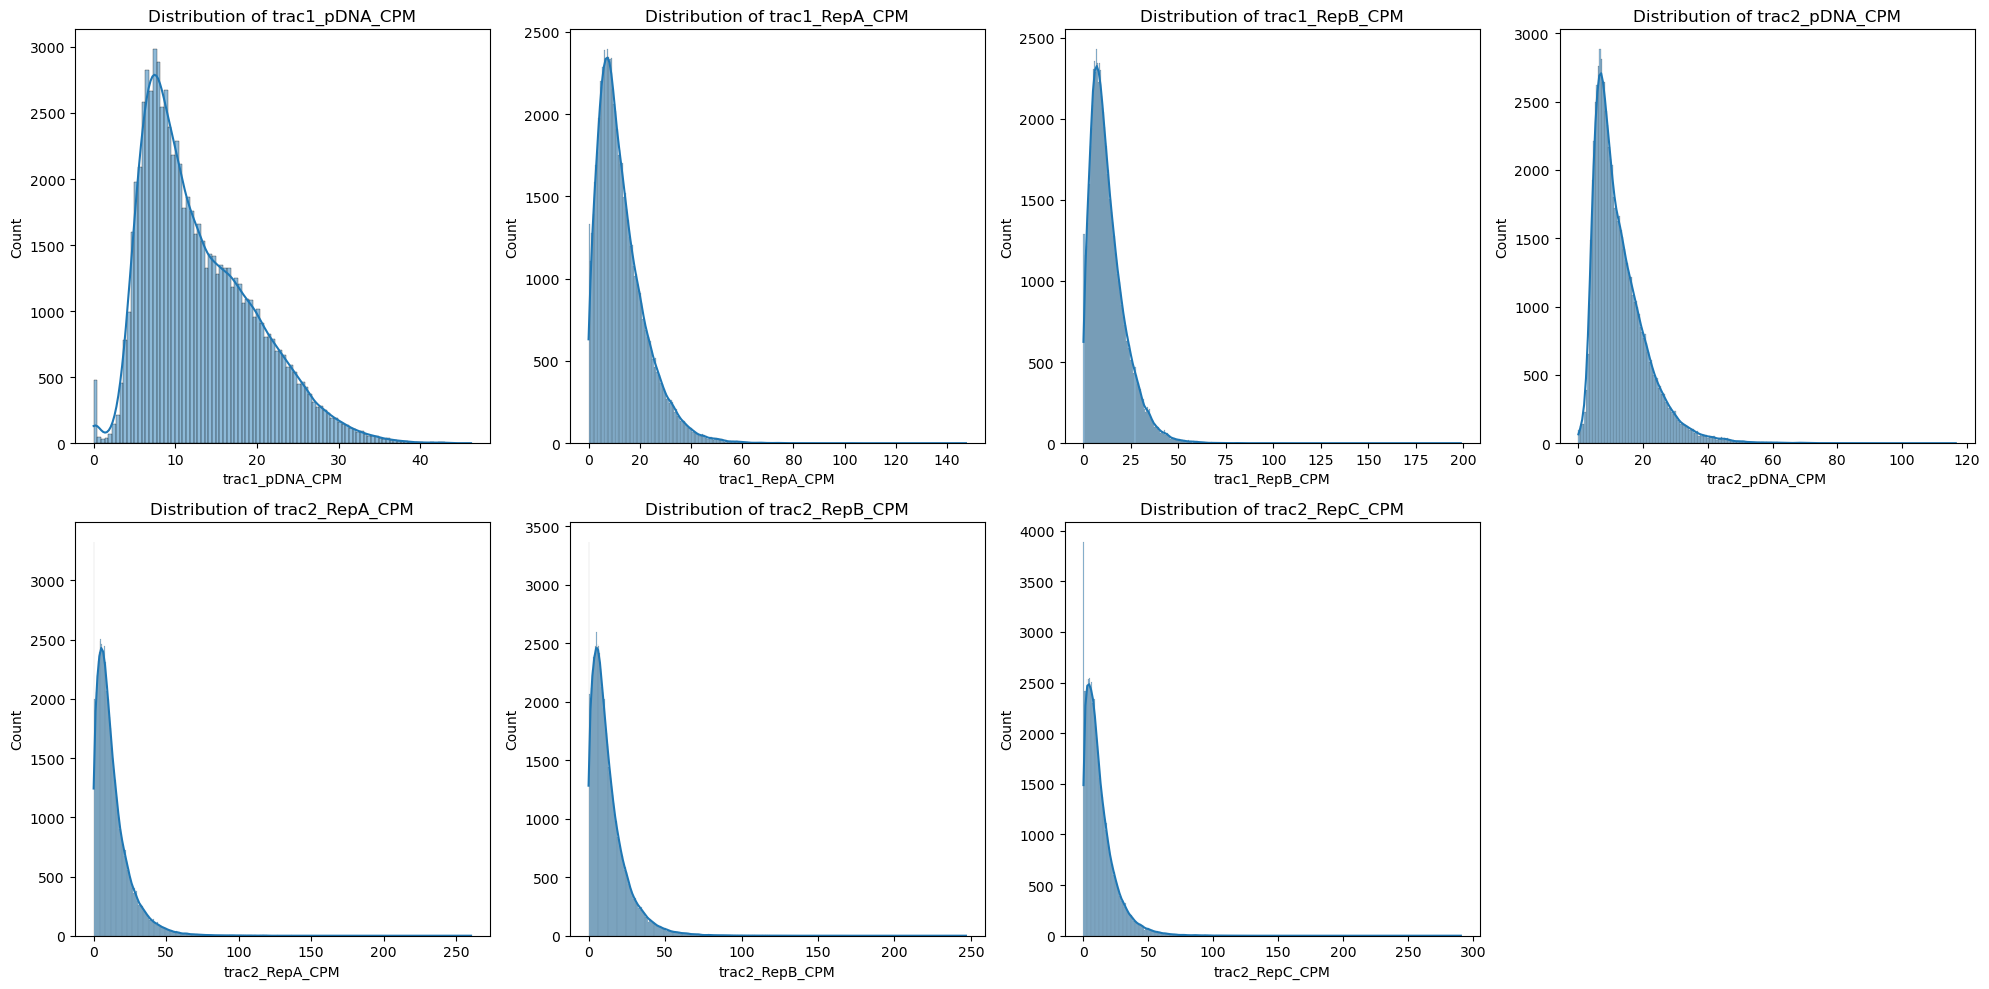

In [138]:
norm_cols=[col + '_CPM' for col in cols]
dist_plots(brunello_norm_df, norm_cols)
plt.tight_layout()
plt.show()

# Distributions

The distribution of the raw and the normalized counts look pretty similar. 

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


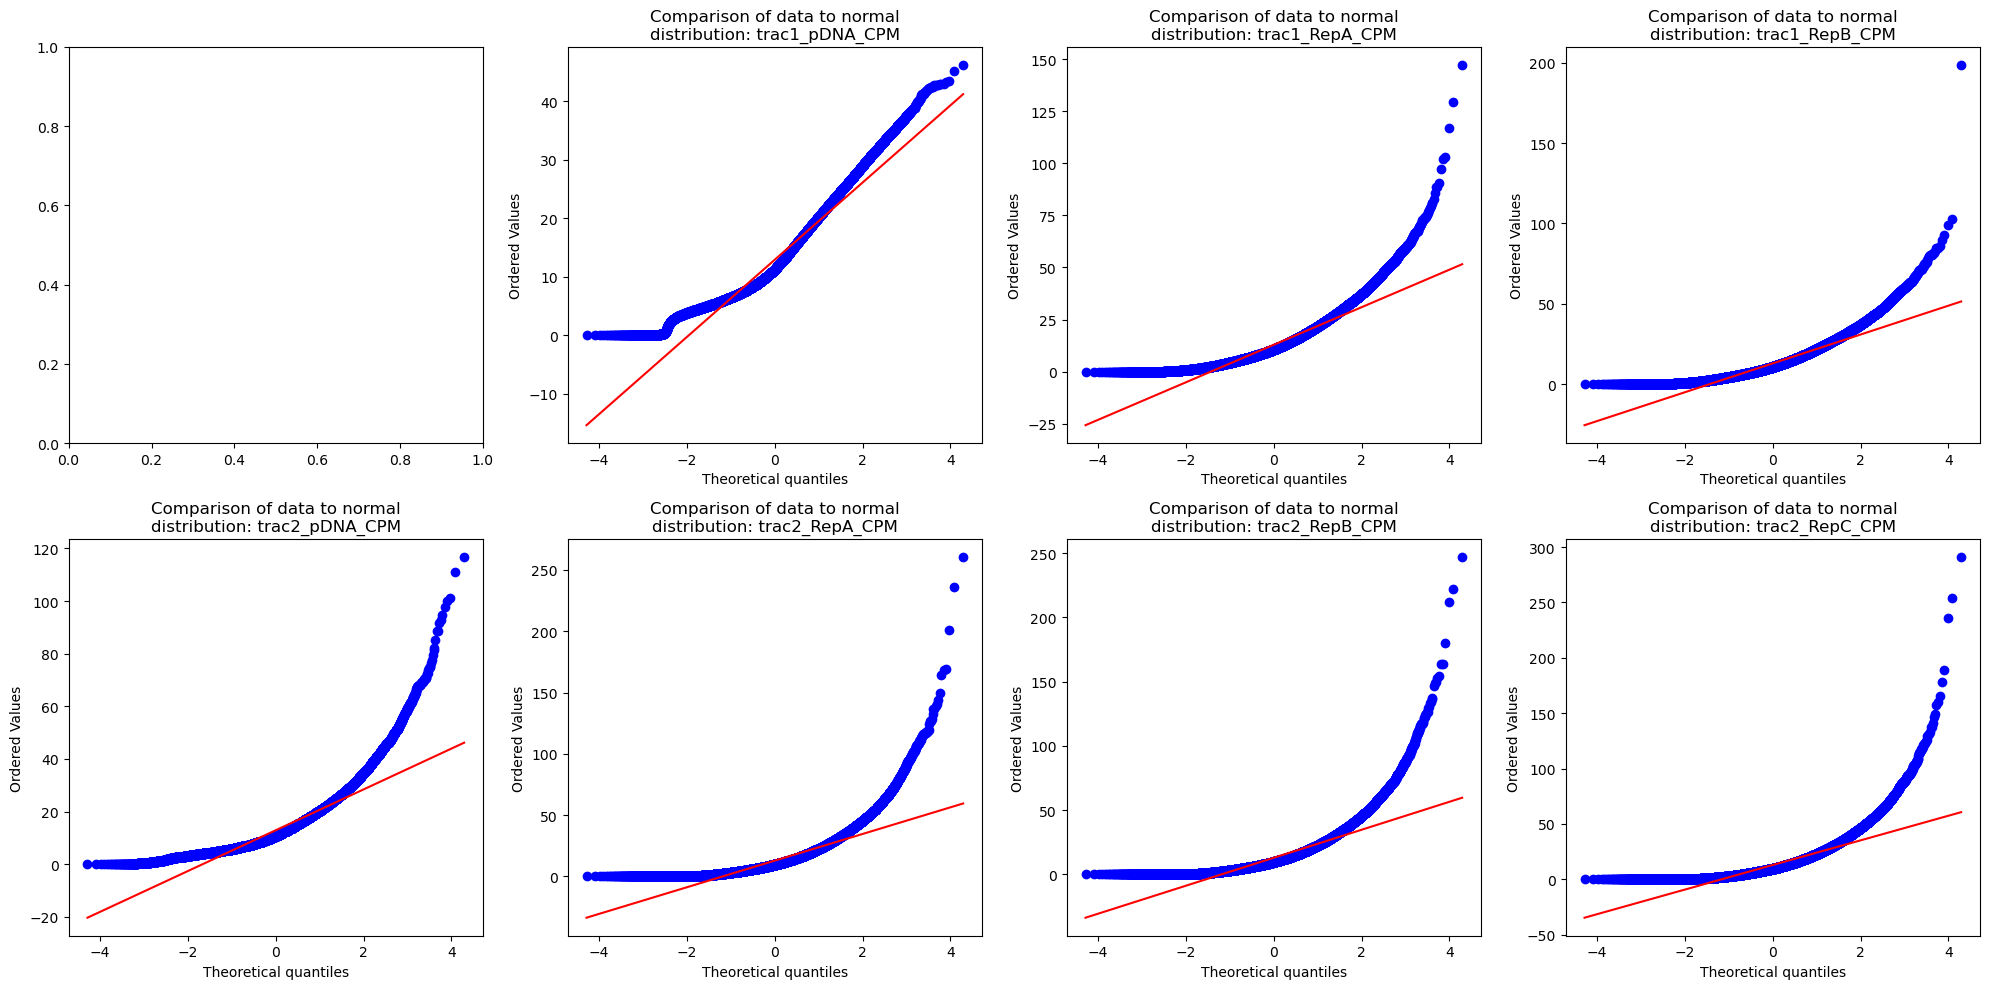

In [139]:
q_q_plots(brunello_norm_df, "norm", norm_cols, "Comparison of data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


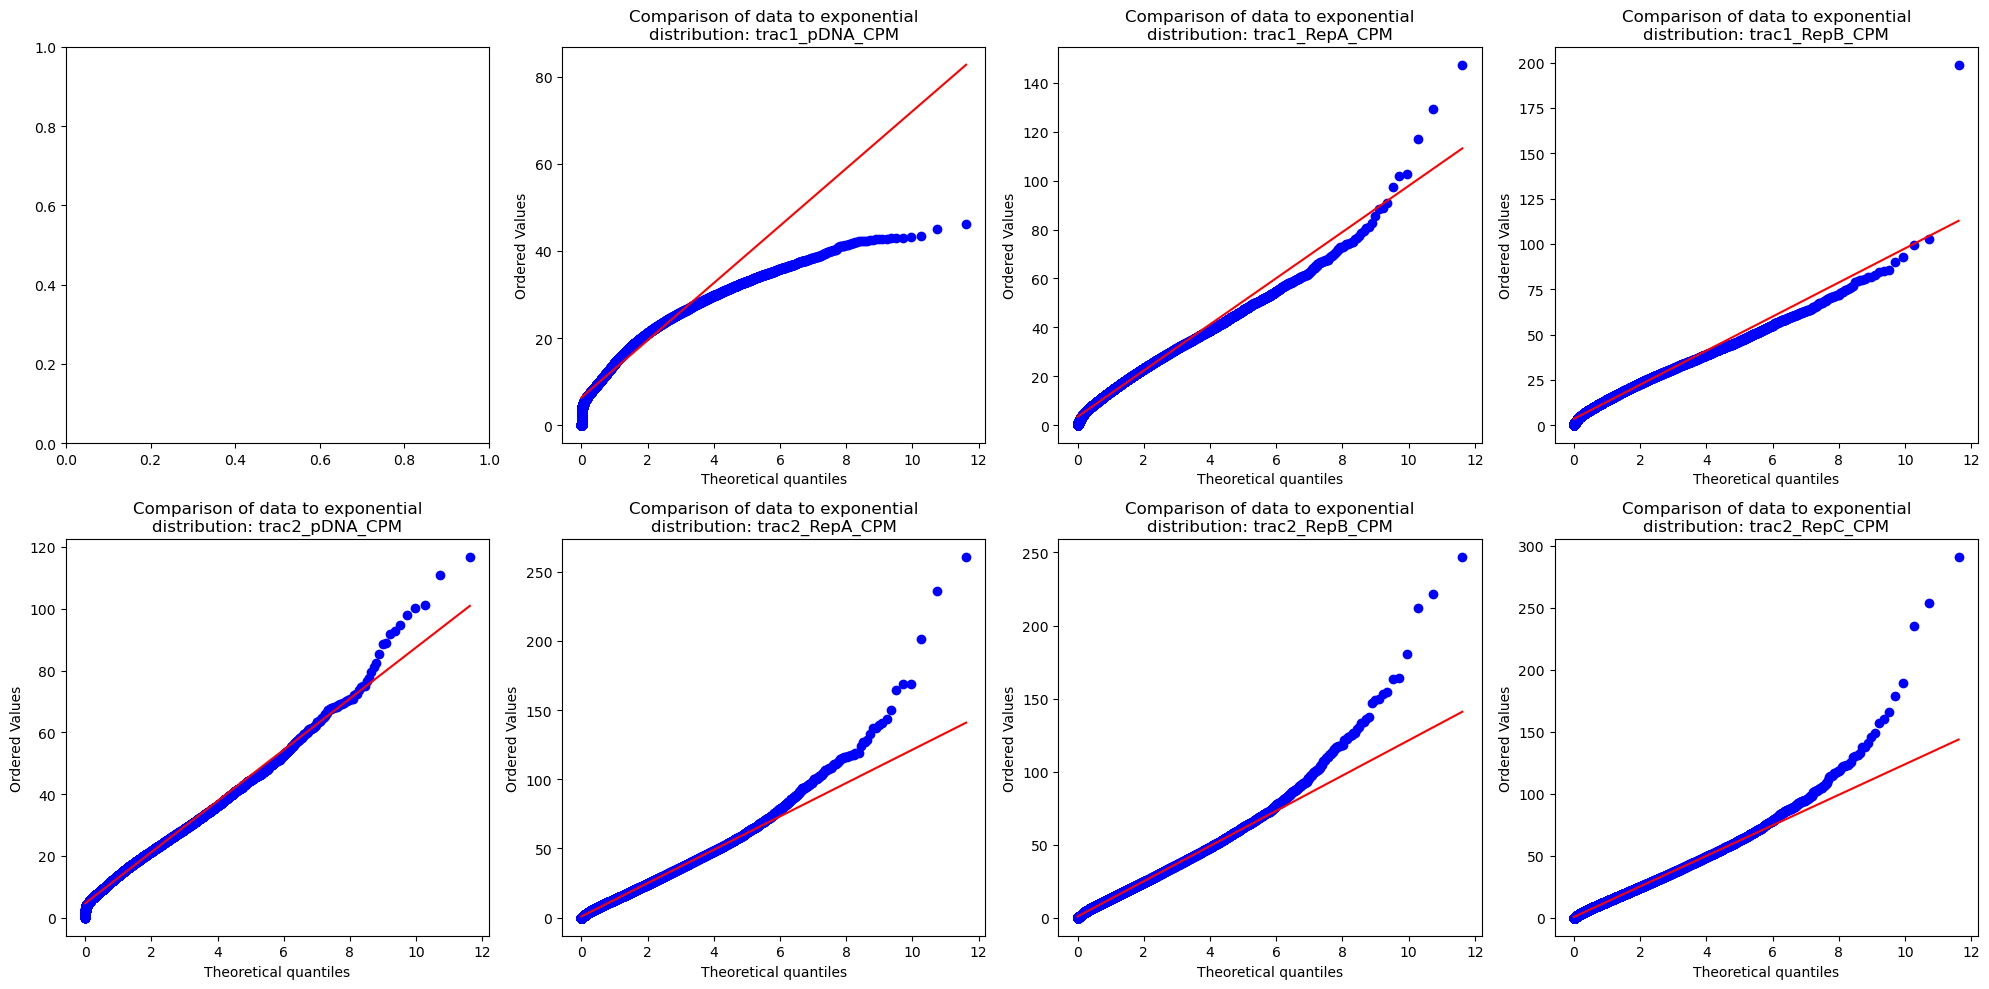

In [140]:
q_q_plots(brunello_norm_df, "expon", norm_cols, "Comparison of data to exponential distribution")
plt.tight_layout()
plt.show()

In [141]:
print(brunello_norm_df.columns)

Index(['sgRNA Sequence', 'trac1_pDNA', 'trac1_RepA', 'trac1_RepB',
       'trac2_pDNA', 'trac2_RepA', 'trac2_RepB', 'trac2_RepC',
       'trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM', 'trac2_pDNA_CPM',
       'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM', 'Target Gene ID',
       'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence',
       'Position of Base After Cut (1-based)', 'Strand',
       'sgRNA Target Sequence', 'Target Context Sequence', 'PAM Sequence',
       'Target Exon', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count',
       'Annotation', 'Gene Length', 'A375 mean', 'A375 median', 'A375 std_dev',
       'LOEUF'],
      dtype='object')


In [142]:
columns_to_keep = ['Target Gene Symbol'] + [col for col in brunello_norm_df.columns if col.startswith('trac')]
brunello_red_df = brunello_norm_df[columns_to_keep]
show(brunello_red_df.head())

In [143]:
combined_df = brunello_red_df.groupby('Target Gene Symbol').sum().reset_index()

In [144]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19115 entries, 0 to 19114
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Target Gene Symbol  19115 non-null  object 
 1   trac1_pDNA          19115 non-null  int64  
 2   trac1_RepA          19115 non-null  int64  
 3   trac1_RepB          19115 non-null  int64  
 4   trac2_pDNA          19115 non-null  int64  
 5   trac2_RepA          19115 non-null  int64  
 6   trac2_RepB          19115 non-null  int64  
 7   trac2_RepC          19115 non-null  int64  
 8   trac1_pDNA_CPM      19115 non-null  float64
 9   trac1_RepA_CPM      19115 non-null  float64
 10  trac1_RepB_CPM      19115 non-null  float64
 11  trac2_pDNA_CPM      19115 non-null  float64
 12  trac2_RepA_CPM      19115 non-null  float64
 13  trac2_RepB_CPM      19115 non-null  float64
 14  trac2_RepC_CPM      19115 non-null  float64
dtypes: float64(7), int64(7), object(1)
memory usage: 2.2+

In [145]:
show(combined_df.head())

In [146]:
##Double check that counts are right- they seem to be
brunello_norm_df[brunello_norm_df['Target Gene Symbol']=='A1BG']

sgRNA Sequence  trac1_pDNA  trac1_RepA  trac1_RepB  trac2_pDNA  \
25136  CATCTTCTTTCACCTGAACG         563        1670        1411         327   
34355  CTCCGGGGAGAACTCCGGCG         472        1144         774         120   
66230  TCTCCATGGTGCATCAGCAC           2           0           0           4   
70603  TGGAAGTCCACTCCACTCAG         674        1566        1678         165   

       trac2_RepA  trac2_RepB  trac2_RepC  trac1_pDNA_CPM  trac1_RepA_CPM  \
25136        1351        2055        1533       18.644914       21.457971   
34355        1196         982        1472       15.631260       14.699352   
66230           3           0           0        0.066234        0.000000   
70603        2287        2978        1812       22.320910       20.121666   

       trac1_RepB_CPM  trac2_pDNA_CPM  trac2_RepA_CPM  trac2_RepB_CPM  \
25136       19.115235       37.956651       21.382236       29.628727   
34355       10.485607       13.929046       18.929056       14.158350   
66230        0.000000        0.464302        0.047481        0.000000   
70603       22.732363       19.152438       36.196280       42.936423   

       trac2_RepC_CPM  Target Gene ID Target Gene Symbol Target Transcript  \
25136       24.508954               1               A1BG       NM_130786.3   
34355       23.533712               1               A1BG       NM_130786.3   
66230        0.000000               1               A1BG       NM_130786.3   
70603       28.969488               1               A1BG       NM_130786.3   

      Genomic Sequence  Position of Base After Cut (1-based)     Strand  \
25136     NC_000019.10                            58351502.0      sense   
34355     NC_000019.10                            58350637.0  antisense   
66230     NC_000019.10                            58351668.0  antisense   
70603     NC_000019.10                            58351593.0  antisense   

      sgRNA Target Sequence         Target Context Sequence PAM Sequence  \
25136  CATCTTCTTTCACCTGAACG  ATCGCATCTTCTTTCACCTGAACGCGGTGG          CGG   
34355  CTCCGGGGAGAACTCCGGCG  CCGGCTCCGGGGAGAACTCCGGCGCGGGCA          CGG   
66230  TCTCCATGGTGCATCAGCAC  GGACTCTCCATGGTGCATCAGCACAGGCGG          AGG   
70603  TGGAAGTCCACTCCACTCAG  TAGCTGGAAGTCCACTCCACTCAGGGGAGC          GGG   

       Target Exon  Rule Set 2 score  Tx Length  Gene Isoform Count  \
25136          5.0            0.6165     1766.0                 1.0   
34355          6.0            0.6176     1766.0                 1.0   
66230          5.0            0.5264     1766.0                 1.0   
70603          5.0            0.7156     1766.0                 1.0   

          Annotation  Gene Length  A375 mean  A375 median  A375 std_dev  LOEUF  
25136  Uncategorized       8310.0  51.445406    41.893863     32.394602   1.34  
34355  Uncategorized       8310.0  51.445406    41.893863     32.394602   1.34  
66230  Uncategorized       8310.0  51.445406    41.893863     32.394602   1.34  
70603  Uncategorized       8310.0  51.445406    41.893863     32.394602   1.34

In [160]:
brunello_norm_df.to_csv('../data/processed/brunello_normed_data.csv', index=False)

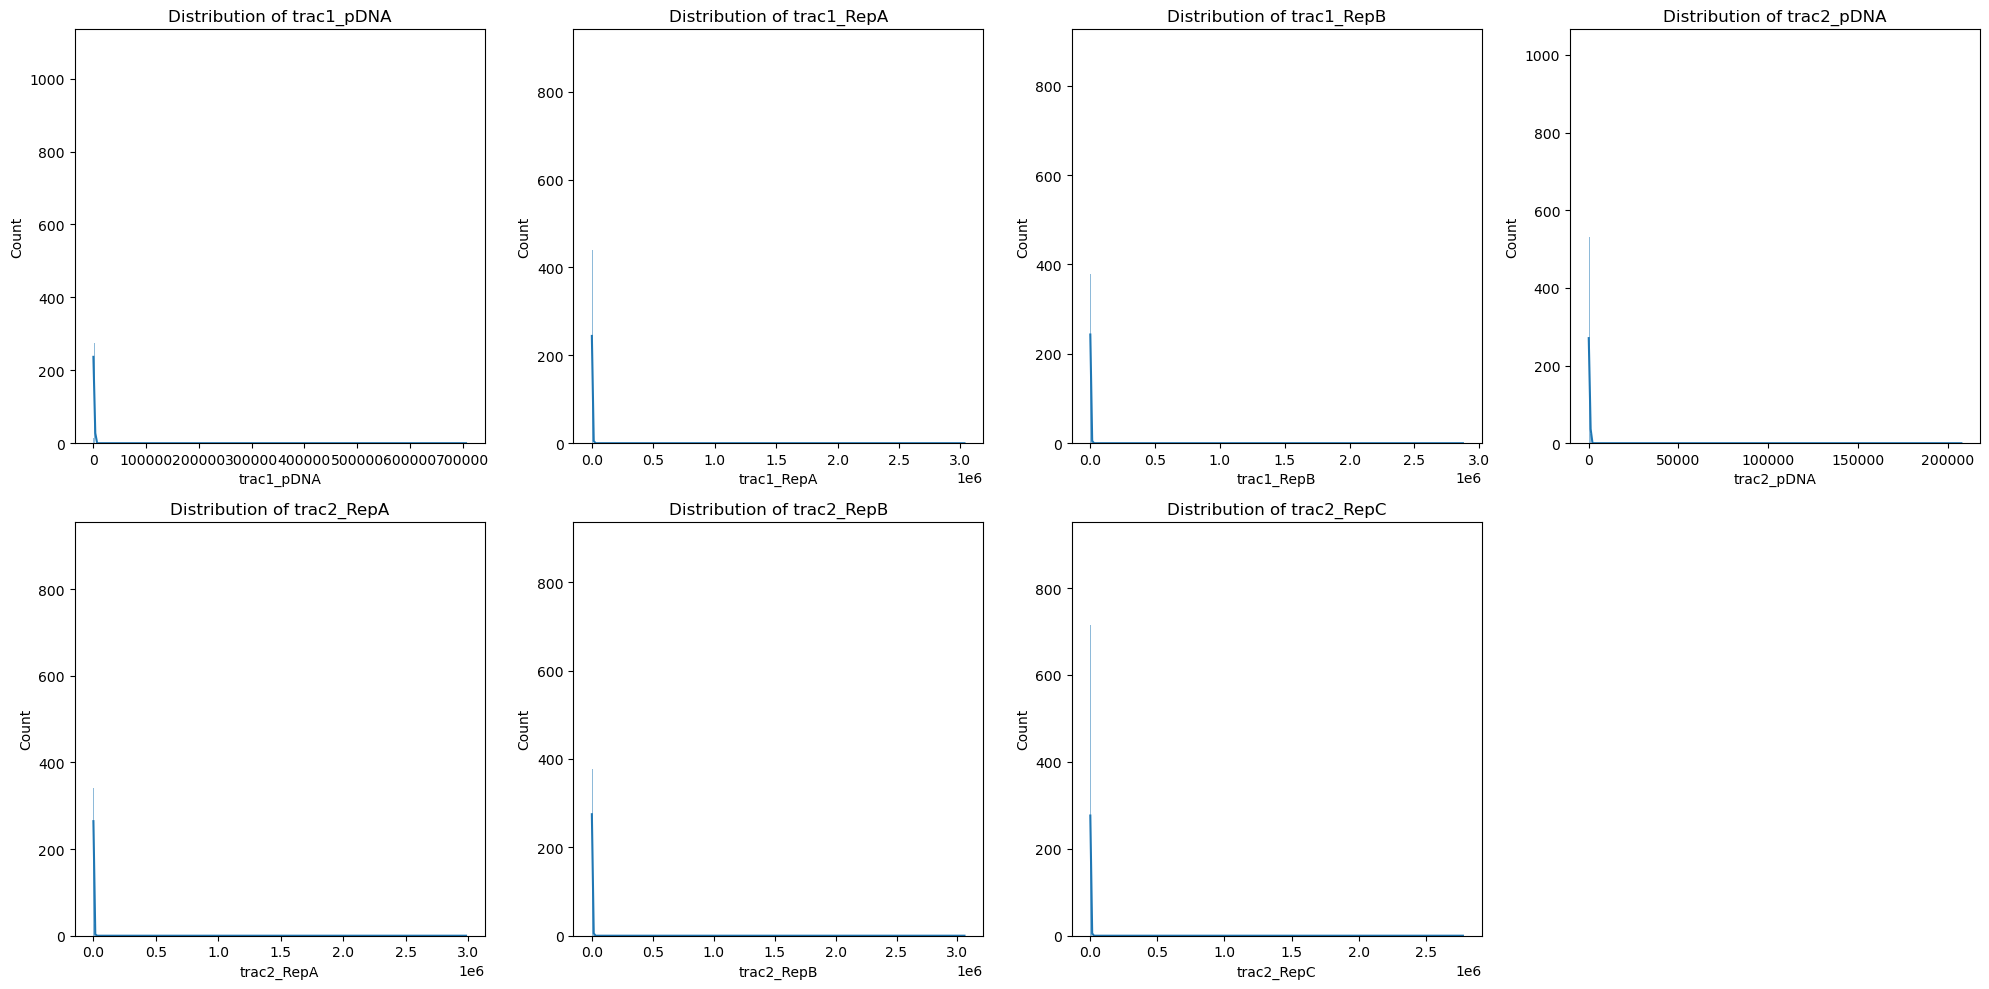

In [147]:
#Now do dist plots by gene

dist_plots(combined_df, cols)

plt.tight_layout()
plt.show()

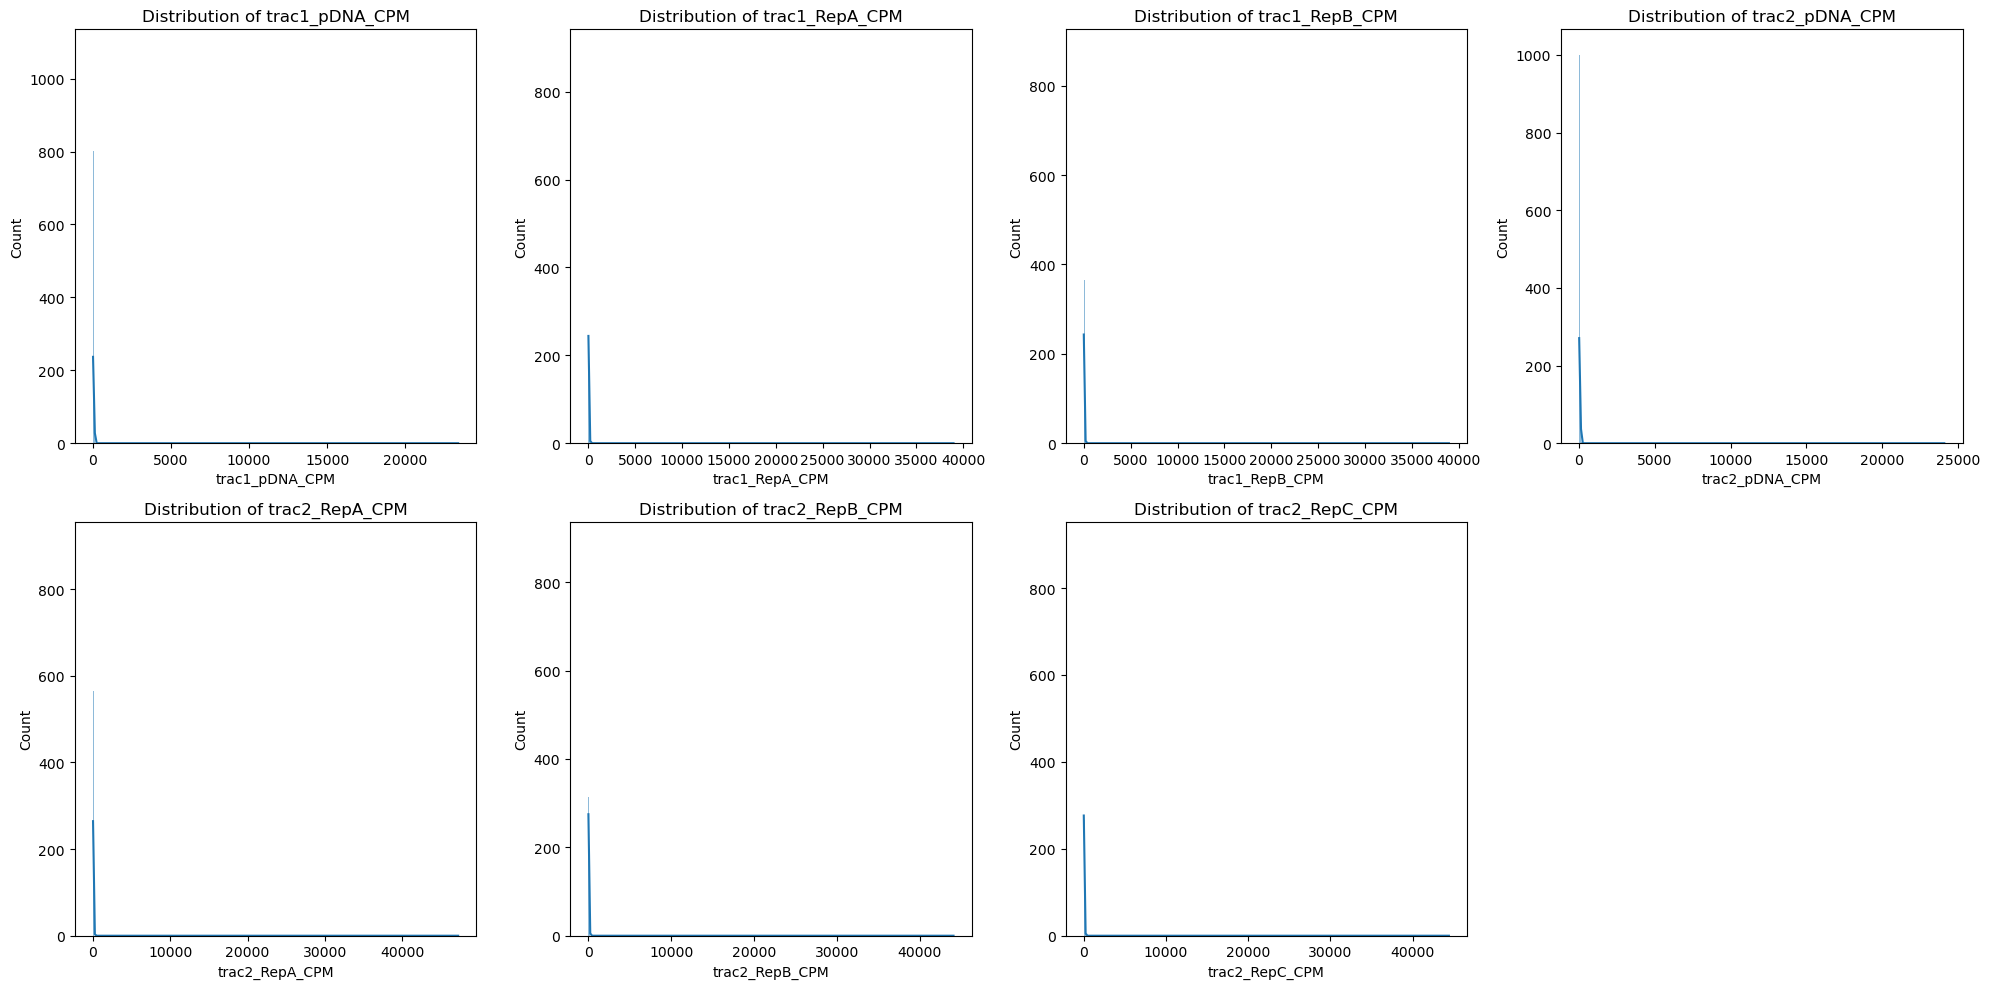

In [148]:
dist_plots(combined_df, norm_cols)
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


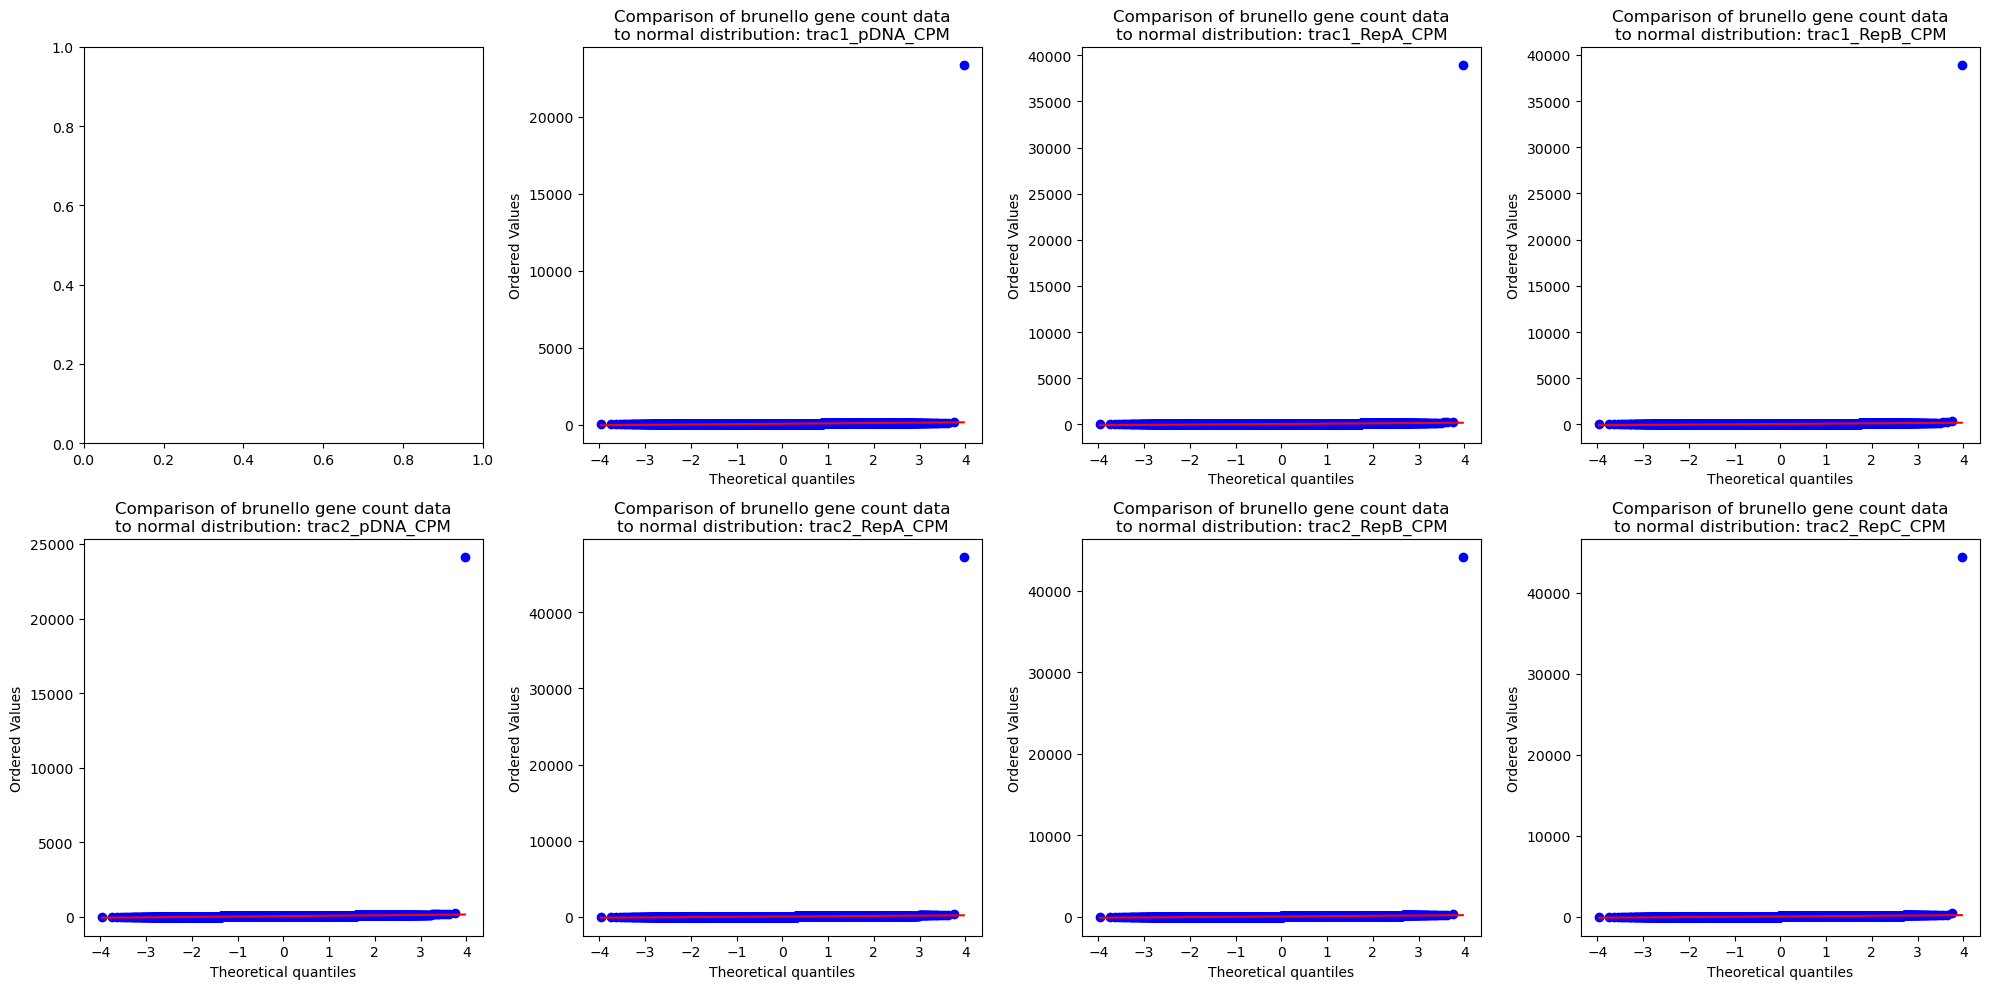

In [149]:
q_q_plots(combined_df, "norm", norm_cols, "Comparison of brunello gene count data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


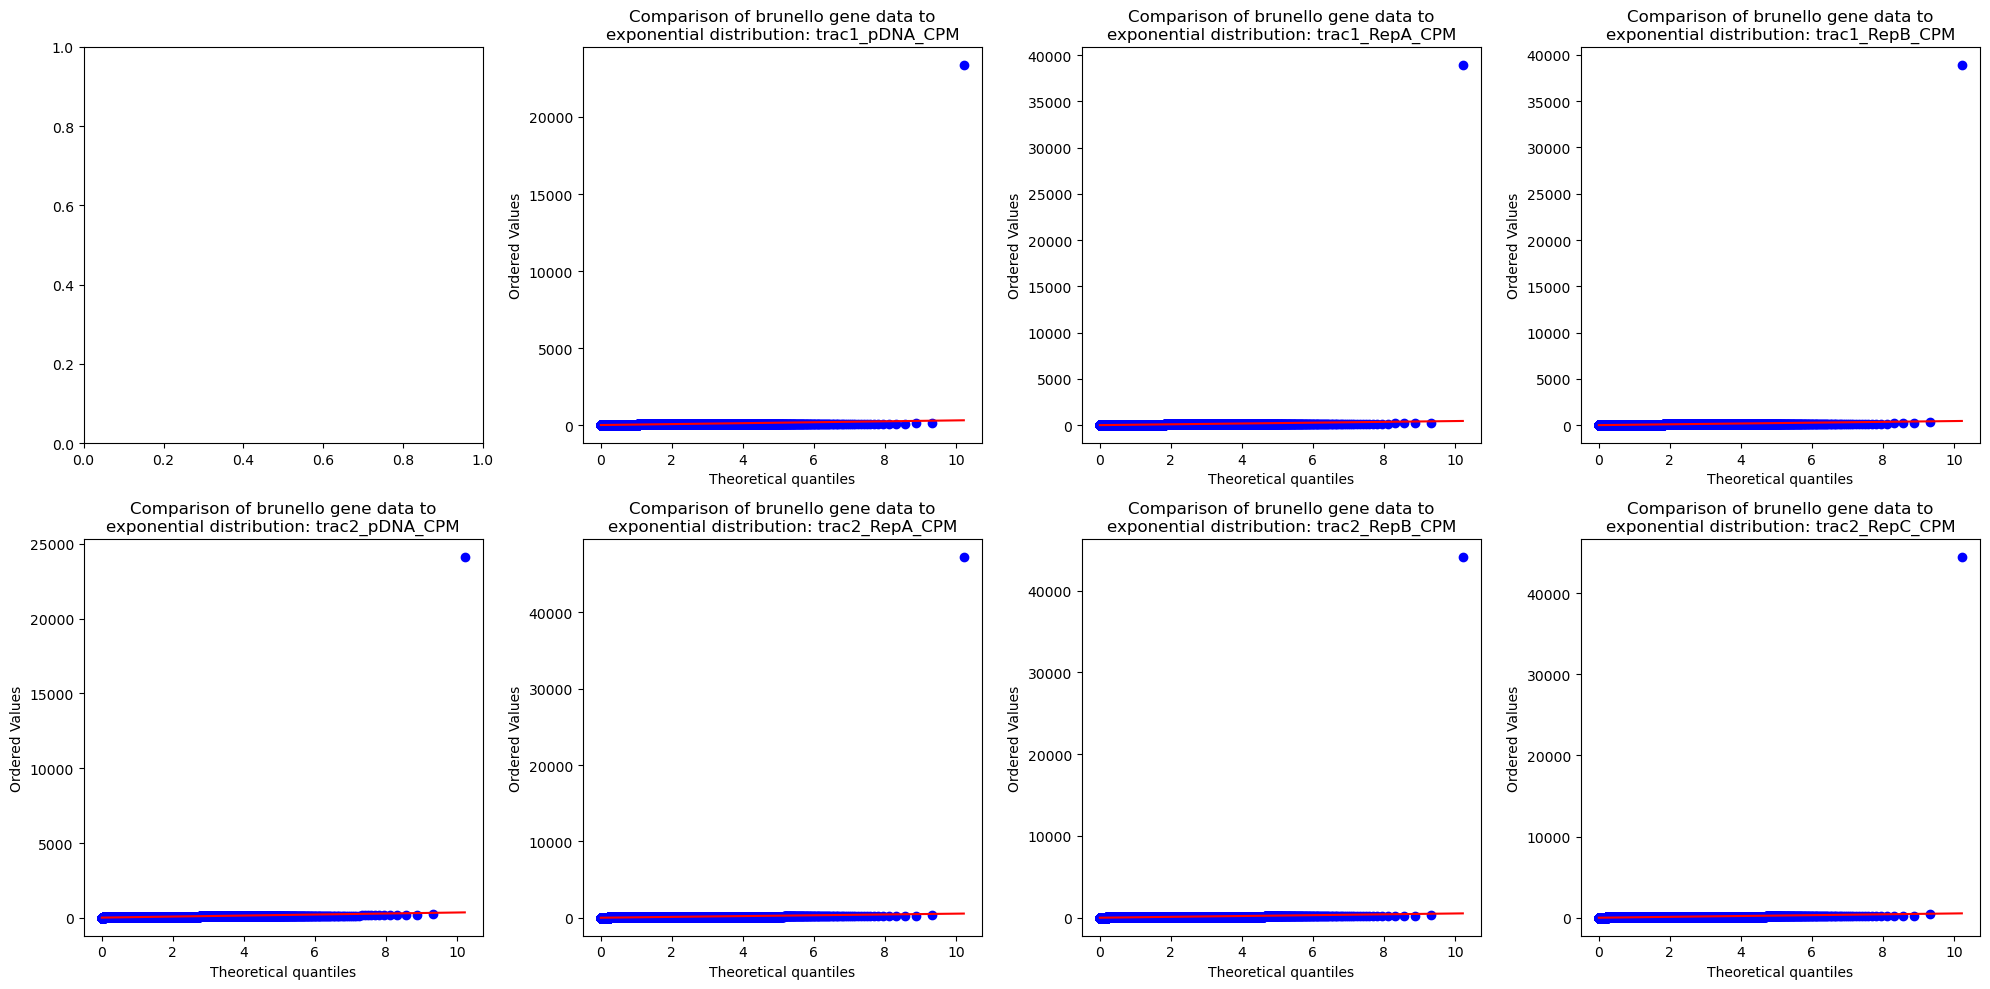

In [150]:
q_q_plots(combined_df, "expon", norm_cols, "Comparison of brunello gene data to exponential distribution")
plt.tight_layout()
plt.show()

# Distribution at the gene level

This looks much different. And maybe matches the normal distribution better (based on the Q-Q plots). But is this less informative?

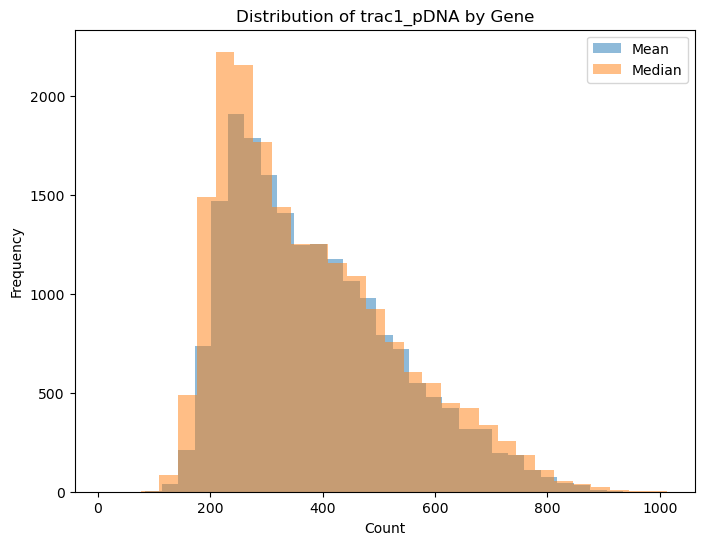

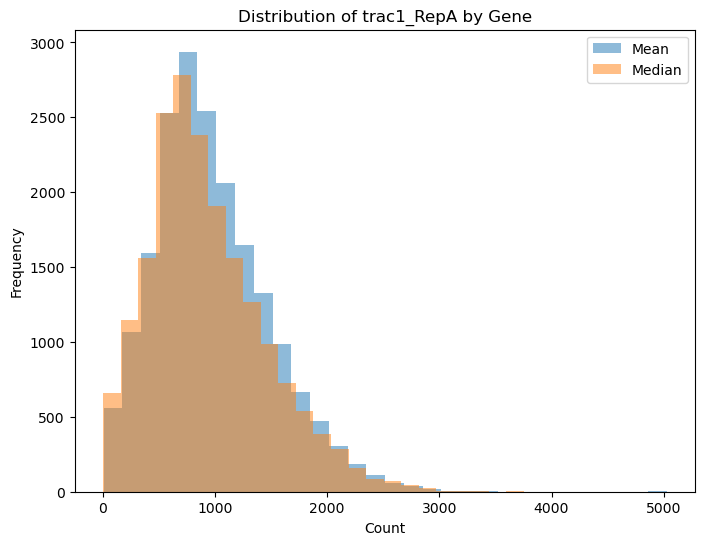

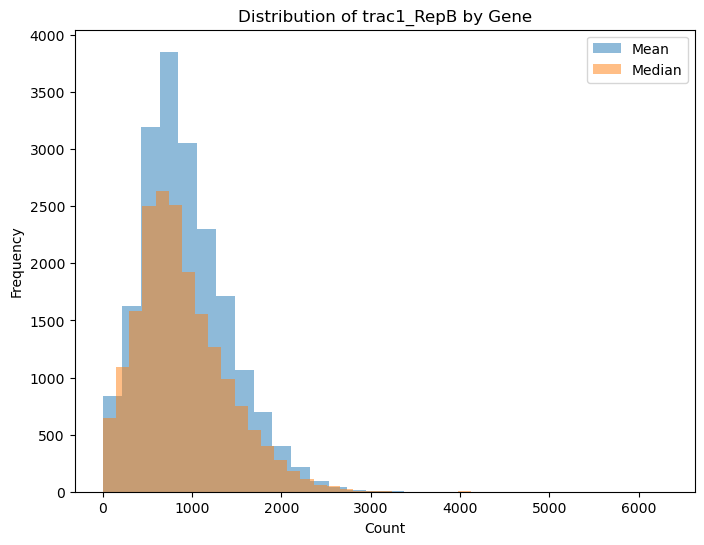

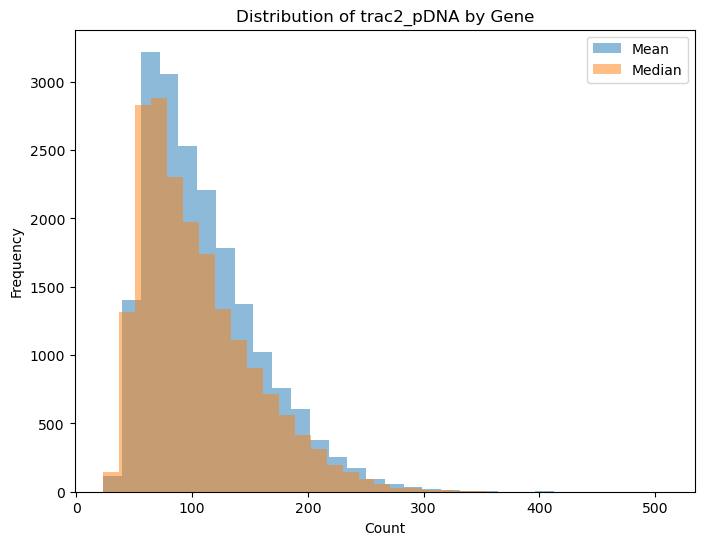

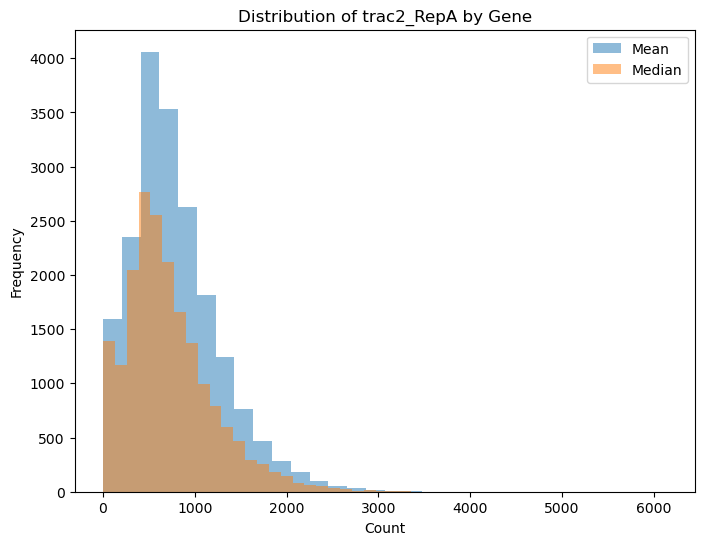

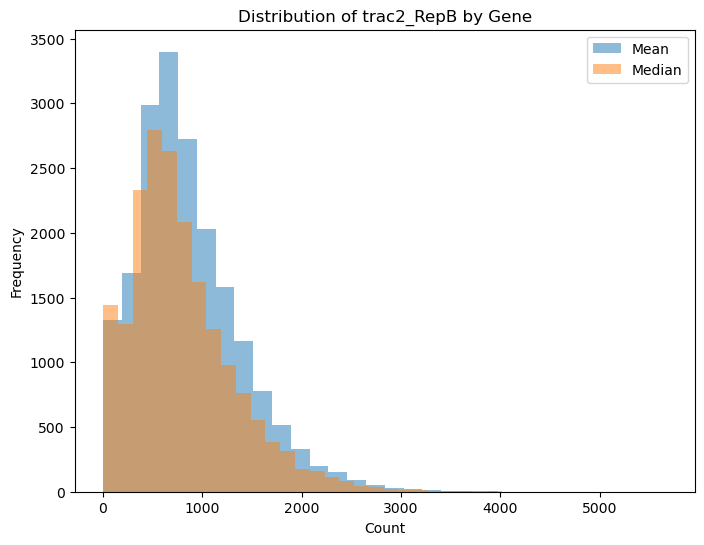

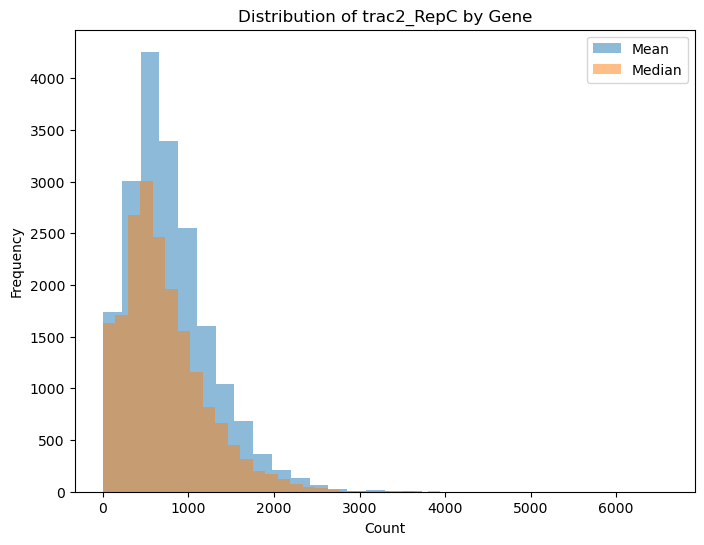

In [151]:
# Calculate mean and median for each count by gene
mean_values = brunello_norm_df.groupby('Target Gene Symbol')[cols].mean()
median_values = brunello_norm_df.groupby('Target Gene Symbol')[cols].median()

show(mean_values.head())
show(median_values.head())
# Plot the distributions
for col in cols:
    plt.figure(figsize=(8, 6))
    plt.hist(mean_values[col], bins=30, alpha=0.5, label='Mean')
    plt.hist(median_values[col], bins=30, alpha=0.5, label='Median')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col} by Gene')
    plt.legend()
    plt.show()

Processing trac1_pDNA
Processing trac1_RepA
Processing trac1_RepB
Processing trac2_pDNA
Processing trac2_RepA
Processing trac2_RepB
Processing trac2_RepC


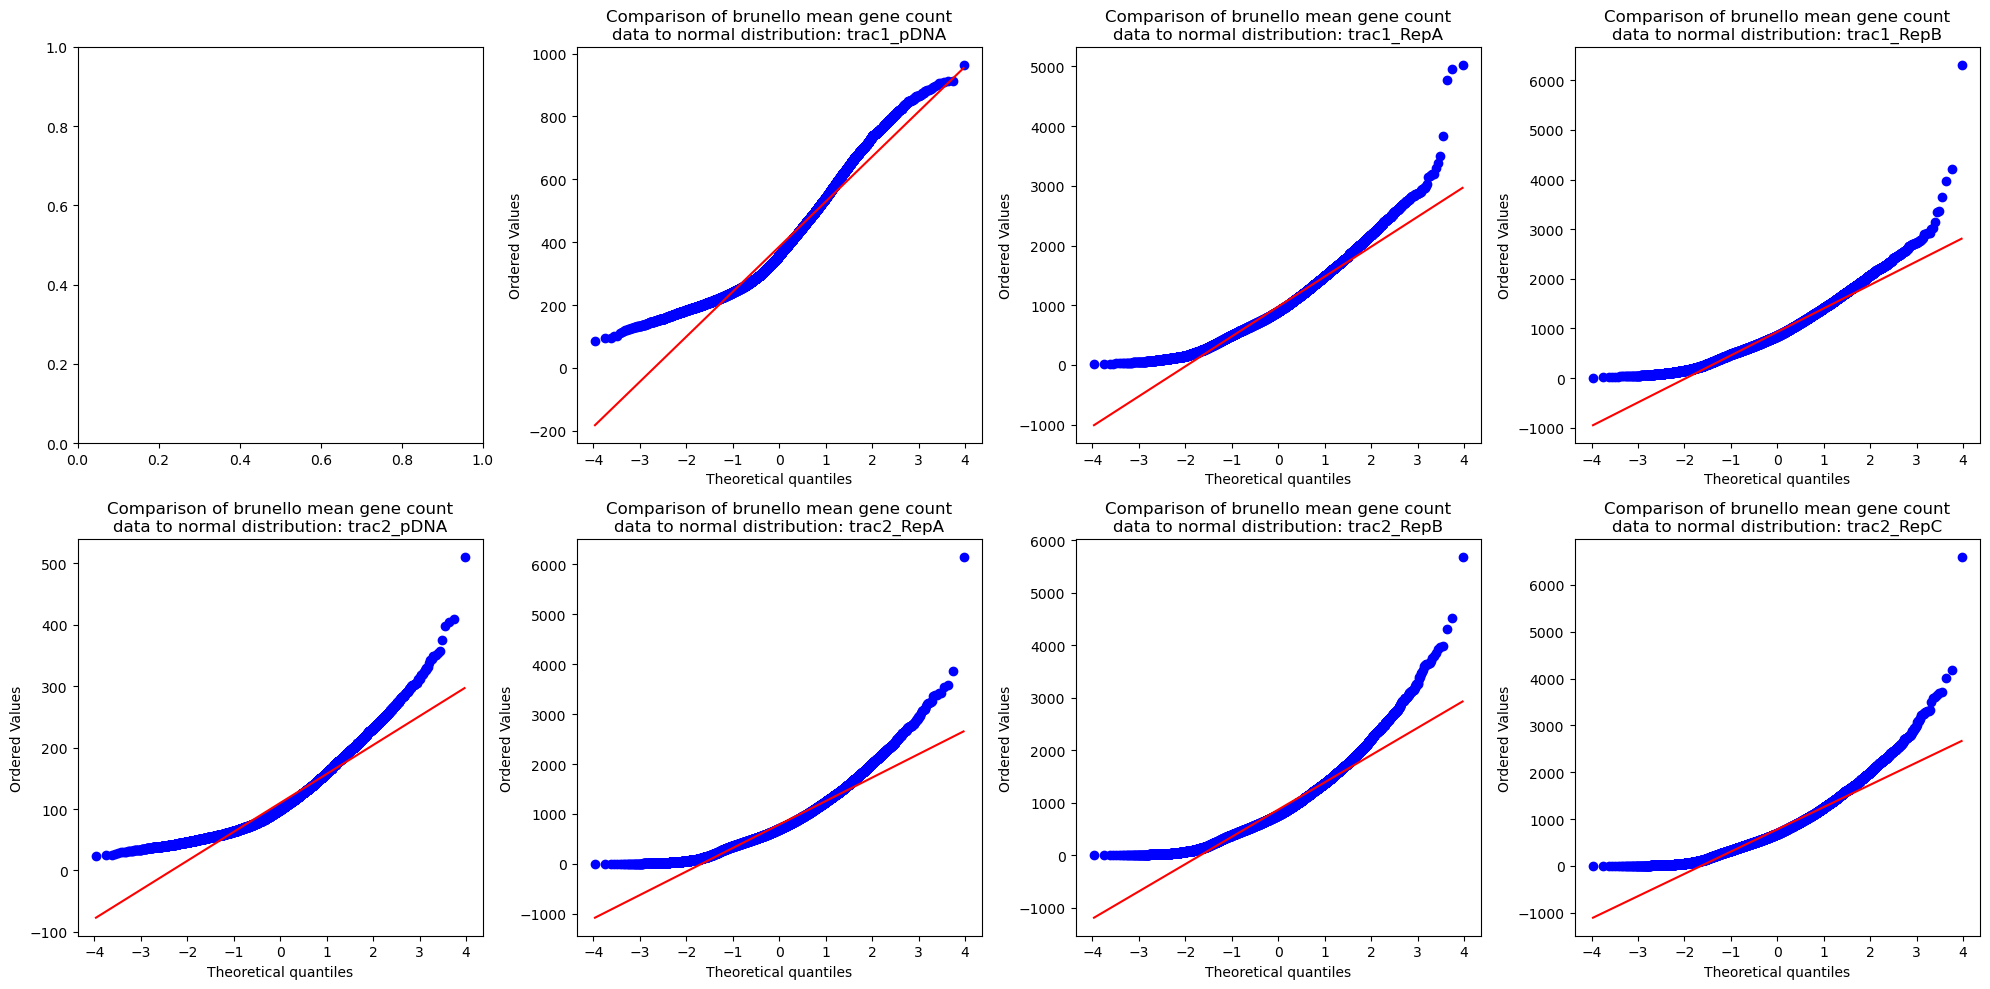

In [152]:
q_q_plots(mean_values, "norm", cols, "Comparison of brunello mean gene count data to normal distribution")
plt.tight_layout()
plt.show()

Processing trac1_pDNA
Processing trac1_RepA
Processing trac1_RepB
Processing trac2_pDNA
Processing trac2_RepA
Processing trac2_RepB
Processing trac2_RepC


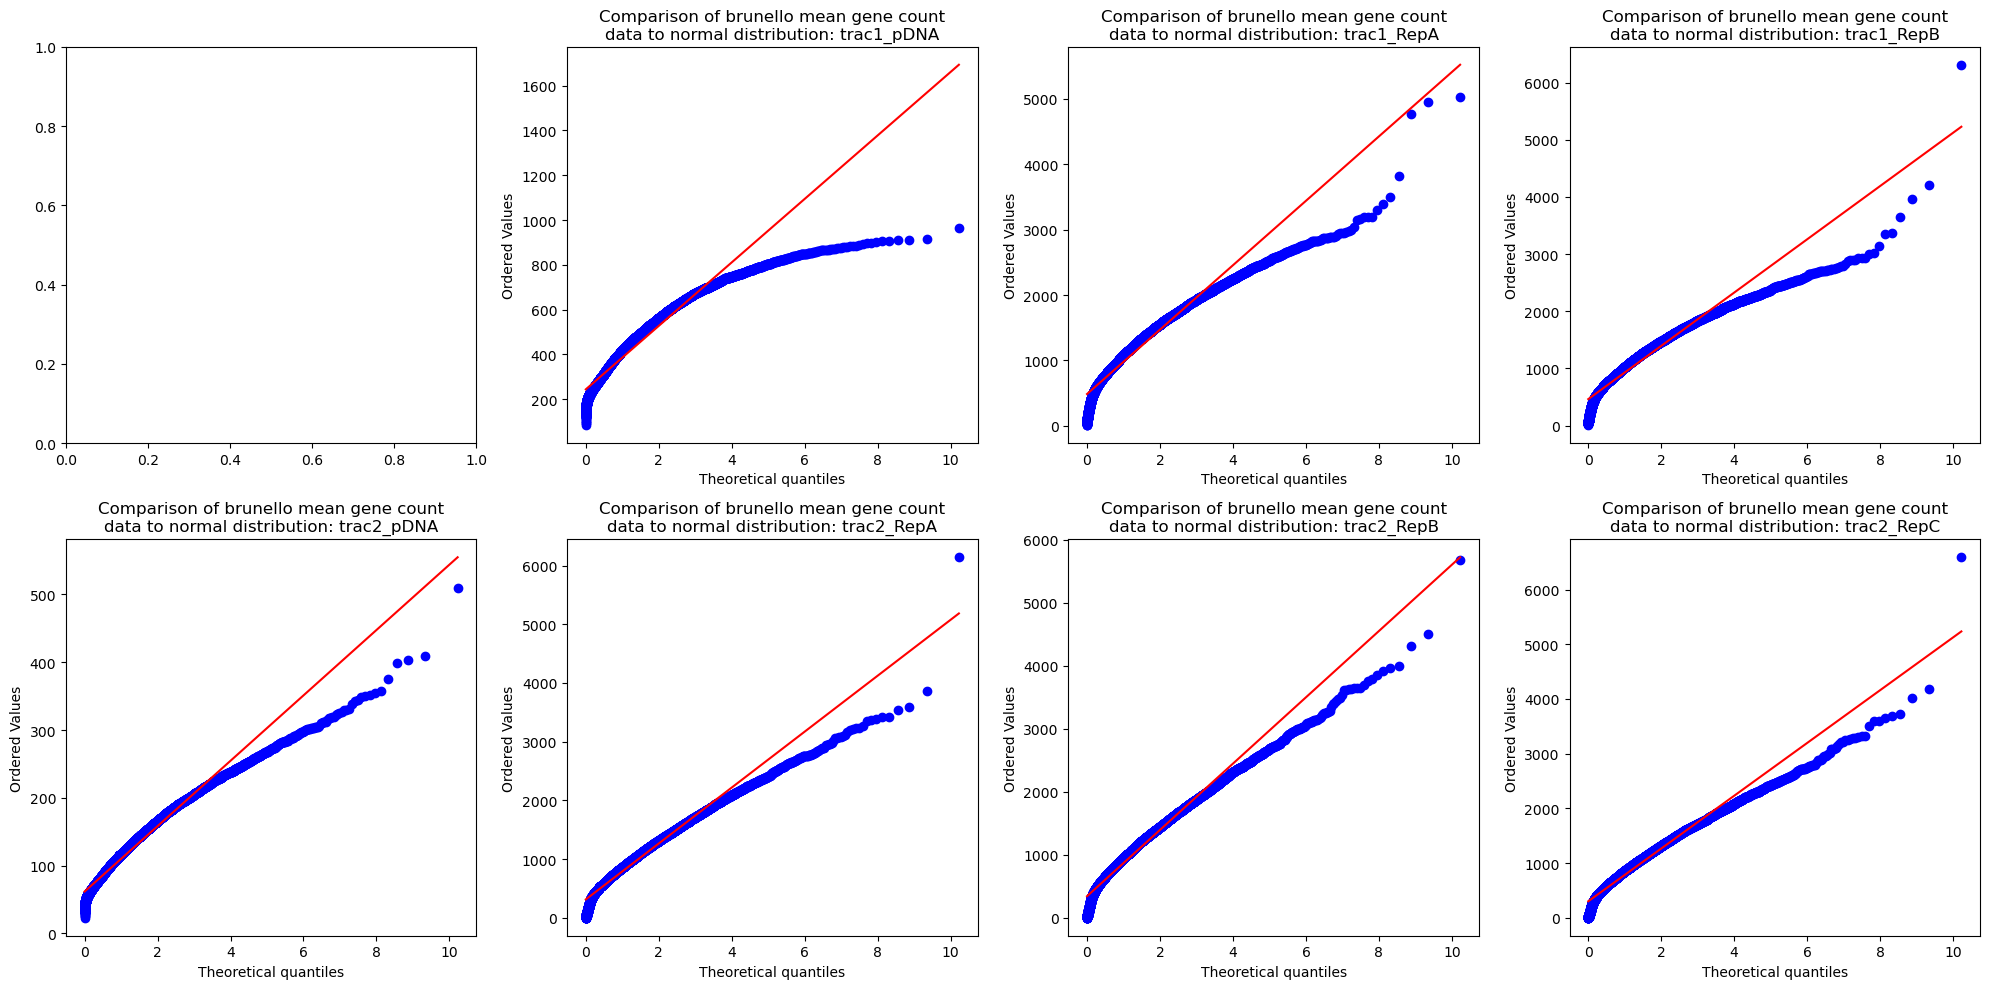

In [153]:
q_q_plots(mean_values, "expon", cols, "Comparison of brunello mean gene count data to normal distribution")
plt.tight_layout()
plt.show()

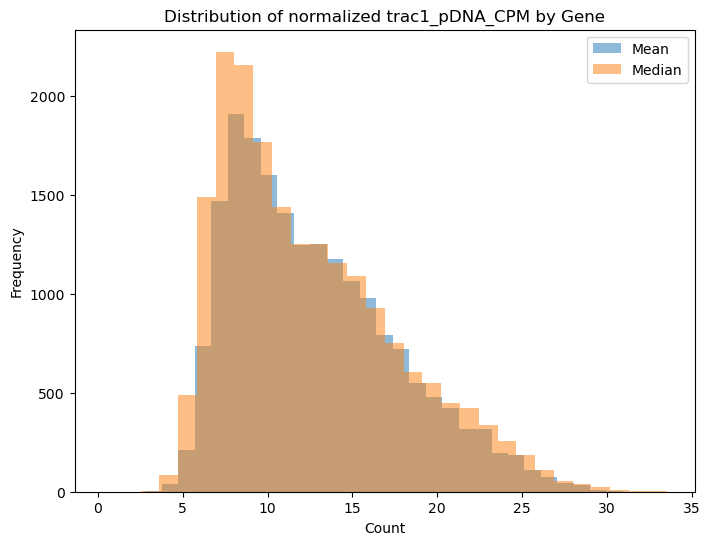

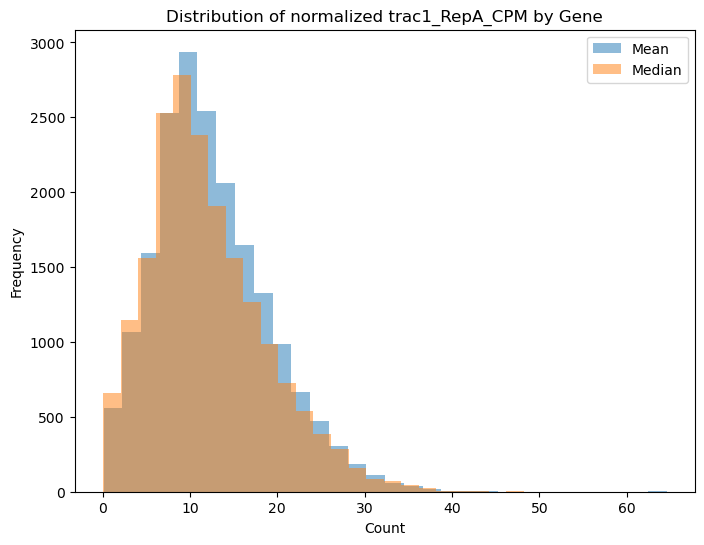

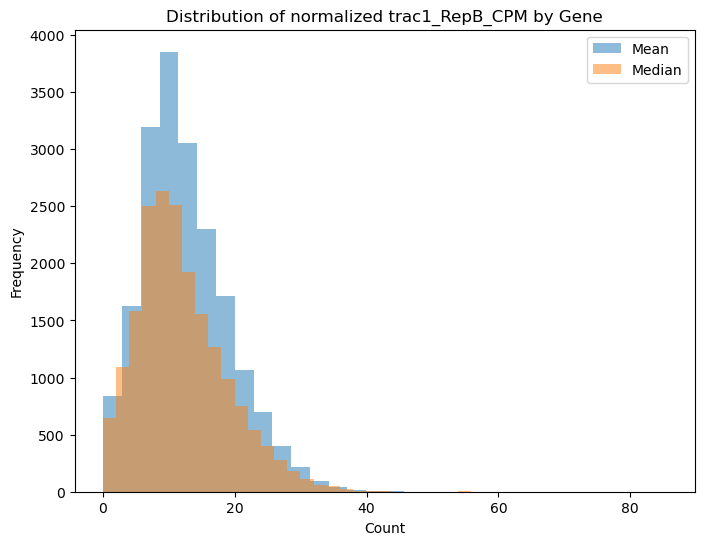

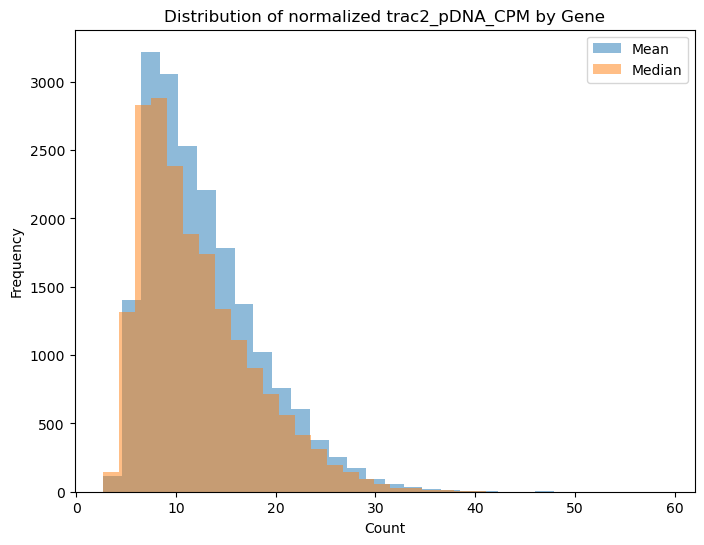

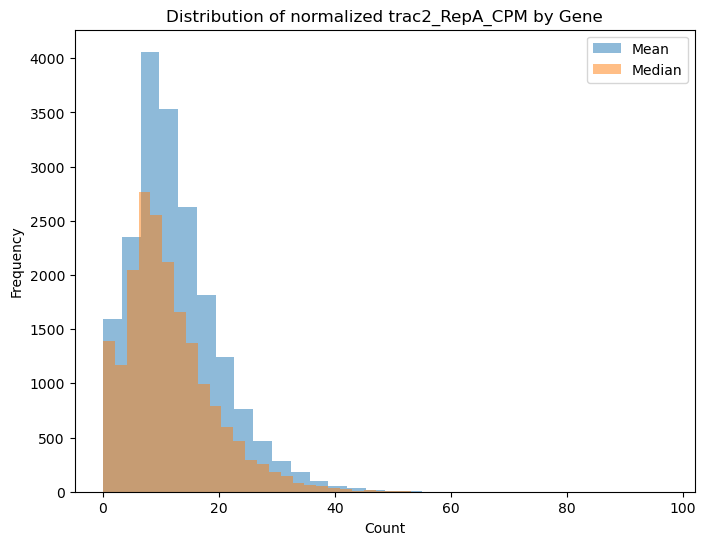

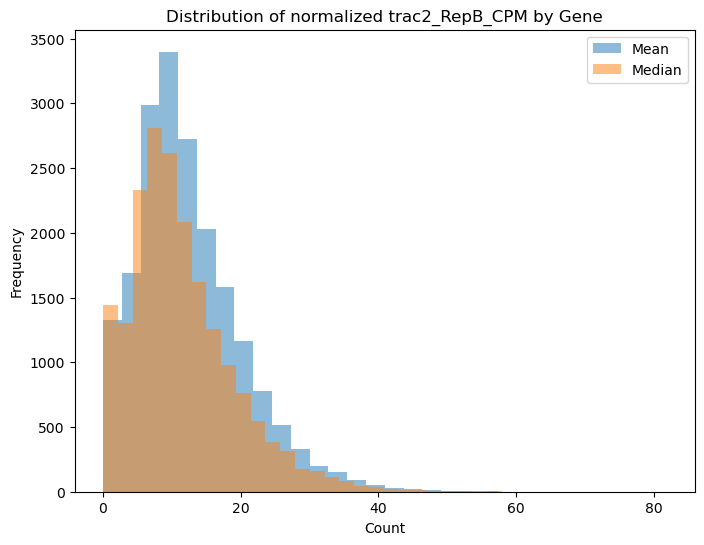

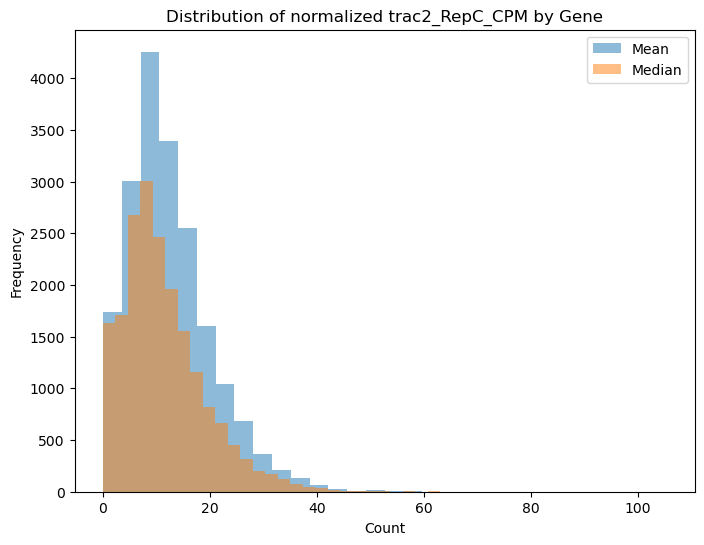

In [154]:
# Calculate mean and median for each count by gene
mean_values = brunello_norm_df.groupby('Target Gene Symbol')[norm_cols].mean()
median_values = brunello_norm_df.groupby('Target Gene Symbol')[norm_cols].median()

show(mean_values.head())
show(median_values.head())
# Plot the distributions
for col in norm_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(mean_values[col], bins=30, alpha=0.5, label='Mean')
    plt.hist(median_values[col], bins=30, alpha=0.5, label='Median')
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of normalized {col} by Gene')
    plt.legend()
    plt.show()

Processing trac1_pDNA_CPM
Processing trac1_RepA_CPM
Processing trac1_RepB_CPM
Processing trac2_pDNA_CPM
Processing trac2_RepA_CPM
Processing trac2_RepB_CPM
Processing trac2_RepC_CPM


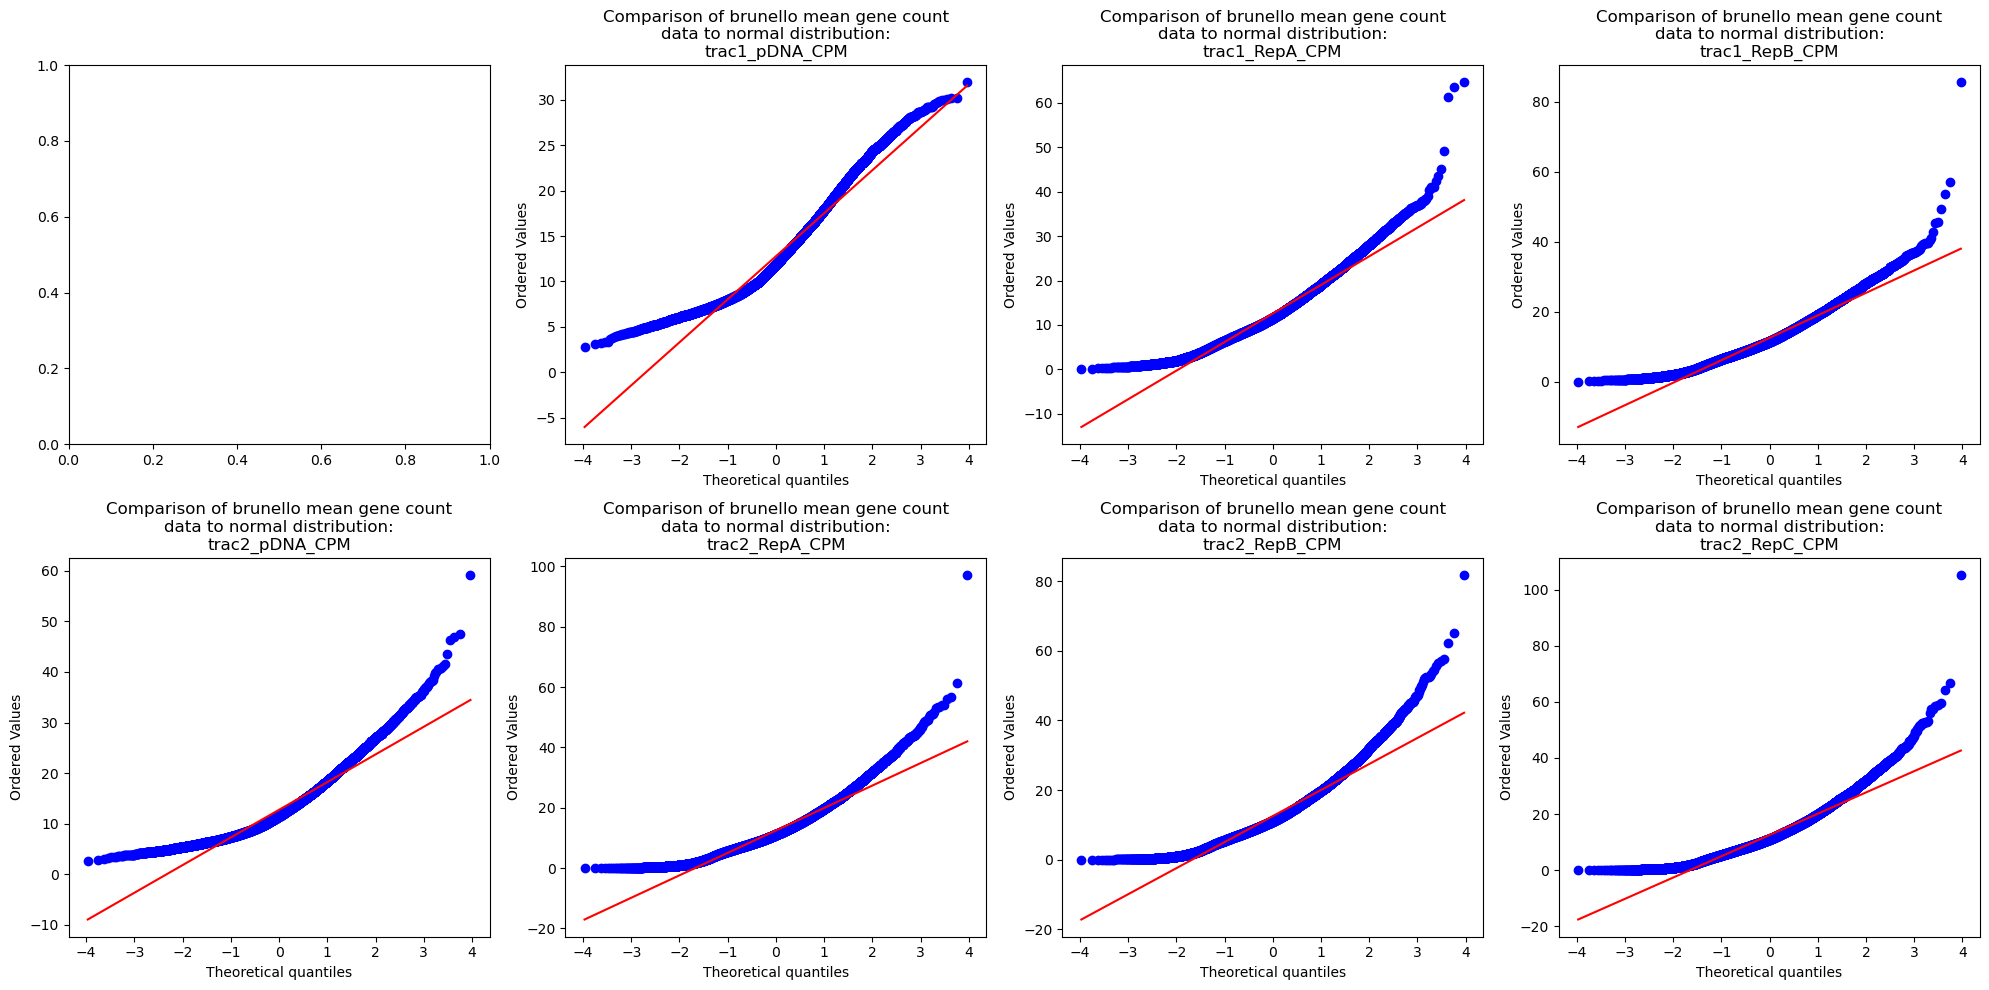

In [155]:
q_q_plots(mean_values, "norm", norm_cols, "Comparison of brunello mean gene count data to normal distribution")
plt.tight_layout()
plt.show()

In [156]:
show(brunello_norm_df.head())

Target Gene Symbol
A1BG       95.837869
A1CF        4.410360
A2M        47.017642
A2ML1       9.520441
A3GALT2    39.950976
             ...    
ZYG11A      3.855044
ZYG11B      4.349217
ZYX        16.558226
ZZEF1       6.563171
ZZZ3       13.689792
Name: trac1_pDNA_CPM, Length: 19115, dtype: float64


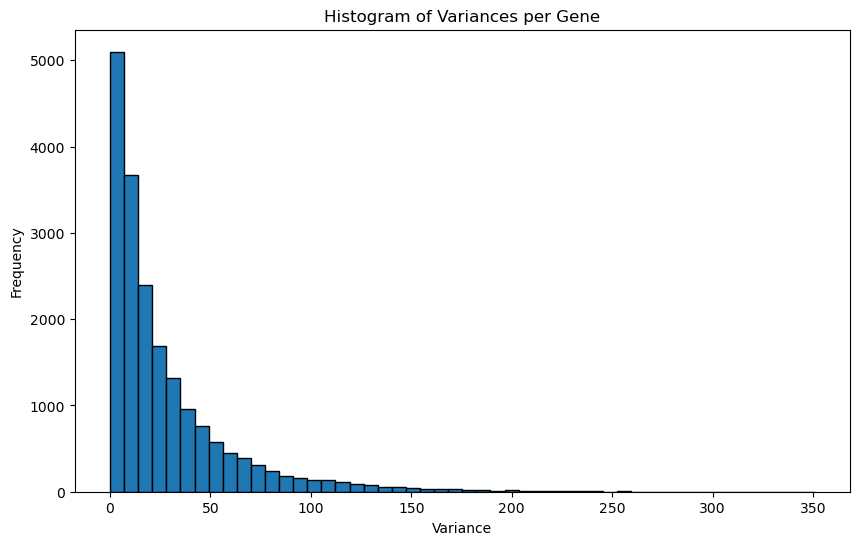

In [157]:
# Group by 'Gene' and calculate the variance of 'Count' for each group
variance_per_gene = brunello_norm_df.groupby('Target Gene Symbol')['trac1_pDNA_CPM'].var()

# Print the variance per gene
print(variance_per_gene)
# Plot the histogram of variances
plt.figure(figsize=(10, 6))
plt.hist(variance_per_gene, bins=50, edgecolor='k')
plt.title('Histogram of Variances per Gene')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()

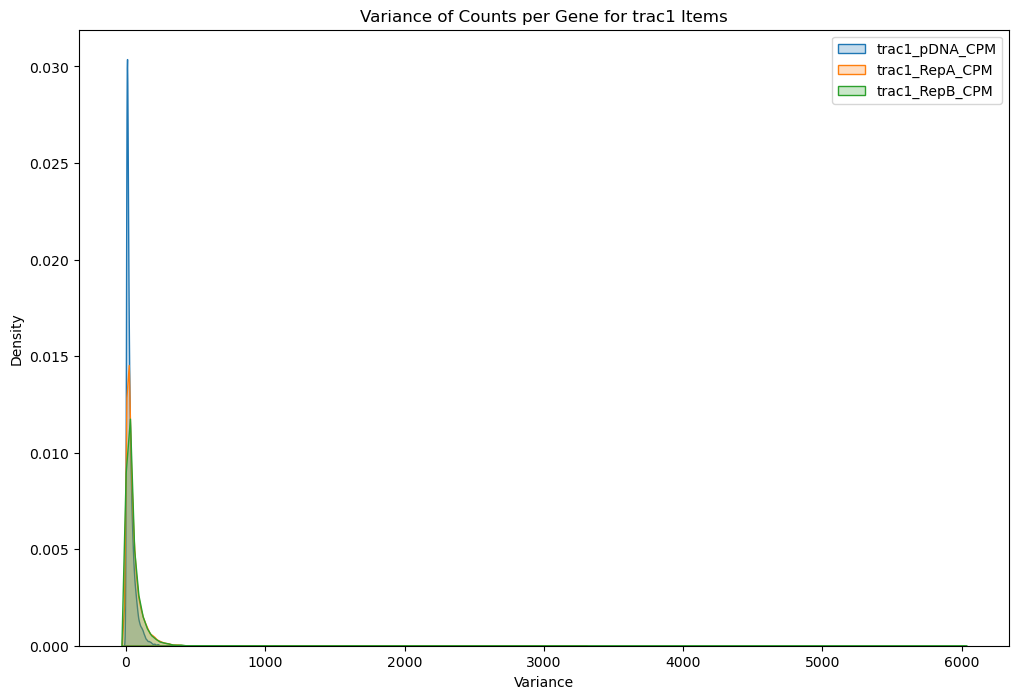

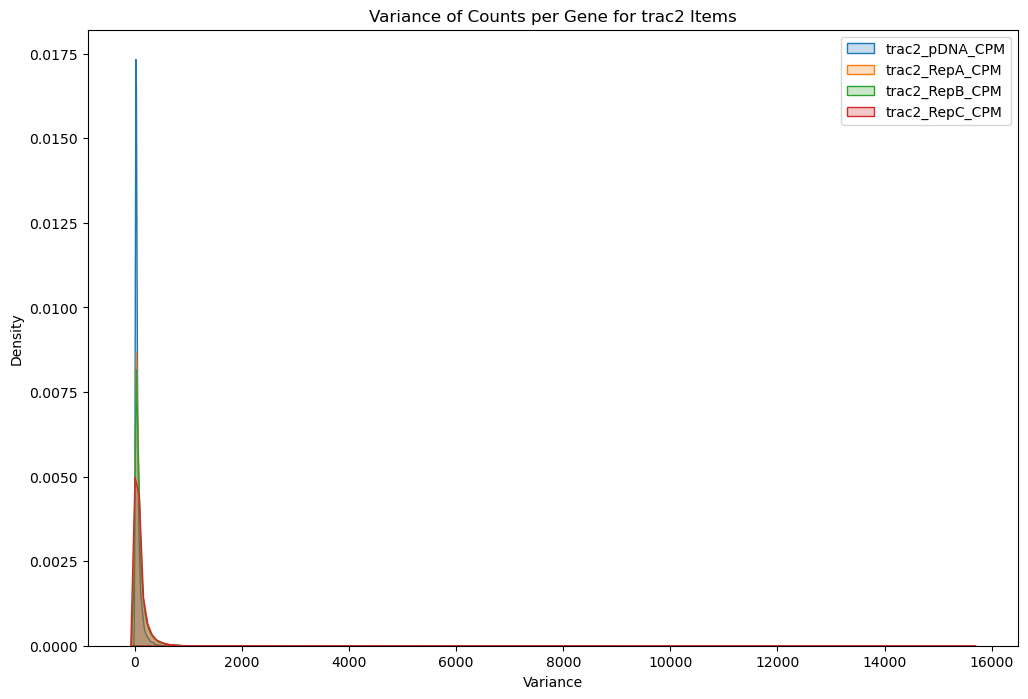

In [158]:
def calculate_and_plot_variance(df, gene_col, count_cols, title):
    """
    Calculate and plot the variance of counts per gene for multiple columns.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    gene_col (str): The name of the column containing gene identifiers.
    count_cols (list): The list of columns containing count data.
    title (str): The title for the plot.
    """
    variances = {}
    
    for count_col in count_cols:
        # Group by 'Gene' and calculate the variance of 'Count' for each group
        variance_per_gene = df.groupby(gene_col)[count_col].var()
        variances[count_col] = variance_per_gene

    # Convert the variances dictionary to a DataFrame for easier plotting
    variances_df = pd.DataFrame(variances)

    # Plot the histogram of variances for each column
    plt.figure(figsize=(12, 8))
    for count_col in count_cols:
        sns.kdeplot(variances_df[count_col].dropna(), label=count_col, fill=True)
    
    plt.title(f'Variance of Counts per Gene for {title}')
    plt.xlabel('Variance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# List of columns to calculate variance for
trac1_columns = [
    'trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM'
]

trac2_columns = [
    'trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM'
]

# Calculate and plot variance for trac1 columns
calculate_and_plot_variance(brunello_norm_df, 'Target Gene Symbol', trac1_columns, 'trac1 Items')

# Calculate and plot variance for trac2 columns
calculate_and_plot_variance(brunello_norm_df, 'Target Gene Symbol', trac2_columns, 'trac2 Items')

# Conclusion

* The normalization does seem to do a nice job of bringing the mean and median closer to together. 
* The distribution looks normal in the middle ranges, but not on the tails. 

# Cutting the data

Can we divide the data into different cuts to get something that conforms to a distribution. 

One interesting thing to look at is 'count quartile'- but do things stay in the same quartile across conditions?

Will do this just for normalized data now

look at trac1 and trac2 separately

# Look at distributions of quartiles

Not enough subplots for all quartiles, some plots may be missing.


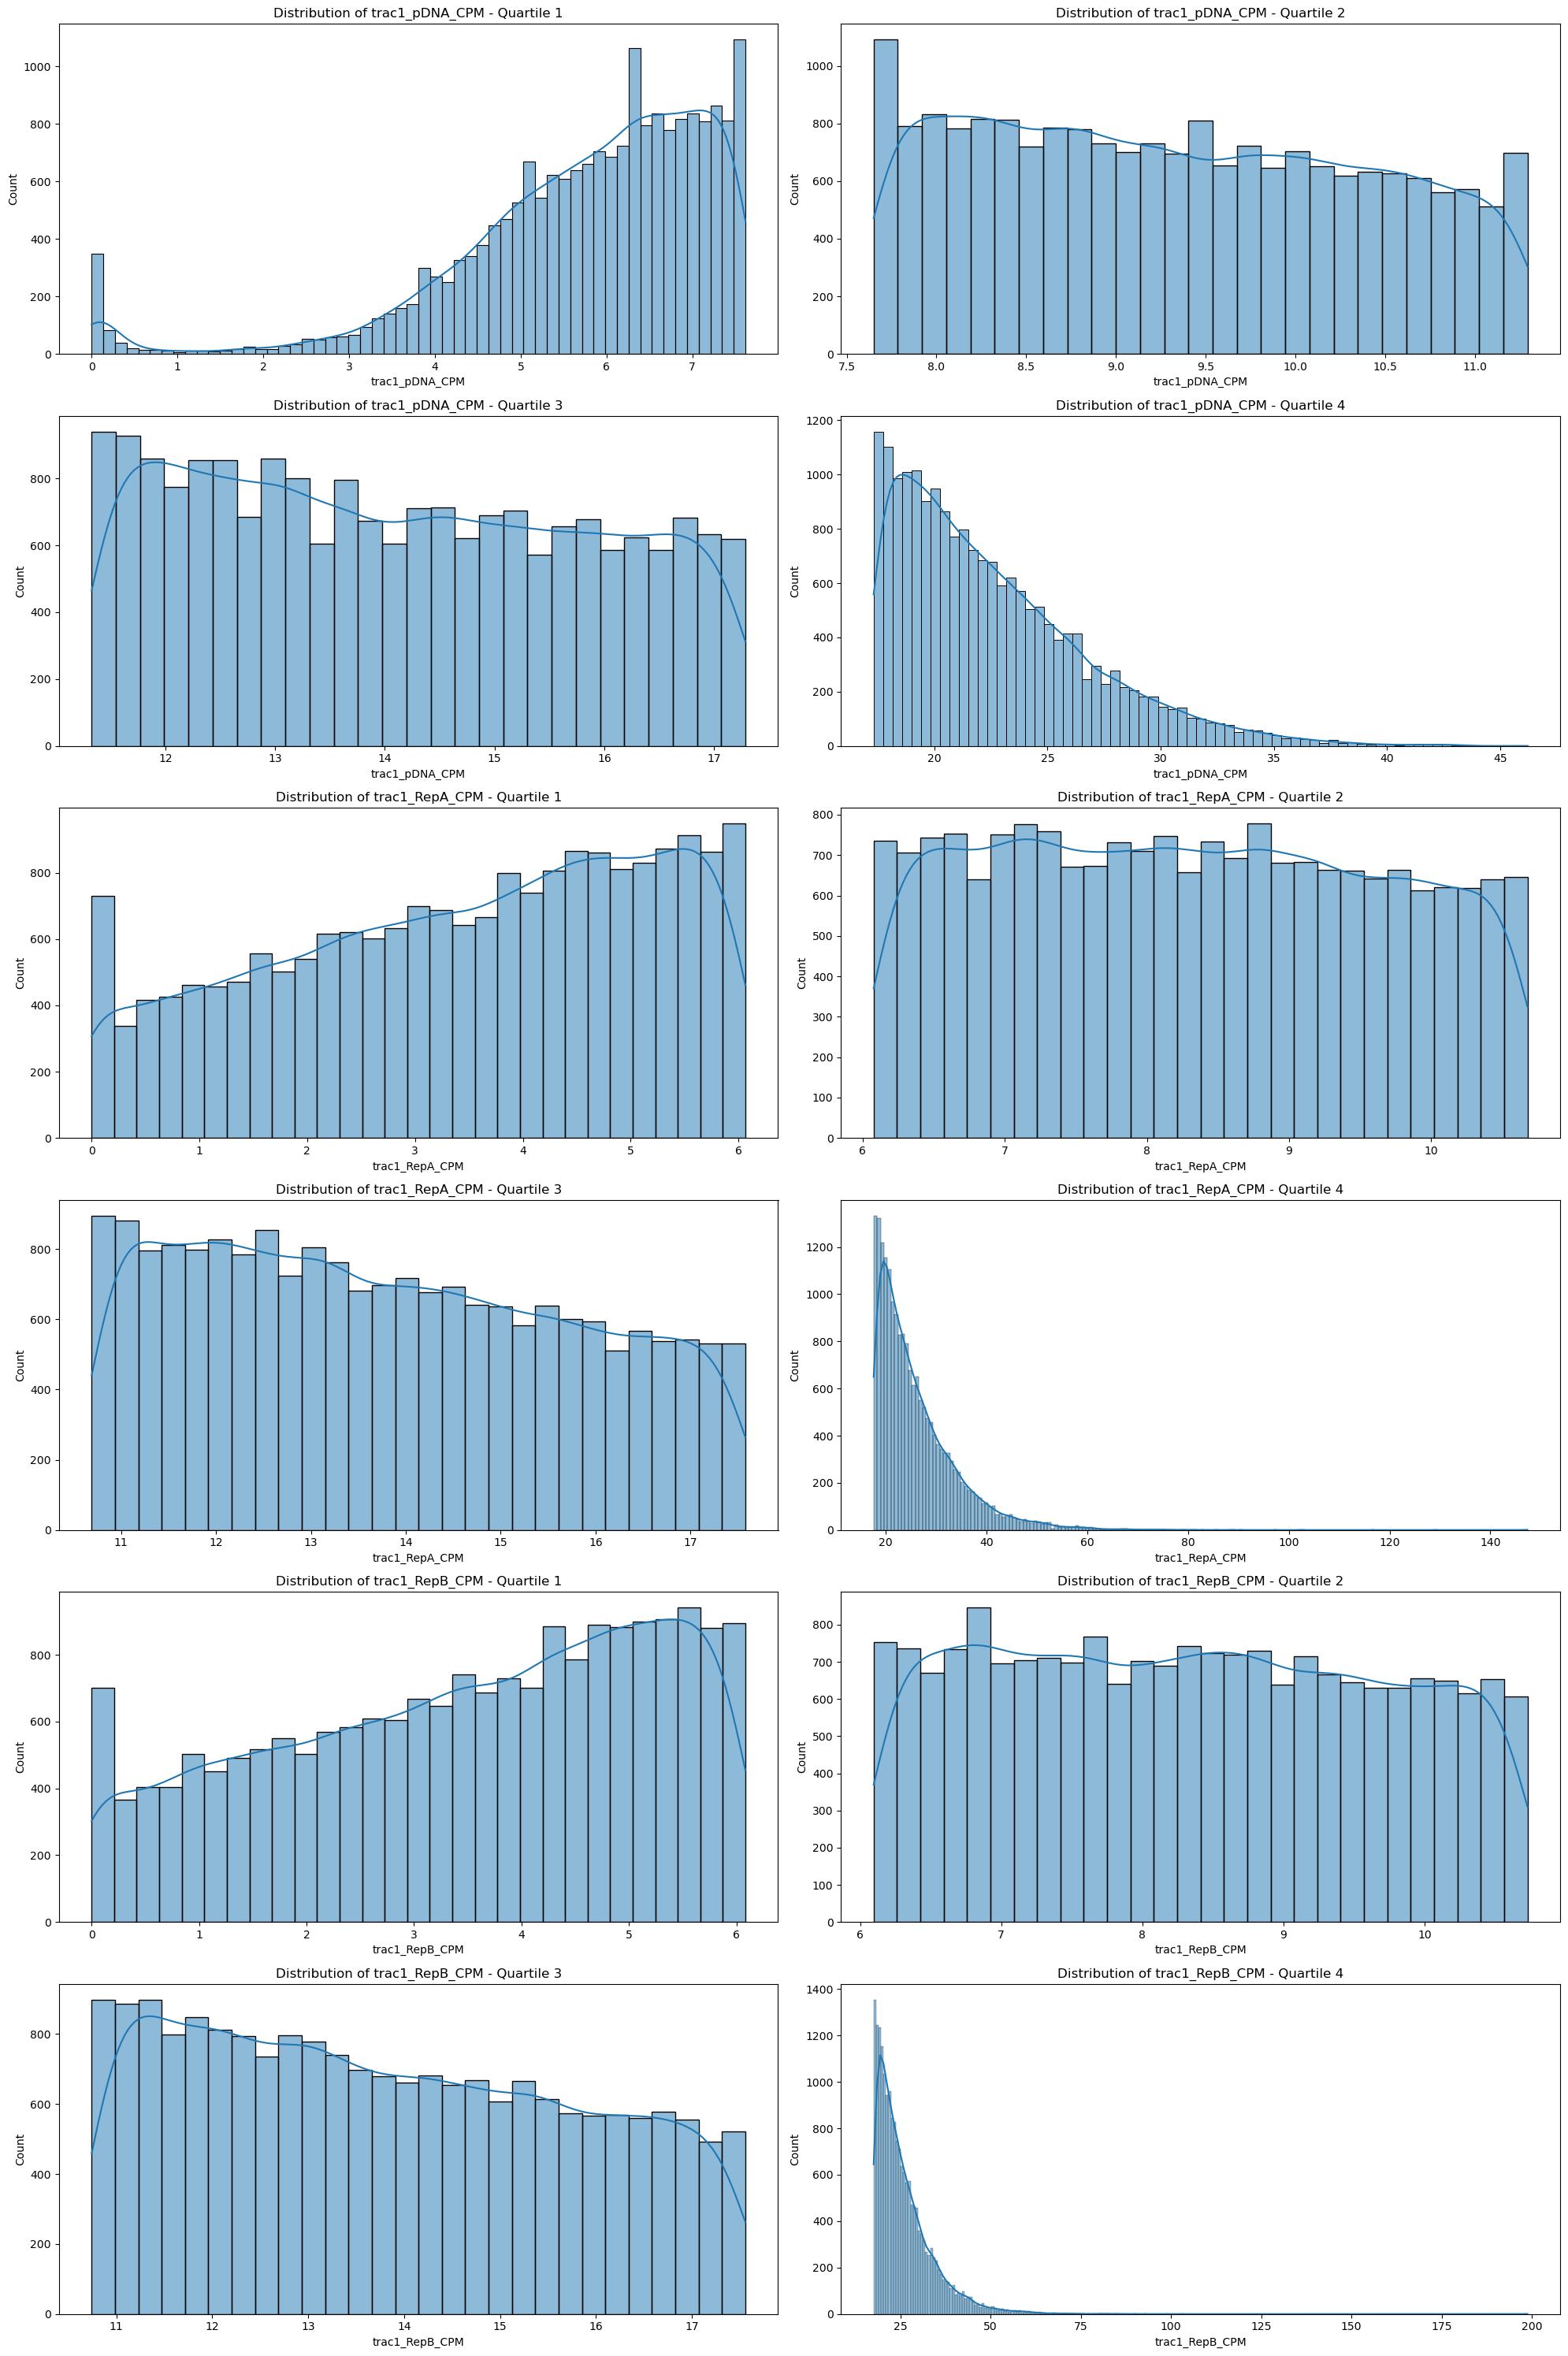

In [161]:
cols=['trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM']
quart_cols=['trac1_pDNA_CPM_quartile', 'trac1_RepA_CPM_quartile', 'trac1_RepB_CPM_quartile']

trac1_df=brunello_norm_df[cols].copy()
#trac1_df=calculate_quartiles(trac1_df, cols)
trac1_df=calculate_tiles(trac1_df, 4, cols)
dist_plots_by_quartile(trac1_df, cols, quart_cols)
plt.tight_layout()
plt.show()

Not enough subplots for all quartiles, some plots may be missing.


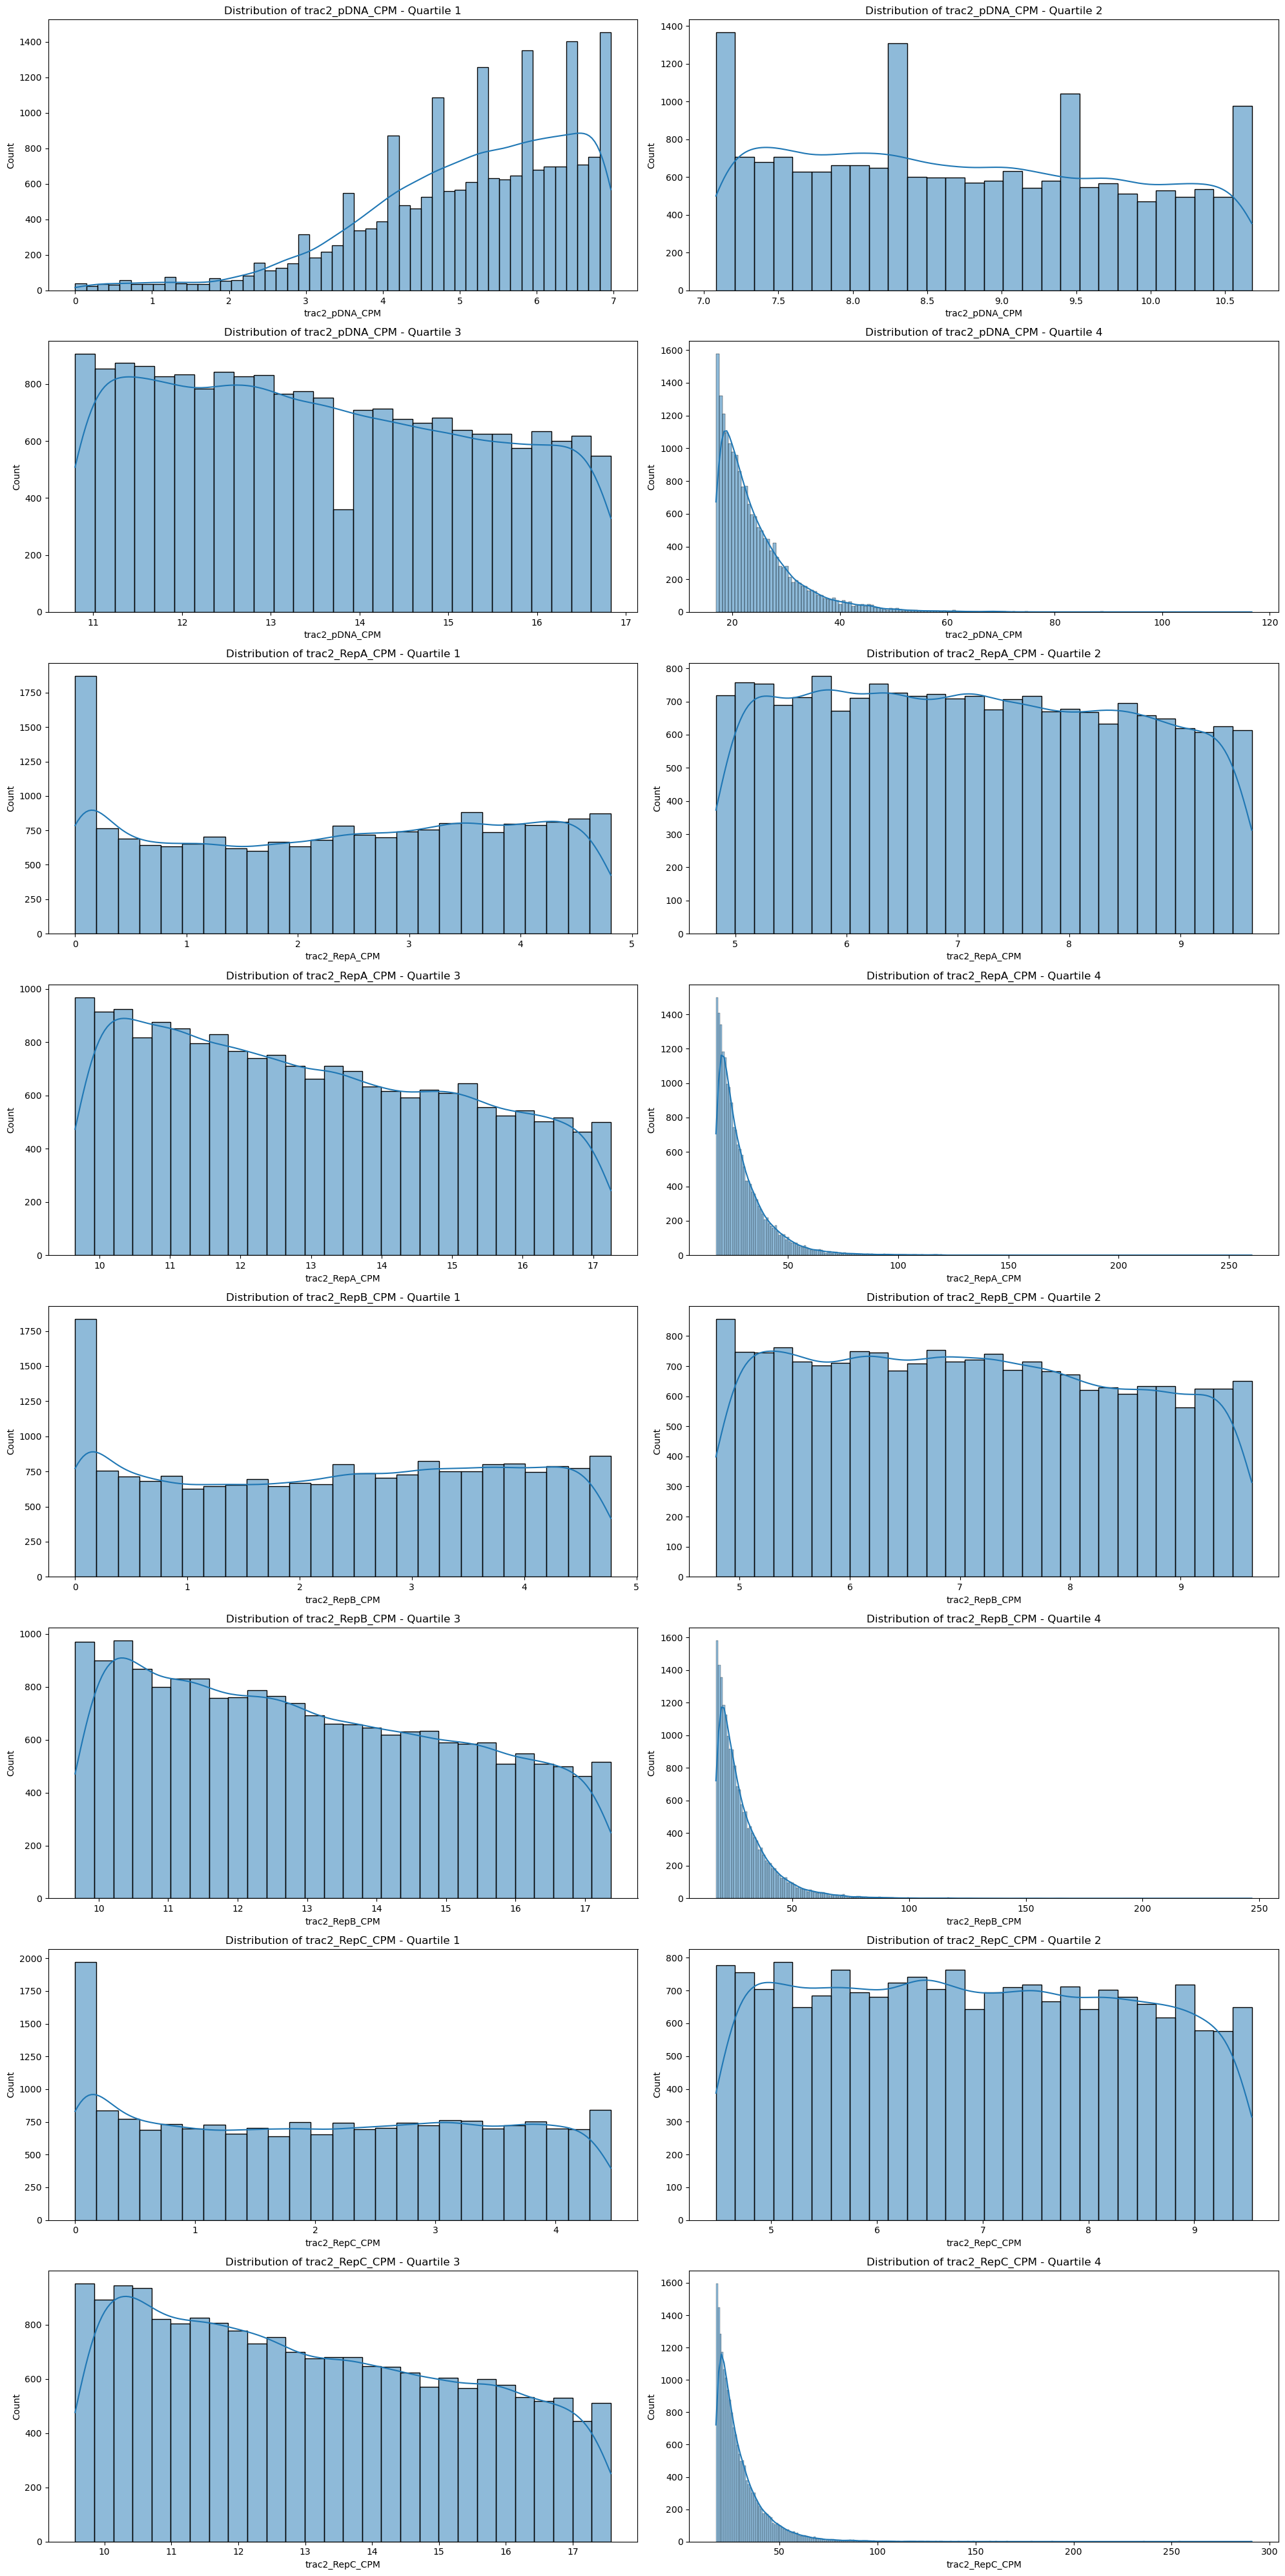

In [162]:
cols=['trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM']
quart_cols=['trac2_pDNA_CPM_quartile', 'trac2_RepA_CPM_quartile', 'trac2_RepB_CPM_quartile', 'trac2_RepC_CPM_quartile']

trac2_df=brunello_norm_df[cols].copy()
#trac2_df=calculate_quartiles(trac2_df, cols)
trac2_df=calculate_tiles(trac2_df, 4, cols)
dist_plots_by_quartile(trac2_df, cols, quart_cols)
plt.tight_layout()
plt.show()

In [164]:
trac1_cols = ['trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM']
trac1_df = brunello_norm_df[trac1_cols + ['sgRNA Sequence', 'Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Position of Base After Cut (1-based)', 'Strand', 'sgRNA Target Sequence', 'Target Context Sequence', 'PAM Sequence', 'Target Exon', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count', 'Annotation']].copy()
show(trac1_df.head())

In [165]:
trac2_cols = ['trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM']
trac2_df = brunello_norm_df[trac2_cols + ['sgRNA Sequence', 'Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Position of Base After Cut (1-based)', 'Strand', 'sgRNA Target Sequence', 'Target Context Sequence', 'PAM Sequence', 'Target Exon', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count', 'Annotation']].copy()
show(trac2_df.head())

In [166]:
# Divide trac1_df into quartiles based on trac1_pDNA_CPM
trac1_df['pDNA_CPM_quartile'] = pd.qcut(trac1_df['trac1_pDNA_CPM'], q=4, labels=False)
trac1_df['RepA_CPM_quartile'] = pd.qcut(trac1_df['trac1_RepA_CPM'], q=4, labels=False)
trac1_df['RepB_CPM_quartile'] = pd.qcut(trac1_df['trac1_RepB_CPM'], q=4, labels=False)
show(trac1_df)


In [167]:
pDNA_repA_quartile_change_count = trac1_df[trac1_df['pDNA_CPM_quartile'] != trac1_df['RepA_CPM_quartile']]
pct=len(pDNA_repA_quartile_change_count.index)/len(trac1_df) * 100
print(f"Number of trac1 guides that change quartile between pDNA and RepA: {len(pDNA_repA_quartile_change_count.index)} ({pct:.2f}) of {len(trac1_df.index)}")

Number of trac1 guides that change quartile between pDNA and RepA: 37210 (48.04) of 77449


In [168]:
pDNA_repB_quartile_change_count = trac1_df[trac1_df['pDNA_CPM_quartile'] != trac1_df['RepB_CPM_quartile']]
pct=len(pDNA_repB_quartile_change_count.index)/len(trac1_df) * 100
print(f"Number of trac1 guides that change quartile pDNA and RepB: {len(pDNA_repB_quartile_change_count.index)} ({pct:.2f}) of {len(trac1_df.index)}")

Number of trac1 guides that change quartile pDNA and RepB: 37164 (47.99) of 77449


In [169]:
repA_repB_quartile_change_count=trac1_df[trac1_df['RepA_CPM_quartile'] != trac1_df['RepB_CPM_quartile']]
pct=len(repA_repB_quartile_change_count.index)/len(trac1_df) * 100
print(f"Number of trac1 guides that change quartile RepA and RepB: {len(repA_repB_quartile_change_count.index)} ({pct:.2f}) of {len(trac1_df.index)}")

Number of trac1 guides that change quartile RepA and RepB: 28126 (36.32) of 77449


In [170]:
#Can we look at the direction of the change?
#Calculate change direction between pDNA and RepA
trac1_df['pDNA_to_RepA_change'] = trac1_df.apply(lambda row: 'up' if row['RepA_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepA_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
show(trac1_df.head())

In [171]:
#Calculate change direction between pDNA and RepA
trac1_df['pDNA_to_RepB_change'] = trac1_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac1_df['RepA_to_RepB_change'] = trac1_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['RepA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['RepA_CPM_quartile'] else 'same'), axis=1)
show(trac1_df.head())

In [172]:
pDNA_RepA_vc=trac1_df['pDNA_to_RepA_change'].value_counts()

In [173]:
pDNA_RepB_vc=trac1_df['pDNA_to_RepB_change'].value_counts()

In [174]:
RepA_RepB_vc=trac1_df['RepA_to_RepB_change'].value_counts()

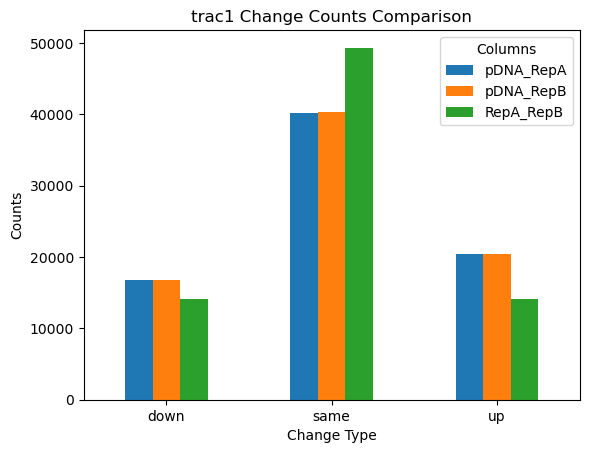

In [175]:
all_changes=pd.DataFrame({'pDNA_RepA': pDNA_RepA_vc, 'pDNA_RepB': pDNA_RepB_vc, 'RepA_RepB': RepA_RepB_vc})

# Plot
all_changes.plot(kind='bar')
plt.title('trac1 Change Counts Comparison')
plt.xlabel('Change Type')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep the labels on the x-axis readable
plt.legend(title='Columns')
plt.show()

# Conclusion

There are a decent number of guides that change quartile, you might expect more of this between pDNA (start) and RepA or RepB- but you would want more consistency between RepA and RepB. 

In [176]:
unique_guide_actions_per_gene=trac1_df.groupby('Target Gene Symbol')['RepA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"The number of genes with guides that act differently between RepA and RepB: {num_genes_with_different_guides}")

The number of genes with guides that act differently between RepA and RepB: 15353


In [177]:
unique_guide_actions_per_gene=trac1_df.groupby('Target Gene Symbol')['pDNA_to_RepA_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"The number of genes with guides that act differently between pDNA and RepA: {num_genes_with_different_guides}")

The number of genes with guides that act differently between pDNA and RepA: 16226


In [178]:
unique_guide_actions_per_gene=trac1_df.groupby('Target Gene Symbol')['pDNA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"The number of genes with guides that act differently between pDNA and RepB: {num_genes_with_different_guides}")

The number of genes with guides that act differently between pDNA and RepB: 16164


# Conclusion

Most genes have guides in different quartiles. 

There are 19,115 total genes.

* 15,353 of these have guides in different quartiles between RepA and RepB
* 16,226 of these have guides in different quartiles between pDNA and RepA
* 16,164 of these have guides in different quartiles between pDNA and RepA

In [179]:
show(trac2_df.head())

In [180]:
#Do this for trac2

trac2_df['pDNA_CPM_quartile'] = pd.qcut(trac2_df['trac2_pDNA_CPM'], q=4, labels=False)
trac2_df['RepA_CPM_quartile'] = pd.qcut(trac2_df['trac2_RepA_CPM'], q=4, labels=False)
trac2_df['RepB_CPM_quartile'] = pd.qcut(trac2_df['trac2_RepB_CPM'], q=4, labels=False)
trac2_df['RepC_CPM_quartile'] = pd.qcut(trac2_df['trac2_RepC_CPM'], q=4, labels=False )
show(trac2_df)

In [181]:
#Calculate change direction between conditions
trac2_df['pDNA_to_RepA_change'] = trac2_df.apply(lambda row: 'up' if row['RepA_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepA_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac2_df['pDNA_to_RepB_change'] = trac2_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac2_df['pDNA_to_RepC_change'] = trac2_df.apply(lambda row: 'up' if row['RepC_CPM_quartile'] > row['pDNA_CPM_quartile'] else ('down' if row['RepC_CPM_quartile'] < row['pDNA_CPM_quartile'] else 'same'), axis=1)
trac2_df['RepA_to_RepB_change'] = trac2_df.apply(lambda row: 'up' if row['RepB_CPM_quartile'] > row['RepA_CPM_quartile'] else ('down' if row['RepB_CPM_quartile'] < row['RepA_CPM_quartile'] else 'same'), axis=1)
trac2_df['RepA_to_RepC_change'] = trac2_df.apply(lambda row: 'up' if row['RepC_CPM_quartile'] > row['RepA_CPM_quartile'] else ('down' if row['RepC_CPM_quartile'] < row['RepA_CPM_quartile'] else 'same'), axis=1)
trac2_df['RepB_to_RepC_change'] = trac2_df.apply(lambda row: 'up' if row['RepC_CPM_quartile'] > row['RepB_CPM_quartile'] else ('down' if row['RepC_CPM_quartile'] < row['RepB_CPM_quartile'] else 'same'), axis=1)
show(trac2_df.head())

In [182]:
pDNA_RepA_vc=trac2_df['pDNA_to_RepA_change'].value_counts()
pDNA_RepB_vc=trac2_df['pDNA_to_RepB_change'].value_counts()
pDNA_RepC_vc=trac2_df['pDNA_to_RepC_change'].value_counts()
RepA_RepB_vc=trac2_df['RepA_to_RepB_change'].value_counts()
RepA_RepC_vc=trac2_df['RepA_to_RepC_change'].value_counts()
RepB_RepC_vc=trac2_df['RepB_to_RepC_change'].value_counts()

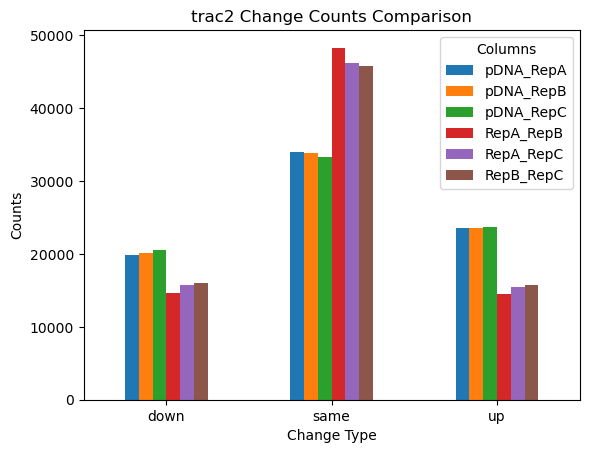

In [183]:
all_changes=pd.DataFrame({'pDNA_RepA': pDNA_RepA_vc, 'pDNA_RepB': pDNA_RepB_vc, 'pDNA_RepC': pDNA_RepC_vc, 
                          'RepA_RepB': RepA_RepB_vc, 'RepA_RepC': RepA_RepC_vc, 'RepB_RepC': RepB_RepC_vc})

# Plot
all_changes.plot(kind='bar')
plt.title('trac2 Change Counts Comparison')
plt.xlabel('Change Type')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep the labels on the x-axis readable
plt.legend(title='Columns')
plt.show()

In [184]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['RepA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between RepA and RepB: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between RepA and RepB: 15589


In [185]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['RepA_to_RepC_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between RepB and RepC: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between RepB and RepC: 16067


In [186]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['pDNA_to_RepA_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between pDNA and RepA: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between pDNA and RepA: 17003


In [187]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['pDNA_to_RepB_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between pDNA and RepB: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between pDNA and RepB: 16943


In [188]:
unique_guide_actions_per_gene=trac2_df.groupby('Target Gene Symbol')['pDNA_to_RepC_change'].nunique()

# Filter genes with more than one unique guide action
genes_with_different_guides = unique_guide_actions_per_gene[unique_guide_actions_per_gene > 1]

# Get the count of such genes
num_genes_with_different_guides = len(genes_with_different_guides)

# Print the result
print(f"trac2: The number of genes with guides that act differently between pDNA and RepC: {num_genes_with_different_guides}")

trac2: The number of genes with guides that act differently between pDNA and RepC: 17052


# Conclusion

Things look pretty much the same between trac1 and trac2 with respect to the number of genes with guides in different quartiles. 

In [189]:
#What is the annotation in each quartile

quartile_columns = ['pDNA_CPM_quartile', 'RepA_CPM_quartile', 'RepB_CPM_quartile', 'RepC_CPM_quartile']
quartiles=[0,1,2,3]
for column in quartile_columns:
    for quartile in quartiles:
        filtered_df = trac2_df[trac2_df[column] == quartile]
        counts = filtered_df['Annotation'].value_counts()
        print(f"Annotation counts for Quartile {quartile}:")
        print(counts)
        print()


Annotation counts for Quartile 0:
Annotation
Uncategorized    18831
NonEssential       885
Essential          225
Name: count, dtype: int64

Annotation counts for Quartile 1:
Annotation
Uncategorized    17787
NonEssential       882
Essential          205
Name: count, dtype: int64

Annotation counts for Quartile 2:
Annotation
Uncategorized    18380
NonEssential       810
Essential          209
Name: count, dtype: int64

Annotation counts for Quartile 3:
Annotation
Uncategorized    18193
NonEssential       853
Essential          189
Name: count, dtype: int64

Annotation counts for Quartile 0:
Annotation
Uncategorized    18086
Essential          725
NonEssential       584
Name: count, dtype: int64

Annotation counts for Quartile 1:
Annotation
Uncategorized    18403
NonEssential       880
Essential           70
Name: count, dtype: int64

Annotation counts for Quartile 2:
Annotation
Uncategorized    18371
NonEssential       951
Essential           22
Name: count, dtype: int64

Annotation co

# Conclusion

There is a different in the number of NonEssential and Essential genes in each quartile, as expected. It is unclear if this is statistically significant. 

In [190]:
show(brunello_norm_df.head())

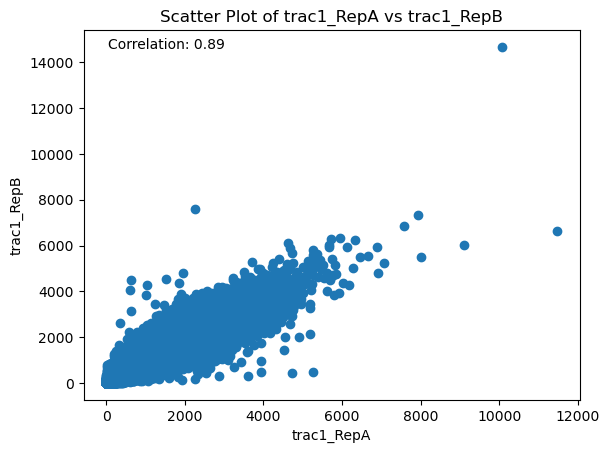

In [191]:

# Calculate correlation
corr = brunello_norm_df['trac1_RepA'].corr(brunello_norm_df['trac1_RepB'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac1_RepA'], brunello_norm_df['trac1_RepB'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac1_RepA')
plt.ylabel('trac1_RepB')
plt.title('Scatter Plot of trac1_RepA vs trac1_RepB')

# Show the plot
plt.show()

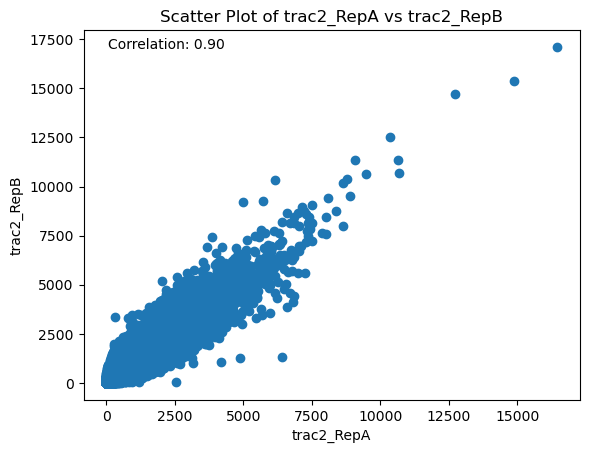

In [192]:

# Calculate correlation
corr = brunello_norm_df['trac2_RepA'].corr(brunello_norm_df['trac2_RepB'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac2_RepA'], brunello_norm_df['trac2_RepB'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac2_RepA')
plt.ylabel('trac2_RepB')
plt.title('Scatter Plot of trac2_RepA vs trac2_RepB')

# Show the plot
plt.show()

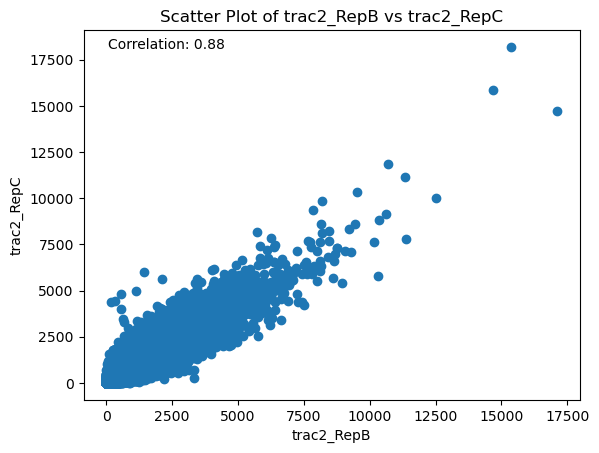

In [193]:

# Calculate correlation
corr = brunello_norm_df['trac2_RepB'].corr(brunello_norm_df['trac2_RepC'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac2_RepB'], brunello_norm_df['trac2_RepC'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac2_RepB')
plt.ylabel('trac2_RepC')
plt.title('Scatter Plot of trac2_RepB vs trac2_RepC')

# Show the plot
plt.show()

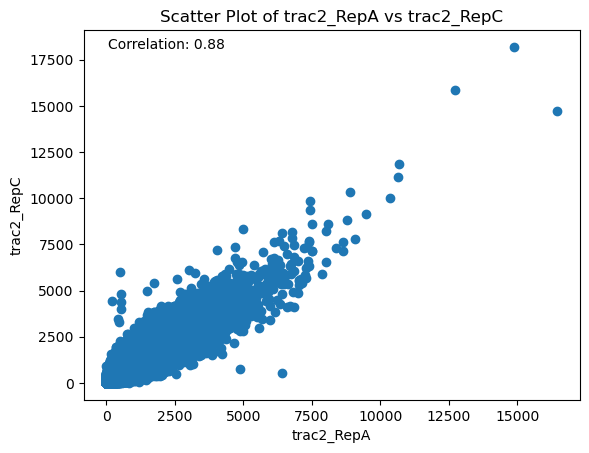

In [194]:
# Calculate correlation
corr = brunello_norm_df['trac2_RepA'].corr(brunello_norm_df['trac2_RepC'])

# Create scatter plot
plt.scatter(brunello_norm_df['trac2_RepA'], brunello_norm_df['trac2_RepC'])

# Annotate correlation
plt.annotate(f"Correlation: {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction')

# Set labels and title
plt.xlabel('trac2_RepA')
plt.ylabel('trac2_RepC')
plt.title('Scatter Plot of trac2_RepA vs trac2_RepC')

# Show the plot
plt.show()

In [195]:
show(brunello_norm_df['Annotation'].value_counts())

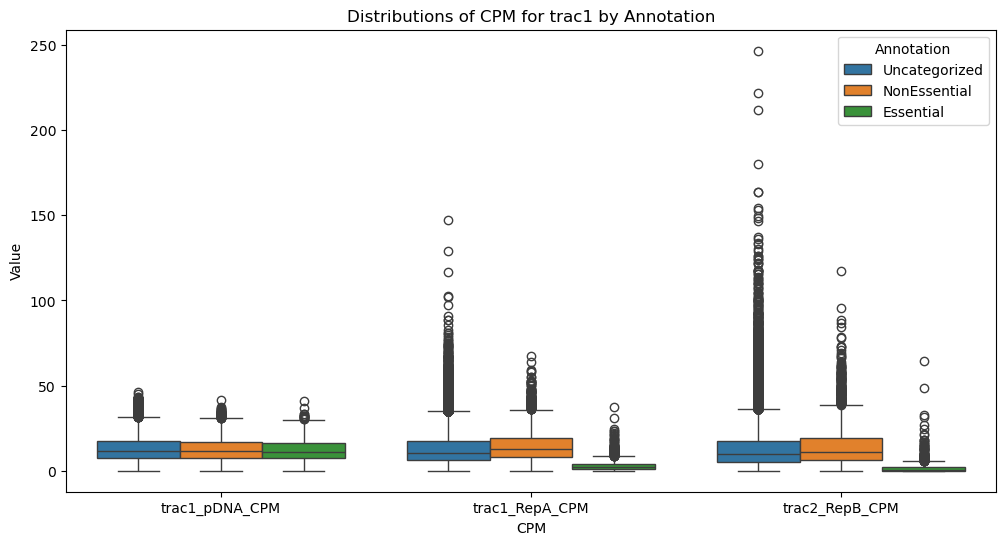

In [196]:
# Select the columns of interest
columns = ['trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac2_RepB_CPM', 'Annotation']

# Create a new dataframe with the selected columns
df_selected = brunello_norm_df[columns]

# Melt the dataframe to convert it to long format
df_melted = df_selected.melt(id_vars='Annotation', var_name='CPM', value_name='Value')

# Plot the distributions using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='CPM', y='Value', hue='Annotation')
plt.title('Distributions of CPM for trac1 by Annotation')
plt.xlabel('CPM')
plt.ylabel('Value')
plt.show()

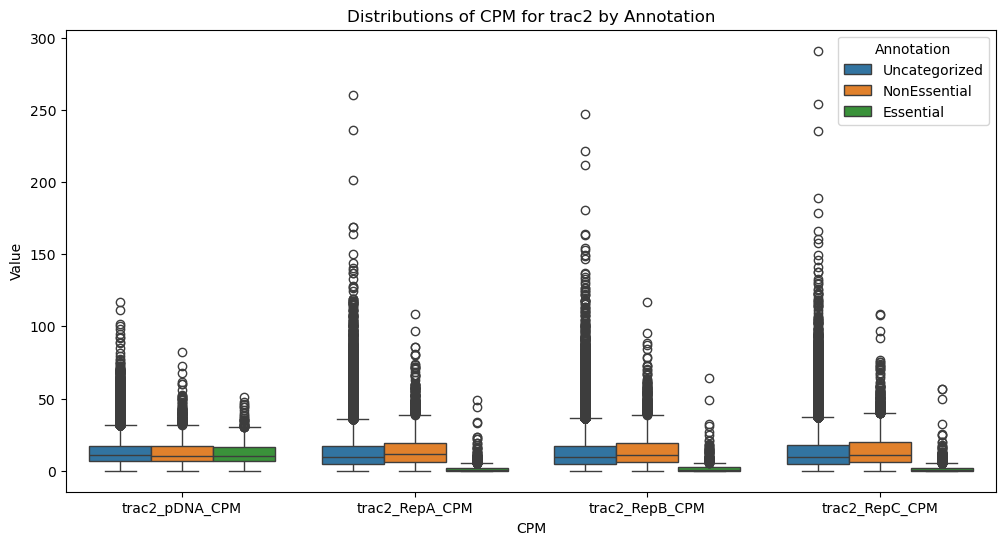

In [197]:
# Select the columns of interest
columns = ['trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM', 'Annotation']

# Create a new dataframe with the selected columns
df_selected = brunello_norm_df[columns]

# Melt the dataframe to convert it to long format
df_melted = df_selected.melt(id_vars='Annotation', var_name='CPM', value_name='Value')

# Plot the distributions using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='CPM', y='Value', hue='Annotation')
plt.title('Distributions of CPM for trac2 by Annotation')
plt.xlabel('CPM')
plt.ylabel('Value')
plt.show()

# Conclusions

* The distribution by Annotation looks pretty similar for the pDNA (which is hte starting material).
* the essential genes seem to drop (which is expected)
* There seem to be some differences between the 'NonEssential' and 'Uncategorized' - suggestions there is some missing information.

# Look at Israeli data

In [198]:
israeli_df=pd.read_csv(israeli, header=0, delimiter="\t")
show(israeli_df.head())

In [199]:
is_cols=['WT', 'Alpha_1', 'Alpha_2', 'Beta_1', 'Beta_2', 'Uninfected_1', 'Uninfected_2', 'Input_1', 'Input_2']
#for col in cols:
#    total_counts = brunello_df[col].sum()
#    normalized_col_name = col + '_CPM'  # Create a new column name for the normalized data
#    brunello_df[normalized_col_name] = (brunello_df[col] / total_counts) * 1_000_000

for col in is_cols:
    israeli_norm_df=cal_cpm(israeli_df, col)

del israeli_df

show(israeli_norm_df)

In [206]:
israeli_norm_df.to_csv('../data/processed/israeli_norm_data.csv', index=False)

# Not at guide level

Sadly, the Israeli data is not at the guide level, but at the gene level. 

Will plot distributions, but this si probably not as useful, though, I can aggregate counts in the Brunello data at the gene level and see if the distributions look the same.

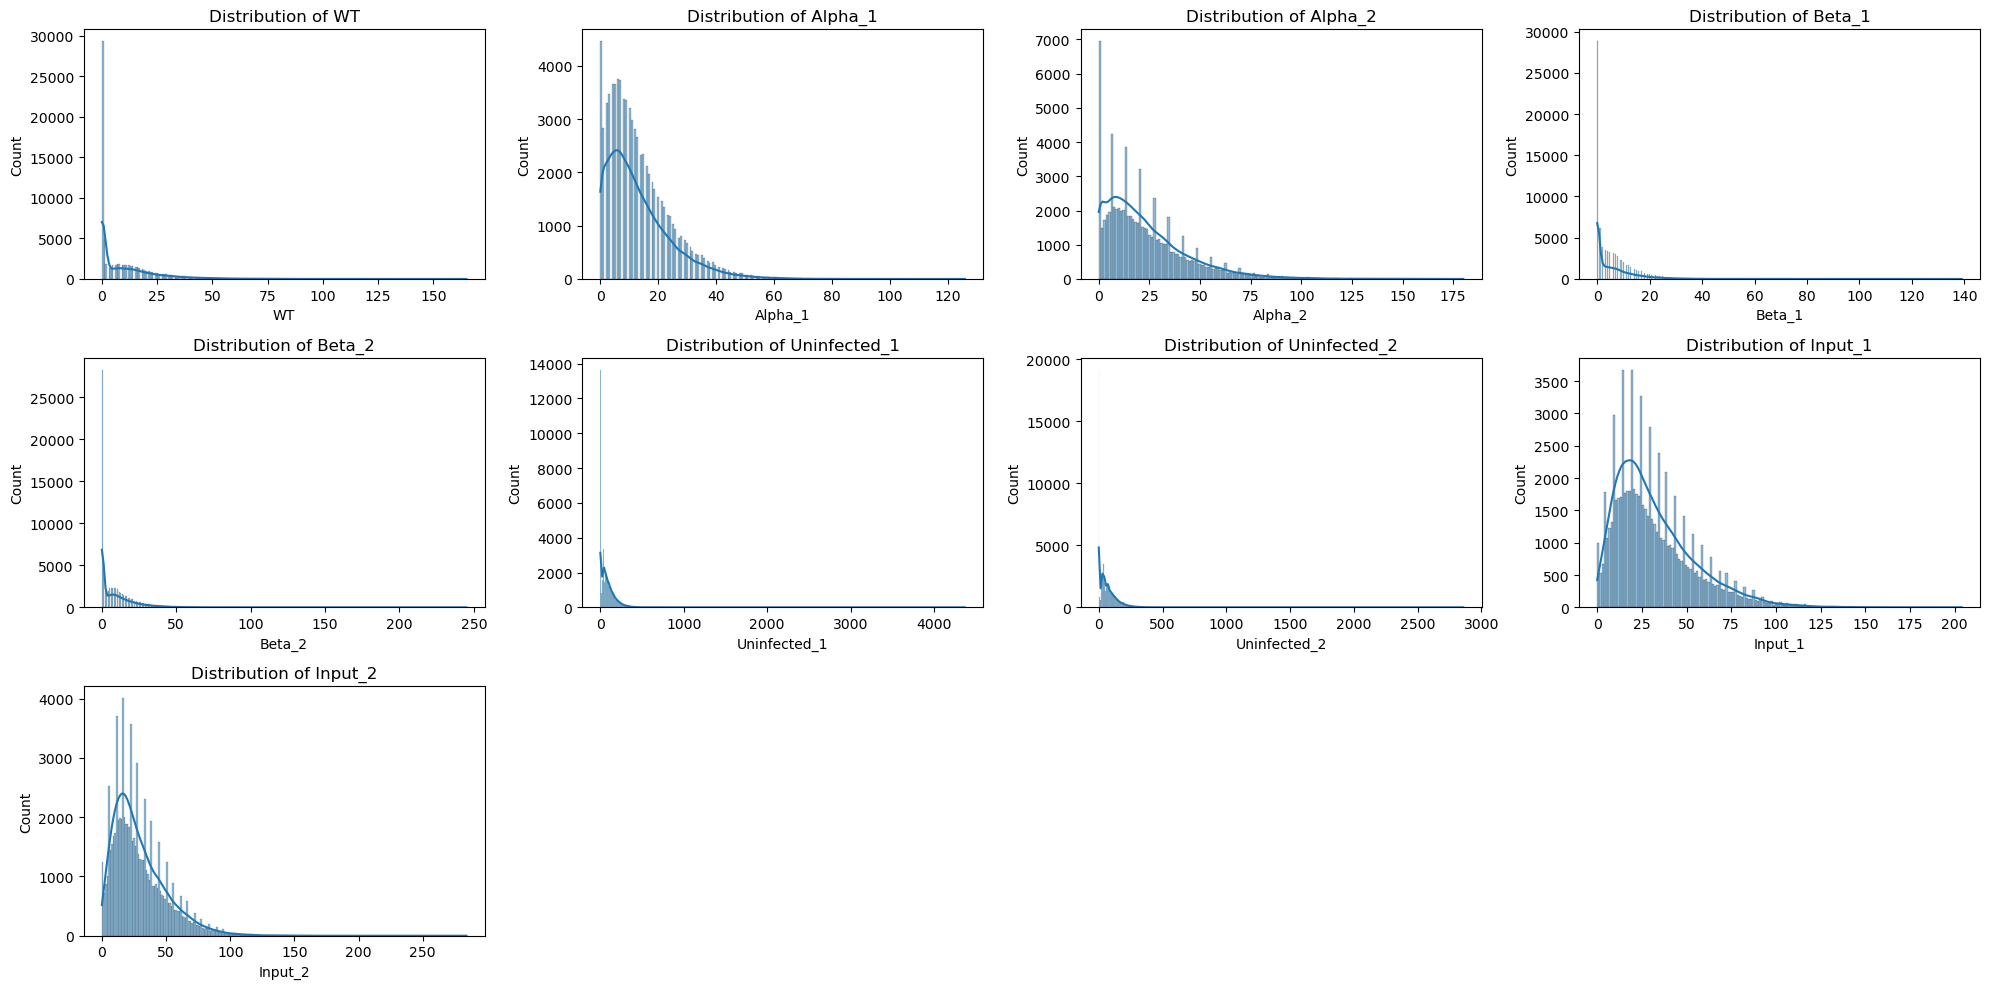

In [200]:
dist_plots(israeli_norm_df, is_cols)

plt.tight_layout()
plt.show()

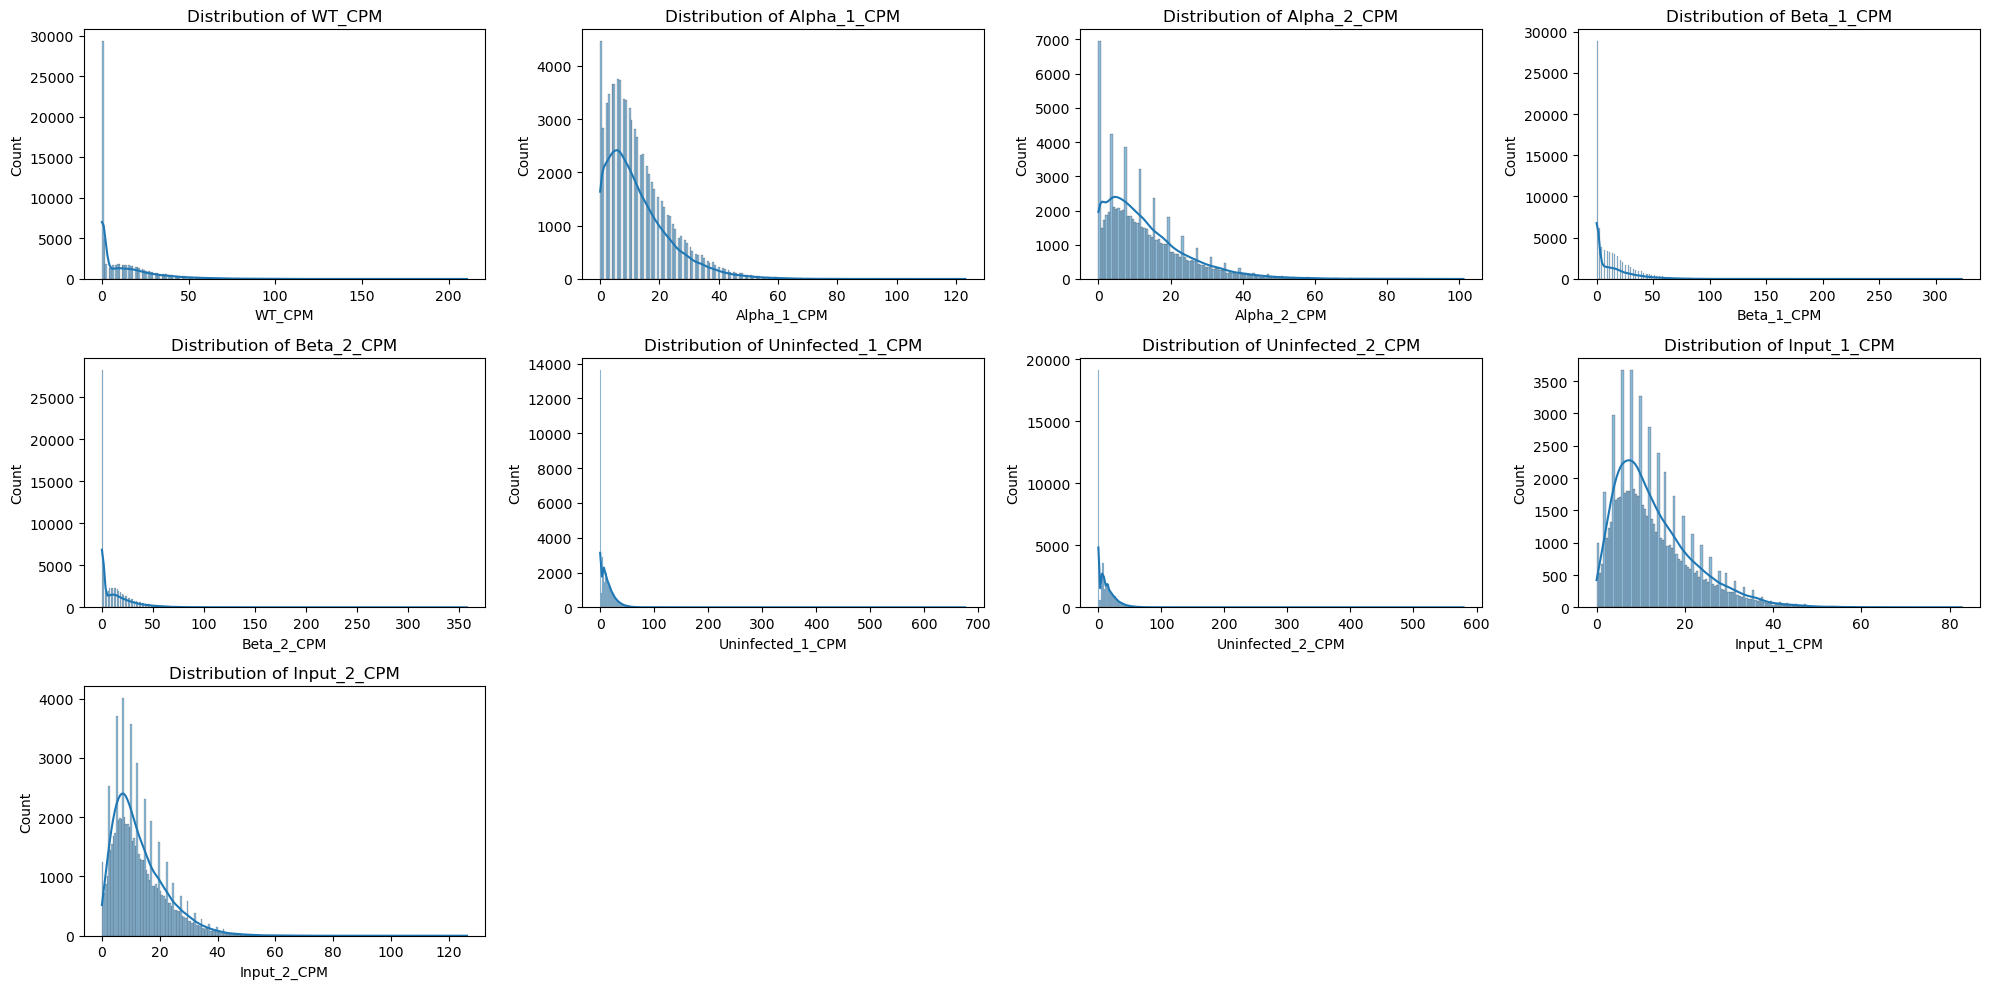

In [201]:
is_norm_cols=[col + '_CPM' for col in is_cols]
dist_plots(israeli_norm_df, is_norm_cols)
plt.tight_layout()
plt.show()

In [202]:
israeli_norm_df.columns

Index(['sgRNA', 'Gene', 'WT', 'Alpha_1', 'Alpha_2', 'Beta_1', 'Beta_2',
       'Uninfected_1', 'Uninfected_2', 'Input_1', 'Input_2', 'WT_CPM',
       'Alpha_1_CPM', 'Alpha_2_CPM', 'Beta_1_CPM', 'Beta_2_CPM',
       'Uninfected_1_CPM', 'Uninfected_2_CPM', 'Input_1_CPM', 'Input_2_CPM'],
      dtype='object')

Processing WT
Processing Alpha_1
Processing Alpha_2
Processing Beta_1
Processing Beta_2
Processing Uninfected_1
Processing Uninfected_2
Processing Input_1
Processing Input_2


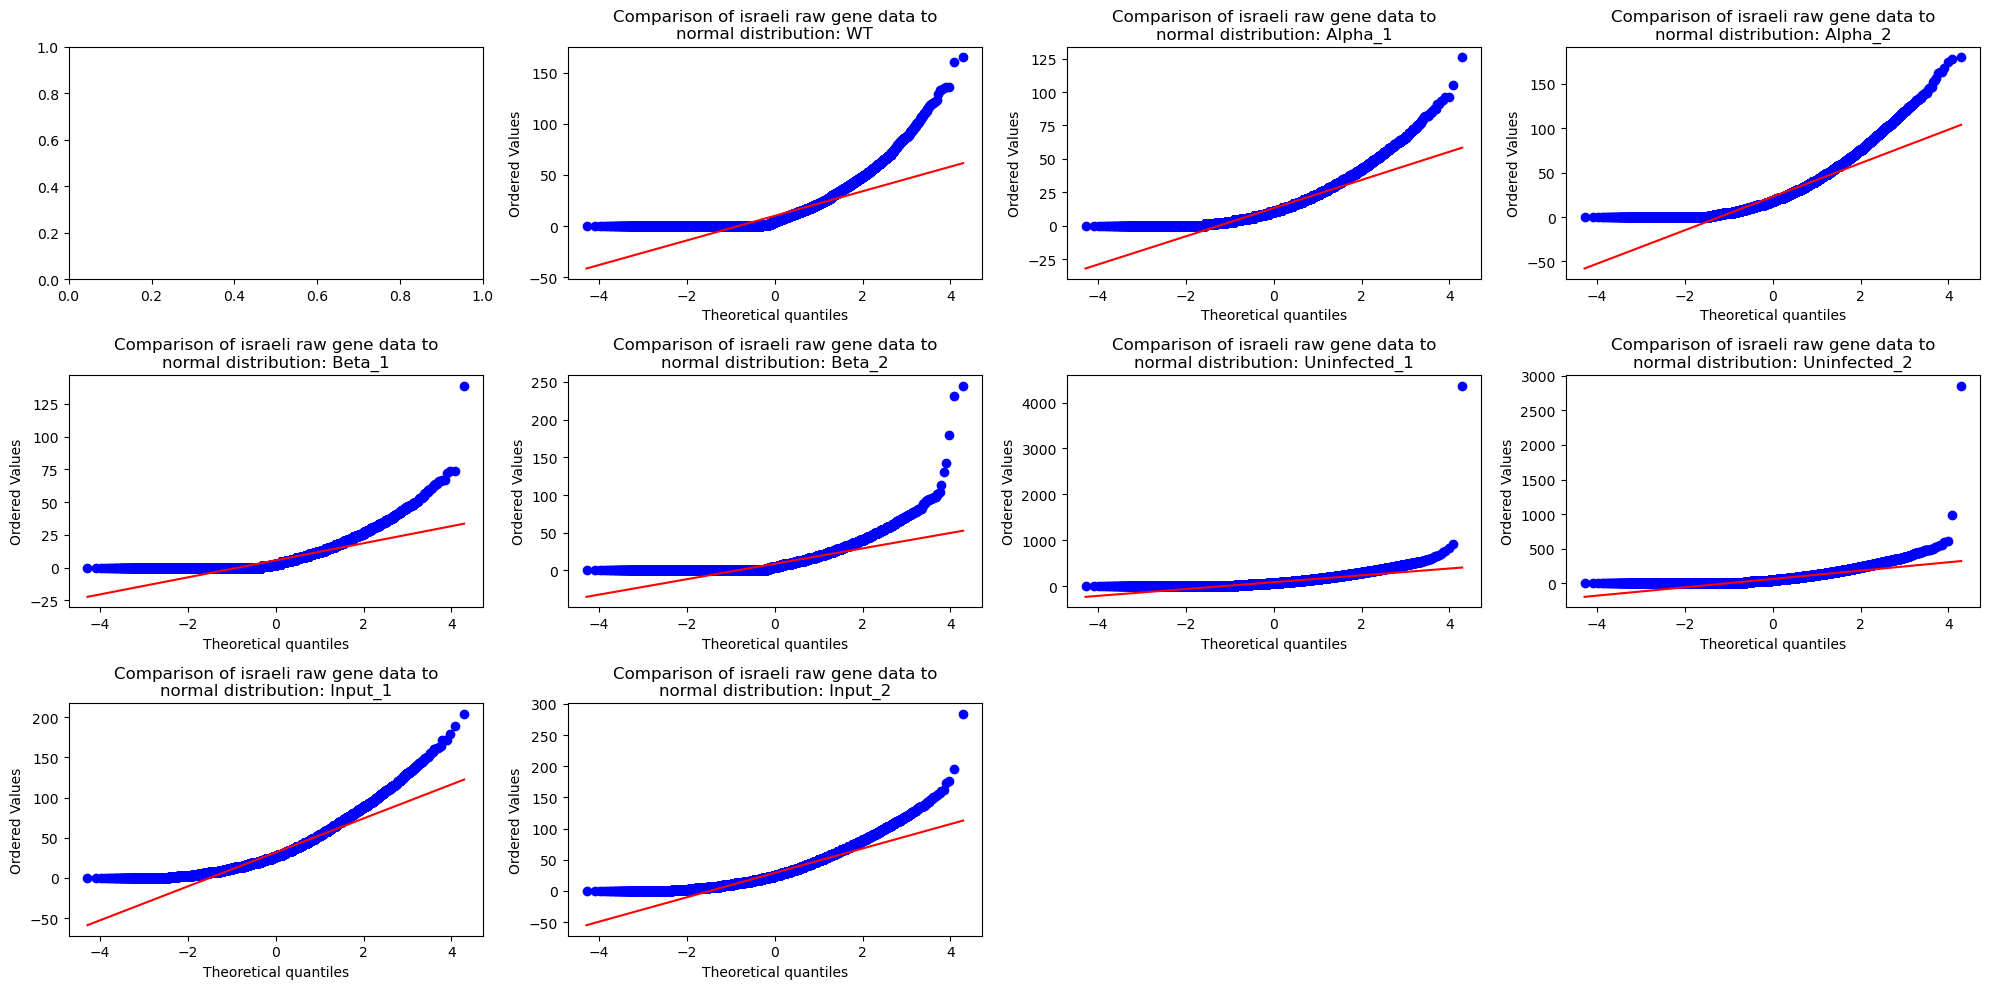

In [203]:
q_q_plots(israeli_norm_df, "norm", is_cols, "Comparison of israeli raw gene data to normal distribution")
plt.tight_layout()
plt.show()

# Conclusion

Because the Israeli data is at the gene level, I don't think it is worth doing too much more with this. However, it is interesting to see the Q-Q plots looks similiar to the Brunello guide level data. 

# Conclusion: Entire dataset distributions

* For the 'control' (that is the plasmid library prior to being put into cells): the distribution looks different at different ends of the plot. 
* The test data (that is cells that have been subject to selection) have distributions that look different from the control. 
* Plotting the distributions of the different quartiels shows the differences in the distributions
    * Is it possible to use different models depending on where things are in the distribution.
* There are differences in Nonessential and Essential genes in the different quartiles, though surprisingly there are still some essential genes in the highest quartile. 


# System info

In [204]:
!conda list

# packages in environment at /Users/deannachurch/opt/anaconda3/envs/sb_capstone:
#
# Name                    Version                   Build  Channel
annotated-types           0.7.0              pyhd8ed1ab_0    conda-forge
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312h02f2b3b_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
bcbio-gff                 0.7.1                    pypi_0    pypi
beautifulsoup4            4.12.3             pyha770c7